# Multi-Task Learning (MTL) vs. Single-Task Learning (STL) for Image Classification on CIFAR-10

This notebook explores and compares Multi-Task Learning (MTL) and Single-Task Learning (STL) approaches for image classification using the CIFAR-10 dataset. We will utilize AlexNet-like architectures as the base for our neural networks and investigate both hard and soft parameter sharing mechanisms for MTL.

## Tasks
We define two **uncorrelated** tasks—the goal is to understand how a single model behaves when learning them jointly:
1. **Task 1 (Multi-class Classification):** Classify the images into one of the 10 CIFAR-10 categories.  
2. **Task 2 (Rotation Classification):** Determine whether the image is rotated by 0°, 90°, 180° or 270°.

## Learning Approaches Explored
- **Hard Parameter Sharing MTL:** A single AlexNet-based network with a shared backbone and two task-specific heads.  
- **Soft Parameter Sharing MTL (Cross-Stitch Network):** Two separate AlexNet-based networks (one per task) connected by cross-stitch layers that learn linear combinations of intermediate feature maps.  
- **Single-Task Learning (STL):** Two entirely independent AlexNet-based networks, each trained on only one of the tasks, with no shared parameters.

## Objectives
- Implement and train both MTL variants (hard and soft parameter sharing) as well as STL baselines.  
- Compare their performance on each task, and analyze how joint learning of two uncorrelated tasks affects accuracy, convergence speed, and generalization.


In [6]:
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import pandas as pd # For saving results to CSV
from pathlib import Path # For checking if model files exist
import humanize # For human-readable parameter counts
import time
from PIL import Image

## 1. Setup and Configuration

### 1.1. Reproducibility

Setting random seeds ensures that experiments are reproducible, which is crucial for comparing models.


In [7]:
# Set a seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Disable benchmark for full reproducibility

if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # For Apple Silicon GPU
    torch.mps.manual_seed(SEED)

### 1.2. Device Selection

Selects the appropriate computation device (GPU if available, otherwise CPU).

In [8]:
# Select the execution device (CUDA GPU, MPS, or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')

print(f"Selected device: {device}")

Selected device: cuda


## 2. MultiTaskCIFAR10
In PyTorch, extending a standard single-task dataset for Multi-Task Learning (MTL) is quite straightforward. Below we walk through, step by step, how our `MultiTaskCIFAR10` class works.

### 2.1. Why wrap the original dataset?

- The built-in `torchvision.datasets.CIFAR10` returns **one image** and **one label** (the object class) per index.
- For MTL, we need **two labels** per image:  
  1. The original 10-way object class  
  2. A 4-way rotation class (0°, 90°, 180°, 270°)  
- We “wrap” CIFAR-10 so that each call to `__getitem__` returns a **tuple** `(image, class_label, rotation_label)`.

In [9]:
class MultiTaskCIFAR10(datasets.CIFAR10):
    """
    CIFAR-10 expanded for two tasks:
      - Task 1: classify into 10 CIFAR-10 object classes
      - Task 2: classify rotation into 4 angles (0°, 90°, 180°, 270°)

    Each original image is repeated 4 times, once per rotation angle.
    """

    def __init__(self, root, train=True, download=True, base_transform=None):
        super().__init__(root, train=train, download=download,
                         transform=None, target_transform=None)
        self.base_transform = base_transform
        # Define the rotation angles
        self.angles = [0, 90, 180, 270]
        # Expanded length = 4 × number of original images
        # Tells PyTorch how many samples the new dataset has (4× more than CIFAR-10).
        self.expanded_len = len(self.data) * len(self.angles)

    def __len__(self):
        # Return the expanded dataset size
        return self.expanded_len

    def __getitem__(self, idx):
        # Picks one of the 50,000 original images.
        angle_idx = idx % 4
        # Picks one of the four rotations.
        orig_idx  = idx // 4

        # Load the original image as a PIL.Image
        img = Image.fromarray(self.data[orig_idx])

        # Get the original CIFAR-10 class label (0–9)
        class_label = self.targets[orig_idx]

        # Rotate the image without changing its size (32×32)
        angle = self.angles[angle_idx]
        img = img.rotate(angle, expand=False)

        # Apply any final transforms (ToTensor, Normalize, etc.)
        if self.base_transform is not None:
            img = self.base_transform(img)

        # Rotation label is simply angle_idx (0..3)
        rotation_label = angle_idx

        # Return (image, class_label, rotation_label)
        return img, class_label, rotation_label

### 2.2 Download Dataset

In [10]:
# Training and Test datasets

train_ds = MultiTaskCIFAR10(
    root='./data',
    train=True,
    download=True,
    base_transform=transforms.ToTensor()
)

test_ds = MultiTaskCIFAR10(
    root='./data',
    train=False,
    download=False,
    base_transform=transforms.ToTensor()
)


**Note**: `ToTensor()` converts a PIL image or NumPy array into a float torch.Tensor with channels-firs`
 ordering and scales pixel values to [0, 1], making them compatible with PyTorch models and subsequent transforms.

## 3. Validation Set (10% of Training Data)

The validation set is used to monitor the model's performance during training and check whether it is overfitting.

1. **Calculate split sizes**  
   - Let \(N\) be the total number of samples in the expanded training dataset.  
   - Validation size = $\lfloor 0.10 \times N\rfloor$  
   - Training size     = $N - \text{Validation size}$

2. **Use a deterministic split**  
   - We use `torch.utils.data.random_split` with a fixed random seed so that our train/validation partition is reproducible across runs.


In [11]:
# 90% for training, 10% for validation
val_size   = int(0.1 * len(train_ds))
train_size = len(train_ds) - val_size

# Split with a fixed seed for reproducibility
train_ds, val_ds = random_split(
    train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

## 4. Visualize Rotated Samples

Before proceeding to training, it's useful to **visualize some samples** from the expanded dataset to ensure that both tasks are correctly prepared:

- **Task 1**: The image content still belongs to one of the 10 CIFAR-10 categories.
- **Task 2**: Each image has been rotated by exactly 0°, 90°, 180°, or 270°.

The following code displays a small batch of images, along with:
- The **true class label** from CIFAR-10 (e.g., 'cat', 'airplane')
- The **applied rotation angle** as a label for Task 2

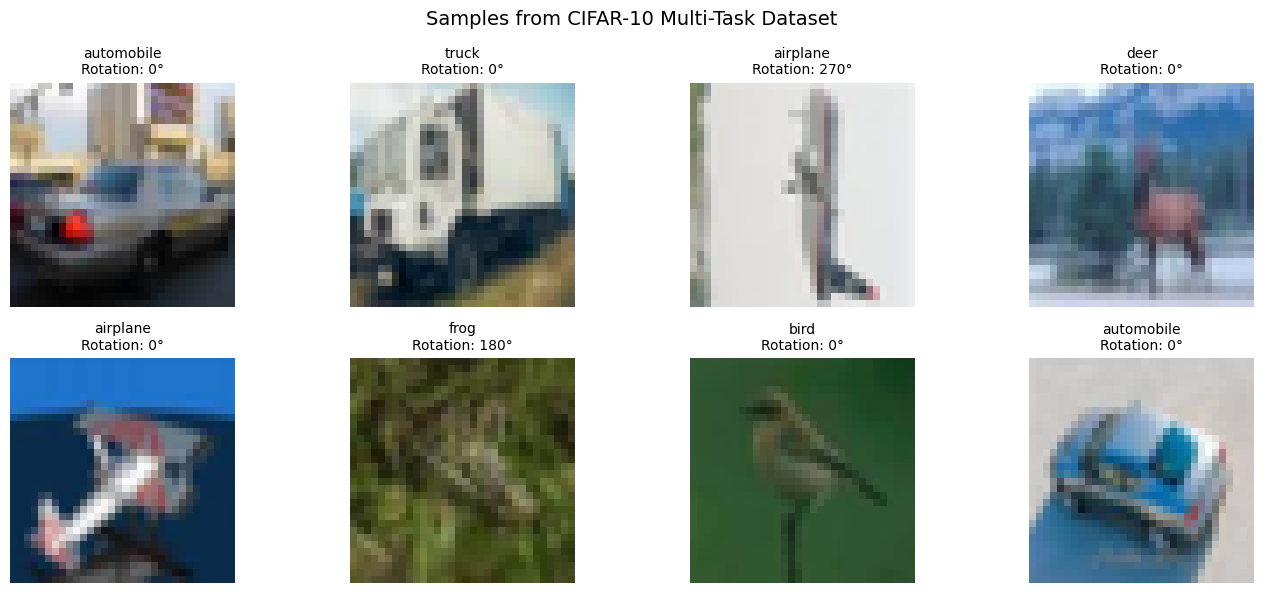

In [12]:
# Function to show one image
def imshow(img):
    npimg = img.numpy() # Covert the image to Numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from [C, H, W] to [H, W, C]
    plt.axis('off')

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Task 2 labesl
rotation_labels = ['0°', '90°', '180°', '270°']

# Load a batch of 8 random samples from the dataset
data_iter = iter(DataLoader(train_ds, batch_size=8, shuffle=True))

images, class_targets, rot_targets = next(data_iter)

# Plot each image in a 2x4 grid with corresponding labels
plt.figure(figsize=(14, 6))
for idx in range(len(images)):
    plt.subplot(2, 4, idx+1)
    imshow(images[idx])
    title = f"{class_names[class_targets[idx]]}\nRotation: {rotation_labels[rot_targets[idx]]}"
    plt.title(title, fontsize=10)
plt.suptitle("Samples from CIFAR-10 Multi-Task Dataset", fontsize=14)
plt.tight_layout()
plt.show()


## 5. DataLoader

To efficiently feed data into the model during training and evaluation, we define PyTorch `DataLoader` objects for the training, validation, and test sets.

Key choices:
- **Batch size**: Typically a power of 2 (e.g., 64) for performance.
- **Shuffling**: Enabled for training set to improve generalization.


In [13]:
# Batch size
BATCH_SIZE = 64

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## 6. Architectures

In this section, we define and implement all architectures used in this project:

- **Hard Parameter Sharing MTL**: A single AlexNet-based model with a shared backbone and two task-specific output heads.
- **Soft Parameter Sharing MTL (Cross-Stitch Network)**: Two parallel AlexNet models with cross-stitch units that learn how to share intermediate features.
- **Single-Task Learning (STL)**: Two separate AlexNet-inspired models, one per task, trained independently.


**Note**: The original **AlexNet** architecture was designed for 224x224 pixel images. Since CIFAR-10 images are only **32x32**, we will adapt it to suit CIFAR-10's 32x32 image dimensions.

For reference, see the official [PyTorch AlexNet implementation](https://docs.pytorch.org/vision/main/_modules/torchvision/models/alexnet.html#alexnet).


### 6.1. Base Feature Extractor
This block of layers, defining a sequence of convolutional, ReLU, and max pooling operations, is common to all architectures implemented in this notebook and serves as the primary feature extractor.

1.  $Conv2d(3, 64, kernel\_size=3, stride=1, padding=1)$
2.  $ReLU$
3.  $MaxPool2d(kernel\_size=2, stride=2)$
4.  $Conv2d(64, 192, kernel\_size=3, padding=1)$
5.  $ReLU$
6.  $MaxPool2d(kernel\_size=2, stride=2)$
7.  $Conv2d(192, 384, kernel\_size=3, padding=1)$
8.  $ReLU$
9.  $Conv2d(384, 256, kernel\_size=3, padding=1)$
10. $ReLU$
11. $Conv2d(256, 256, kernel\_size=3, padding=1)$
12. $ReLU$
13. $MaxPool2d(kernel\_size=2, stride=2)$

### 6.2. Hard Parameter Sharing MTL

In the **Hard Parameter Sharing** approach, a shared base feature extractor (defined previously) feeds into another block. Together, these two components form the **shared backbone** of the network, which is used by both tasks before branching into task-specific output heads.

1. $Dropout(0.5)$ – Regularization to prevent overfitting.
2. $Linear(4096, 1024)$
3. $ReLU$ – Non-linearity.
4. $Dropout(0.5)$
5. $Linear(1024, 1024)$
6. $ReLU$

#### 6.2.1. Task-Specific Output Heads
After the shared representation, we define separate "heads" for each task:

- **Task 1 – CIFAR-10 classification (10 classes)**:
  - $Linear(1024, 10)$

- **Task 2 – Image rotation classification (4 classes: 0°, 90°, 180°, 270°)**:
  - $Linear(1024, 4)$

Each head is trained with its corresponding target and loss function.

#### 6.2.2. Loss Function
The final loss is a simple sum of the individual task losses:

$$
L_{\text{total}} = L_{\text{task1}} + L_{\text{task2}}
$$

> **Note**: You may optionally apply different weights to each loss if the tasks are imbalanced or of unequal importance:
$$
L_{\text{total}} = \alpha \cdot L_{\text{task1}} + \beta \cdot L_{\text{task2}}
$$


In [9]:
class AlexNetMTLHardShare(nn.Module):
    def __init__(self, output_dim_task1: int, output_dim_task2: int):
        super(AlexNetMTLHardShare, self).__init__()

        # ----------------------------------
        # 1. Shared Feature Extractor (CNN Backbone)
        # ----------------------------------
        # This part extracts visual features from the input images.
        # It's shared across both tasks, learning general representations.
        # The architecture is inspired by AlexNet but adapted for smaller inputs (e.g., 32x32).
        self.feature_extractor = nn.Sequential(
            # Conv Block 1: 3x32x32 -> 64x16x16
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2: 64x16x16 -> 192x8x8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3: 192x8x8 -> 384x8x8
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv Block 4: 384x8x8 -> 256x8x8
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv Block 5: 256x8x8 -> 256x4x4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        # This is 256 (channels) * 4 (height) * 4 (width) based on the last MaxPool output.
        self.flattened_feature_size = 256 * 4 * 4  # 4096

        # ----------------------------------
        # 2. Shared Dense Block
        # ----------------------------------
        # This block takes the flattened features and processes them through
        # shared fully connected layers and regularization (Dropout).
        # It creates a high-level shared representation.
        self.shared_dense_block = nn.Sequential(
            nn.Dropout(p=0.5),                              # Dropout for regularization
            nn.Linear(self.flattened_feature_size, 1024),   # First FC layer
            nn.ReLU(inplace=True),                          # ReLU activation
            nn.Dropout(p=0.5),                              # Dropout for regularization
            nn.Linear(1024, 1024),                          # Second FC layer
            nn.ReLU(inplace=True),                          # ReLU activation
        )

        # ----------------------------------
        # 3. Task-Specific Heads
        # ----------------------------------
        # These are the final layers, specific to each task.
        # They take the shared representation and produce the logits
        # (raw scores) for their respective tasks.

        # Head for Task 1 (e.g., CIFAR-10 Classification)
        self.task1_head = nn.Linear(1024, output_dim_task1)

        # Head for Task 2 (e.g., Rotation Classification)
        self.task2_head = nn.Linear(1024, output_dim_task2)

    def forward(self, input_image: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Defines the forward pass of the network.

        Args:
            input_image (torch.Tensor): The input batch of images
                                        (e.g., shape [batch_size, 3, 32, 32]).

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the
                                               logits for Task 1 and Task 2.
        """
        # 1. Extract features using the shared CNN backbone.
        features = self.feature_extractor(input_image)

        # 2. Flatten the features to prepare for the dense layers.
        #    We preserve the batch dimension (features.size(0)) and flatten the rest.
        flattened_features = features.view(features.size(0), -1)

        # 3. Generate the shared representation using the shared dense block.
        shared_representation = self.shared_dense_block(flattened_features)

        # 4. Generate the final outputs (logits) using task-specific heads.
        logits_task1 = self.task1_head(shared_representation)
        logits_task2 = self.task2_head(shared_representation)

        # 5. Return the outputs for both tasks.
        return logits_task1, logits_task2

### 6.3. Soft Parameter Sharing: Cross-Stitch Network
Cross-Stitch Networks are a deep learning architecture designed for **multi-task learning (MTL)**. The core idea behind this architecture is to allow separate network branches, typically dedicated to different tasks, to selectively share and combine information at various layers. This is achieved through "cross-stitch" layers, which learn linear combinations of the feature activations from the different task-specific pathways. By adaptively learning how much information to share or keep task-specific, cross-ctitch networks aim to improve overall performance on multiple related tasks simultaneously, potentially leveraging shared representations while still allowing for specialized feature learning for each individual task. This approach can be particularly beneficial when tasks are related but may require different levels of feature abstraction or focus.

#### 6.3.1. How Cross-Stitch Layers Work

Consider two parallel network branches, A and B, for two different tasks. At a specific layer $l$, let $x_A^{(l)}$ be the entire activation map (or feature vector) in the $l$-th layer of network A, and $x_B^{(l)}$ be the corresponding activation map (or feature vector) in network B. The cross-stitch layer takes these activations as input and produces new combined activations $\tilde{x}_A^{(l)}$ and $\tilde{x}_B^{(l)}$ that will be fed into the next layer of their respective networks.

The transformation is typically a linear combination applied element-wise or to the entire feature vectors:

$$
\begin{bmatrix} \tilde{x}_A^{(l)} \\ \tilde{x}_B^{(l)} \end{bmatrix} =
\begin{bmatrix} \alpha_{AA}^{(l)} & \alpha_{AB}^{(l)} \\ \alpha_{BA}^{(l)} & \alpha_{BB}^{(l)} \end{bmatrix}
\begin{bmatrix} x_A^{(l)} \\ x_B^{(l)} \end{bmatrix}
$$

Where:
- $x_A^{(l)}$ and $x_B^{(l)}$ are the input activations (feature maps or vectors) from the $(l-1)$-th layer (or input to the $l$-th cross-stitch layer) of network A and network B, respectively.
- $\tilde{x}_A^{(l)}$ and $\tilde{x}_B^{(l)}$ are the output activations for the $l$-th layer (or input to the $(l+1)$-th layer) of network A and network B after the cross-stitch operation.
- $\alpha_{AA}^{(l)}, \alpha_{AB}^{(l)}, \alpha_{BA}^{(l)}, \alpha_{BB}^{(l)}$ are scalar parameters learned during the training process.
    - $\alpha_{AA}^{(l)}$ and $\alpha_{BB}^{(l)}$ determine how much of the original activation is passed through to the same task's network at layer $l$.
    - $\alpha_{AB}^{(l)}$ determines how much of task B's activation influences task A at layer $l$.
    - $\alpha_{BA}^{(l)}$ determines how much of task A's activation influences task B at layer $l$.

These $\alpha$ parameters are learned independently for each cross-stitch layer placed at different layers $l$ in the network. This allows the network to learn an optimal, layer-specific sharing strategy.

#### 6.3.2. CrossStitchLayer

The `CrossStitchLayer` class implements the cross-stitch operation. It takes two input feature maps and applies a learned linear combination to produce the output feature maps for both tasks.

* **Initialization (`__init__`)**:
    * Creates a **2x2** `stitch_matrix`. This matrix contains the $\alpha$ parameters that determine how the features from the two tasks will be combined.
    * The matrix is initialized with all values set to **0.5**. This means that, initially, features from both tasks are combined equally.

  $$
    \begin{pmatrix}
    \alpha_{11} & \alpha_{12} \\
    \alpha_{21} & \alpha_{22}
    \end{pmatrix} =\begin{pmatrix}
    0.5 & 0.5 \\
    0.5 & 0.5
    \end{pmatrix}
  $$
    * `self.stitch_matrix` is an `nn.Parameter`, meaning its values (the $\alpha$ coefficients) are learnable and will be updated during the network's training process.

* **Forward (`forward`)**:
    * Takes two input feature maps `x1` (from task 1) and `x2` (from task 2).
    * Computes the output feature maps by applying the learned linear combination using the `stitch_matrix`:
        * `output_x1 = self.stitch_matrix[0, 0] * x1 + self.stitch_matrix[0, 1] * x2`
        * `output_x2 = self.stitch_matrix[1, 0] * x1 + self.stitch_matrix[1, 1] * x2`
    * The output is a tuple of two feature maps, `(output_x1, output_x2)`, one for each task.

In [ ]:
# Cross-Stitch Layer
class CrossStitchLayer(nn.Module):
    def __init__(self):
        super(CrossStitchLayer, self).__init__()

        # Initialize the stitch matrix.
        initial_matrix = torch.tensor([[0.5, 0.5], [0.5, 0.5]], dtype=torch.float)

        self.stitch_matrix = nn.Parameter(initial_matrix) # Make it a learnable parameter

    def forward(self, input_task1, input_task2):

        # Apply linear combination: output_A = alpha_AA * input_A + alpha_AB * input_B
        output_task1 = self.stitch_matrix[0,0] * input_task1 + self.stitch_matrix[0,1] * input_task2
        output_task2 = self.stitch_matrix[1,0] * input_task1 + self.stitch_matrix[1,1] * input_task2

        return output_task1, output_task2

#### 6.3.3. CrossStitchNetwork
The `CrossStitchNetwork` class implements the full architecture for the Cross-Stitch Network. It splits the **base feature extractor** defined in the **section 6.1**, which forms the shared backbone, into **3 blocks**:

1. **Block 1**:
  * $Conv2d(3, 64, kernel\_size=3, stride=1, padding=1)$
  * $ReLU$
  * $MaxPool2d(kernel\_size=2, stride=2)$
2. **Block 2**:
  * $Conv2d(64, 192, kernel\_size=3, padding=1)$
  * $ReLU$
  * $MaxPool2d(kernel\_size=2, stride=2)$
3. **Block 3**:
  * $Conv2d(192, 384, kernel\_size=3, padding=1)$
  * $ReLU$
  * $Conv2d(384, 256, kernel\_size=3, padding=1)$
  * $ReLU$
  * $Conv2d(256, 256, kernel\_size=3, padding=1)$
  * $ReLU$
  * $MaxPool2d(kernel\_size=2, stride=2)$

Cross-stitch layers are then placed **after** **pooling** layers and **fully connected** layers.

```python
                     INPUT
                       |
                       ▼
    Block 1 (Task 1)      Block 1 (Task 2)
                       |
                       ▼
                CrossStitchLayer
                       |
                       ▼
    Block 2 (Task 1)      Block 2 (Task 2)
                       |
                CrossStitchLayer
                       |
                       ▼
    Block 3 (Task 1)      Block 3 (Task 2)
                       |
                       ▼
                CrossStitchLayer
                       |
                       ▼
                      ...
```
The task-specific heads are defined as follows:
1.  **Task 1 Head**:
    * $Dropout(0.5)$
    * $Linear(4096, 1024)$
    * $ReLU$
    * $Dropout(0.5)$
    * $Linear(1024, 1024)$
    * $ReLU$
    * $Linear(1024, 10)$
2.  **Task 2 Head**:
    * $Dropout(0.5)$
    * $Linear(4096, 1024)$
    * $ReLU$
    * $Dropout(0.5)$
    * $Linear(1024, 1024)$
    * $ReLU$
    * $Linear(1024, 2)$



#### 6.3.4. Loss Function
The final loss is a simple sum of the individual task losses:

$$
L_{\text{total}} = L_{\text{task1}} + L_{\text{task2}}
$$

> **Note**: You may optionally apply different weights to each loss if the tasks are imbalanced or of unequal importance:
$$
L_{\text{total}} = \alpha \cdot L_{\text{task1}} + \beta \cdot L_{\text{task2}}
$$

In [11]:
class CrossStitchNetwork(nn.Module):

    def __init__(self, output_dim_task1: int, output_dim_task2: int):
        super(CrossStitchNetwork, self).__init__()

        # --- Task 1 Pathway ---
        self.task1_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x16x16
        )
        self.task1_block2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 192x8x8
        )
        self.task1_block3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x4x4
        )

        # --- Task 2 Pathway ---
        self.task2_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.task2_block2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.task2_block3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Flattened Size ---
        self.flattened_size = 256 * 4 * 4  # 4096

        # --- Task 1 Fully Connected layer 1 ---
        self.task1_fc_layer_1 = nn.Linear(self.flattened_size, 1024)

        # --- Task 1 Fully Connected layer 2 ---
        self.task1_fc_layer_2 = nn.Linear(1024, 1024) # Second FC layer

        # --- Task 1 Fully Connected layer 3 ---
        self.task1_fc_layer_3 = nn.Linear(1024, output_dim_task1) # Output for Task 1

        # --- Task 2 Fully Connected layer 1 ---
        self.task2_fc_layer_1 = nn.Linear(self.flattened_size, 1024)

        # --- Task 2 Fully Connected layer 2 ---
        self.task2_fc_layer_2 = nn.Linear(1024, 1024) # Second FC layer

        # --- Task 2 Fully Connected layer 3 ---
        self.task2_fc_layer_3 = nn.Linear(1024, output_dim_task2) # Output for Task 2


        # --- Cross-Stitch Layers ---
        self.cross_stitch1 = CrossStitchLayer() # After Block 1 (after pooling layer)
        self.cross_stitch2 = CrossStitchLayer() # After Block 2 (after pooling layer)
        self.cross_stitch3 = CrossStitchLayer() # After Block 3 (after pooling layer)
        self.cross_stitch4 = CrossStitchLayer() # After after fully connected layer 1
        self.cross_stitch5 = CrossStitchLayer() # After after fully connected layer 2

    def forward(self, input_data: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Defines the forward pass through the Cross-Stitch network.

        Args:
            input_data (torch.Tensor): The input batch of images.
                                       It's fed into both task pathways initially.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing the
                                               logits (raw outputs) for Task 1 and Task 2.
        """
        # --- Initial Input ---
        # The same input goes to both task pathways at the start.
        x_task1 = input_data
        x_task2 = input_data

        # --- Block 1 & Cross-Stitch 1 ---
        t1_b1_out = self.task1_block1(x_task1)
        t2_b1_out = self.task2_block1(x_task2)

        # Apply the first Cross-Stitch layer to share features.
        t1_cs1_out, t2_cs1_out = self.cross_stitch1(t1_b1_out, t2_b1_out)

        # --- Block 2 & Cross-Stitch 2 ---
        t1_b2_out = self.task1_block2(t1_cs1_out)
        t2_b2_out = self.task2_block2(t2_cs1_out)

        # Apply the second Cross-Stitch layer.
        t1_cs2_out, t2_cs2_out = self.cross_stitch2(t1_b2_out, t2_b2_out)

        # --- Block 3 (Final Features) ---
        t1_b3_out = self.task1_block3(t1_cs2_out)
        t2_b3_out = self.task2_block3(t2_cs2_out)

        # Apply the third Cross-Stitch layer.
        t1_c23_out, t2_c23_out = self.cross_stitch3(t1_b3_out, t2_b3_out)

        # --- Flattening ---
        t1_flat = t1_c23_out.view(t1_c23_out.size(0), -1)
        t2_flat = t2_c23_out.view(t2_c23_out.size(0), -1)

        # Dropout
        t1_flat = nn.Dropout(0.5)(t1_flat)
        t2_flat = nn.Dropout(0.5)(t2_flat)

        # --- Fully Connected Layer 1 & Cross-Stitch 4 ---
        t1_fc1_out = self.task1_fc_layer_1(t1_flat)
        t2_fc1_out = self.task2_fc_layer_1(t2_flat)

        # Apply the fourth Cross-Stitch layer.
        # Cross-stitch layer is applied after ReLU activation.
        t1_cs4_out, t2_cs4_out = self.cross_stitch4(nn.ReLU(inplace=True)(t1_fc1_out), nn.ReLU(inplace=True)(t2_fc1_out))

        # Dropout
        t1_cs4_out = nn.Dropout(0.5)(t1_cs4_out)
        t2_cs4_out = nn.Dropout(0.5)(t2_cs4_out)

        # --- Fully Connected Layer 2 & Cross-Stitch 5 ---
        t1_fc2_out = self.task1_fc_layer_2(t1_cs4_out)
        t2_fc2_out = self.task2_fc_layer_2(t2_cs4_out)

        # Apply the fifth Cross-Stitch layer.
        # Cross-stitch layer is applied after ReLU activation.
        t1_cs5_out, t2_cs5_out = self.cross_stitch5(nn.ReLU(inplace=True)(t1_fc2_out), nn.ReLU(inplace=True)(t2_fc2_out))

        # Output logits for each task
        logits_task1 = self.task1_fc_layer_3(t1_cs5_out)
        logits_task2 = self.task2_fc_layer_3(t2_cs5_out)

        return logits_task1, logits_task2

### 6.4. Single-Task Learning (STL)
The STL architecture is similar to the MTL architecture but without any shared layers. Each task has its own independent architecture, and they are trained separately.

Again, the **base feature extractor** like in **section 6.1** is used and the `classifier` block is defined as follows:
1.  $Dropout(0.5)$
2.  $Linear(4096, 1024)$
3.  $ReLU$
4.  $Dropout(0.5)$
5.  $Linear(1024, 1024)$
6.  $ReLU$
7.  $Linear(1024, num\_outputs)$

Where `num_outputs` refers to the number of output neurons.

In [14]:
class STLNetwork(nn.Module):
    def __init__(self, output_dim: int):
        super(STLNetwork, self).__init__()

        # This part extracts visual features using an AlexNet-like structure,
        # adapted for 32x32 inputs.
        self.feature_extractor = nn.Sequential(
            # Conv Block 1: 3x32x32 -> 64x16x16
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2: 64x16x16 -> 192x8x8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3: 192x8x8 -> 384x8x8
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv Block 4: 384x8x8 -> 256x8x8
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv Block 5: 256x8x8 -> 256x4x4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # --- Flattened Size ---
        self.flattened_size = 256 * 4 * 4  # 4096

        # ----------------------------------
        # 2. Classifier (Output Head)
        # ----------------------------------
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),                              # Regularization
            nn.Linear(self.flattened_size, 1024),           # First FC layer
            nn.ReLU(inplace=True),                          # Activation
            nn.Dropout(p=0.5),                              # Regularization
            nn.Linear(1024, 1024),                          # Second FC layer
            nn.ReLU(inplace=True),                          # Activation
            nn.Linear(1024, output_dim),                   # Final output layer
        )

    def forward(self, input_image: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass for the Single-Task Learning network.

        Args:
            input_image (torch.Tensor): The input batch of images.

        Returns:
            torch.Tensor: The logits (raw outputs) for the single task.
        """
        # 1. Pass input through the feature extractor.
        features = self.feature_extractor(input_image)

        # 2. Flatten the features to prepare for the classifier.
        flattened_features = features.view(features.size(0), -1)

        # 3. Pass flattened features through the classifier to get logits.
        logits = self.classifier(flattened_features)

        return logits

## 7. Utility Functions & Common Settings

### 7.1. Parameter Counting

In [15]:
# Function to count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 7.2. Training and Evaluation Epoch Functions



In [16]:
# Generic Training function for an MTL model
def generic_train_epoch_mtl(model, dataloader, optimizer, criterion, device, epoch_num, model_desc="MTL"):
    model.train() # Set model to training mode
    running_total_loss, running_loss_task1, running_loss_task2 = 0.0, 0.0, 0.0
    correct_preds_t1, correct_preds_t2, total_samples = 0, 0, 0

    for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Epoch {epoch_num+1} Training {model_desc}"):
        images, labels_t1, labels_t2 = images.to(device), labels_t1.to(device), labels_t2.to(device)
        optimizer.zero_grad()

        outputs_t1, outputs_t2 = model(images)

        loss_t1 = criterion(outputs_t1, labels_t1)

        loss_t2 = criterion(outputs_t2, labels_t2)

        total_batch_loss = loss_t1 + loss_t2 # Simple sum of losses

        total_batch_loss.backward()
        optimizer.step()

        # Accumulate losses (weighted by batch size for correct averaging)
        running_total_loss += total_batch_loss.item() * images.size(0)
        running_loss_task1 += loss_t1.item() * images.size(0)
        running_loss_task2 += loss_t2.item() * images.size(0)

        # Calculate accuracy for Task 1
        _, predicted_t1 = torch.max(outputs_t1.data, 1)
        correct_preds_t1 += (predicted_t1 == labels_t1).sum().item()

        # Calculate accuracy for Task 2 (binary)
        _, predicted_t2 = torch.max(outputs_t2.data, 1)
        correct_preds_t2 += (predicted_t2 == labels_t2).sum().item()

        total_samples += images.size(0)

    # Calculate average losses and accuracies for the epoch
    avg_epoch_total_loss = running_total_loss / total_samples
    avg_epoch_loss_task1 = running_loss_task1 / total_samples
    avg_epoch_loss_task2 = running_loss_task2 / total_samples
    accuracy_task1 = (correct_preds_t1 * 100) / total_samples
    accuracy_task2 = (correct_preds_t2 * 100) / total_samples

    print(f"Epoch: [{epoch_num+1}] Train {model_desc} Total Loss: {avg_epoch_total_loss:.4f} | "
          f"L1: {avg_epoch_loss_task1:.4f}, L2: {avg_epoch_loss_task2:.4f} | "
          f"Acc T1: {accuracy_task1:.2f}%, Acc T2: {accuracy_task2:.2f}%")

    return avg_epoch_total_loss, avg_epoch_loss_task1, avg_epoch_loss_task2, accuracy_task1, accuracy_task2


# Generic Evaluation function for an MTL model
def generic_evaluate_epoch_mtl(model, dataloader, criterion, device, epoch_num=None, phase="Validation", model_desc="MTL"):
    model.eval()
    running_total_loss, running_loss_task1, running_loss_task2 = 0.0, 0.0, 0.0
    correct_preds_t1, correct_preds_t2, total_samples = 0, 0, 0

    # Construct description string for tqdm
    if epoch_num is not None:
        desc_str = f"Epoch {epoch_num+1} {phase} {model_desc}"
    else:
        desc_str = f"{phase} {model_desc}"

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=desc_str):
            images, labels_t1, labels_t2 = images.to(device), labels_t1.to(device), labels_t2.to(device)
            outputs_t1, outputs_t2 = model(images)

            loss_t1 = criterion(outputs_t1, labels_t1)

            loss_t2 = criterion(outputs_t2, labels_t2)

            total_batch_loss = loss_t1 + loss_t2

            running_total_loss += total_batch_loss.item() * images.size(0)
            running_loss_task1 += loss_t1.item() * images.size(0)
            running_loss_task2 += loss_t2.item() * images.size(0)

            _, predicted_t1 = torch.max(outputs_t1.data, 1)
            correct_preds_t1 += (predicted_t1 == labels_t1).sum().item()

            _, predicted_t2 = torch.max(outputs_t2.data, 1)
            correct_preds_t2 += (predicted_t2 == labels_t2).sum().item()

            total_samples += images.size(0)

    avg_epoch_total_loss = running_total_loss / total_samples
    avg_epoch_loss_task1 = running_loss_task1 / total_samples
    avg_epoch_loss_task2 = running_loss_task2 / total_samples
    accuracy_task1 = (correct_preds_t1 * 100) / total_samples
    accuracy_task2 = (correct_preds_t2 * 100) / total_samples

    # Construct print string
    if epoch_num is not None:
        print_str_prefix = f"{phase} Epoch: [{epoch_num+1}] {model_desc}"
    else:
        print_str_prefix = f"{phase} {model_desc}"

    print(f"{print_str_prefix} Total Loss: {avg_epoch_total_loss:.4f} | "
          f"L1: {avg_epoch_loss_task1:.4f}, L2: {avg_epoch_loss_task2:.4f} | "
          f"Acc T1: {accuracy_task1:.2f}%, Acc T2: {accuracy_task2:.2f}%")

    return avg_epoch_total_loss, avg_epoch_loss_task1, avg_epoch_loss_task2, accuracy_task1, accuracy_task2



In [17]:
# Generic Training function for an STL model
def generic_train_epoch_stl(model, dataloader, optimizer, criterion, device, task_id, epoch_num, model_desc="STL"):
    model.train()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Epoch {epoch_num+1} Training {model_desc} ({task_id})"):
        images = images.to(device)
        targets = labels_t1 if task_id == "task1" else labels_t2
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        _, predictions = torch.max(outputs.data, 1)

        correct_preds += (predictions == targets).sum().item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total_samples += targets.size(0)

    avg_epoch_loss = running_loss / total_samples
    accuracy = (correct_preds * 100) / total_samples

    print(f"Epoch: [{epoch_num+1}] Train {model_desc} ({task_id}) Loss: {avg_epoch_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_epoch_loss, accuracy

# Generic Evaluation function for an STL model
def generic_evaluate_epoch_stl(model, dataloader, criterion, device, task_id, epoch_num=None, phase="Validation", model_desc="STL"):
    model.eval()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    if epoch_num is not None:
        desc_str = f"Epoch {epoch_num+1} {phase} {model_desc} ({task_id})"
    else:
        desc_str = f"{phase} {model_desc} ({task_id})"

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=desc_str):
            images = images.to(device)
            targets = labels_t1 if task_id == "task1" else labels_t2

            targets = targets.to(device)
            outputs = model(images)

            loss = criterion(outputs, targets)
            _, predictions = torch.max(outputs.data, 1)

            correct_preds += (predictions == targets).sum().item()

            running_loss += loss.item() * images.size(0)
            total_samples += targets.size(0)

    avg_epoch_loss = running_loss / total_samples
    accuracy = (correct_preds * 100) / total_samples

    if epoch_num is not None:
        print_str_prefix = f"{phase} Epoch: [{epoch_num+1}] {model_desc} ({task_id})"
    else:
        print_str_prefix = f"{phase} {model_desc} ({task_id})"

    print(f"{print_str_prefix} Loss: {avg_epoch_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_epoch_loss, accuracy

### 7.3. Training Settings
Here we define the fundamental parameters that will guide our model's training process: the number of **epochs**, and **loss functions**.
    

**Epochs**

In [18]:
NUM_EPOCHS = 100

Choosing the right loss function is crucial for training classification models. Here we use the following functions:

- `nn.CrossEntropyLoss`: This loss function is typically used for multi-class classification problems. It combines `LogSoftmax` and `NLLLoss` in one single class. It expects raw, unnormalized scores (logits) as input and class indices as targets.

PyTorch Documentation: [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [19]:
criterion = nn.CrossEntropyLoss()

Then we define the number of output neurons for:
- **Task 1** (Multi-class classification): 10
- **Task 2** (Multi-class classification): 4

In [20]:
NUM_OUTPUTS_TASK1 = 10
NUM_OUTPUTS_TASK2 = 4

## 8. Training: Hard Parameter Sharing Architecture (MTL)

In [ ]:
# Initialize the model
model_hard_share_mtl = AlexNetMTLHardShare(
    output_dim_task1 = NUM_OUTPUTS_TASK1,
    output_dim_task2 = NUM_OUTPUTS_TASK2

).to(device)

print(f'With hard parameter sharing, the model has {humanize.intcomma(count_parameters(model_hard_share_mtl))} trainable parameters.')

With hard parameter sharing, the model has 7,510,862 trainable parameters.


Define the optimizer to update model's parameters during training

In [ ]:
optimizer_hard_share_mtl = optim.Adam(model_hard_share_mtl.parameters(), lr=0.0001)

### 8.1. Training Loop

In [ ]:
best_validation_loss_hs_mtl = float('inf')
hs_mtl_training_results_list = []

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss_total, train_l1, train_l2, train_acc1, train_acc2 = generic_train_epoch_mtl(
        model_hard_share_mtl, train_loader, optimizer_hard_share_mtl, criterion, device, epoch, model_desc="Hard Parameter Sharing MTL"
    )
    valid_loss_total, valid_l1, valid_l2, valid_acc1, valid_acc2 = generic_evaluate_epoch_mtl(
        model_hard_share_mtl, val_loader, criterion, device, epoch, phase="Validation", model_desc="Hard Parameter Sharing MTL"
    )
    if valid_loss_total < best_validation_loss_hs_mtl:
        best_validation_loss_hs_mtl = valid_loss_total
        torch.save(model_hard_share_mtl.state_dict(), 'best_alexnet_hard_share_mtl_model.pt')

    # Save the training results for the epoch
    hs_mtl_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss Total": train_loss_total, "Train Loss Task 1": train_l1,
        "Train Loss Task 2": train_l2, "Train Acc Task 1": train_acc1, "Train Acc Task 2": train_acc2,
        "Valid Loss Total": valid_loss_total, "Valid Loss Task 1": valid_l1, "Valid Loss Task 2": valid_l2,
        "Valid Acc Task 1": valid_acc1, "Valid Acc Task 2": valid_acc2,
    })

end_time = time.time()

# Convert collected results into a pandas DataFrame
hs_mtl_results_df = pd.DataFrame(hs_mtl_training_results_list)

Epoch 1 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:58<00:00, 47.87it/s]


Epoch: [1] Train Hard Parameter Sharing MTL Total Loss: 2.7630 | L1: 1.7342, L2: 1.0288 | Acc T1: 36.37%, Acc T2: 54.69%


Epoch 1 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 81.20it/s]


Validation Epoch: [1] Hard Parameter Sharing MTL Total Loss: 2.3896 | L1: 1.5039, L2: 0.8857 | Acc T1: 45.40%, Acc T2: 62.73%


Epoch 2 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:57<00:00, 48.53it/s]


Epoch: [2] Train Hard Parameter Sharing MTL Total Loss: 2.2429 | L1: 1.3904, L2: 0.8524 | Acc T1: 49.27%, Acc T2: 64.76%


Epoch 2 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 82.35it/s]


Validation Epoch: [2] Hard Parameter Sharing MTL Total Loss: 1.9920 | L1: 1.2072, L2: 0.7848 | Acc T1: 55.95%, Acc T2: 68.22%


Epoch 3 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:56<00:00, 49.88it/s]


Epoch: [3] Train Hard Parameter Sharing MTL Total Loss: 1.9770 | L1: 1.2125, L2: 0.7644 | Acc T1: 56.12%, Acc T2: 68.86%


Epoch 3 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.56it/s]


Validation Epoch: [3] Hard Parameter Sharing MTL Total Loss: 1.8031 | L1: 1.0943, L2: 0.7088 | Acc T1: 60.44%, Acc T2: 72.00%


Epoch 4 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.54it/s]


Epoch: [4] Train Hard Parameter Sharing MTL Total Loss: 1.7748 | L1: 1.0787, L2: 0.6961 | Acc T1: 61.21%, Acc T2: 71.94%


Epoch 4 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 82.26it/s]


Validation Epoch: [4] Hard Parameter Sharing MTL Total Loss: 1.5920 | L1: 0.9554, L2: 0.6366 | Acc T1: 65.62%, Acc T2: 74.85%


Epoch 5 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:57<00:00, 48.86it/s]


Epoch: [5] Train Hard Parameter Sharing MTL Total Loss: 1.6201 | L1: 0.9823, L2: 0.6378 | Acc T1: 64.82%, Acc T2: 74.62%


Epoch 5 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.19it/s]


Validation Epoch: [5] Hard Parameter Sharing MTL Total Loss: 1.4546 | L1: 0.8714, L2: 0.5832 | Acc T1: 68.92%, Acc T2: 76.97%


Epoch 6 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.32it/s]


Epoch: [6] Train Hard Parameter Sharing MTL Total Loss: 1.4921 | L1: 0.9009, L2: 0.5913 | Acc T1: 67.92%, Acc T2: 76.61%


Epoch 6 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.46it/s]


Validation Epoch: [6] Hard Parameter Sharing MTL Total Loss: 1.4144 | L1: 0.8478, L2: 0.5666 | Acc T1: 69.42%, Acc T2: 77.67%


Epoch 7 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [7] Train Hard Parameter Sharing MTL Total Loss: 1.3871 | L1: 0.8358, L2: 0.5512 | Acc T1: 70.13%, Acc T2: 78.33%


Epoch 7 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.84it/s]


Validation Epoch: [7] Hard Parameter Sharing MTL Total Loss: 1.2803 | L1: 0.7619, L2: 0.5183 | Acc T1: 72.82%, Acc T2: 79.48%


Epoch 8 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:57<00:00, 49.04it/s]


Epoch: [8] Train Hard Parameter Sharing MTL Total Loss: 1.2977 | L1: 0.7808, L2: 0.5169 | Acc T1: 72.19%, Acc T2: 79.82%


Epoch 8 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 77.60it/s]


Validation Epoch: [8] Hard Parameter Sharing MTL Total Loss: 1.2227 | L1: 0.7261, L2: 0.4966 | Acc T1: 73.94%, Acc T2: 80.81%


Epoch 9 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:00<00:00, 46.23it/s]


Epoch: [9] Train Hard Parameter Sharing MTL Total Loss: 1.2185 | L1: 0.7327, L2: 0.4857 | Acc T1: 73.93%, Acc T2: 81.08%


Epoch 9 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 72.15it/s]


Validation Epoch: [9] Hard Parameter Sharing MTL Total Loss: 1.1984 | L1: 0.7130, L2: 0.4854 | Acc T1: 74.83%, Acc T2: 81.30%


Epoch 10 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:00<00:00, 46.26it/s]


Epoch: [10] Train Hard Parameter Sharing MTL Total Loss: 1.1453 | L1: 0.6875, L2: 0.4579 | Acc T1: 75.48%, Acc T2: 82.32%


Epoch 10 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.95it/s]


Validation Epoch: [10] Hard Parameter Sharing MTL Total Loss: 1.1215 | L1: 0.6612, L2: 0.4603 | Acc T1: 76.44%, Acc T2: 82.30%


Epoch 11 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [11] Train Hard Parameter Sharing MTL Total Loss: 1.0751 | L1: 0.6453, L2: 0.4299 | Acc T1: 76.99%, Acc T2: 83.44%


Epoch 11 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.68it/s]


Validation Epoch: [11] Hard Parameter Sharing MTL Total Loss: 1.0879 | L1: 0.6528, L2: 0.4350 | Acc T1: 76.92%, Acc T2: 83.56%


Epoch 12 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:57<00:00, 49.26it/s]


Epoch: [12] Train Hard Parameter Sharing MTL Total Loss: 1.0154 | L1: 0.6087, L2: 0.4067 | Acc T1: 78.40%, Acc T2: 84.36%


Epoch 12 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.94it/s]


Validation Epoch: [12] Hard Parameter Sharing MTL Total Loss: 1.0710 | L1: 0.6343, L2: 0.4367 | Acc T1: 77.91%, Acc T2: 83.41%


Epoch 13 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.58it/s]


Epoch: [13] Train Hard Parameter Sharing MTL Total Loss: 0.9603 | L1: 0.5760, L2: 0.3843 | Acc T1: 79.50%, Acc T2: 85.38%


Epoch 13 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 83.44it/s]


Validation Epoch: [13] Hard Parameter Sharing MTL Total Loss: 1.0353 | L1: 0.6091, L2: 0.4262 | Acc T1: 78.47%, Acc T2: 83.56%


Epoch 14 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:56<00:00, 50.08it/s]


Epoch: [14] Train Hard Parameter Sharing MTL Total Loss: 0.9033 | L1: 0.5417, L2: 0.3617 | Acc T1: 80.79%, Acc T2: 86.25%


Epoch 14 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.52it/s]


Validation Epoch: [14] Hard Parameter Sharing MTL Total Loss: 1.0170 | L1: 0.6046, L2: 0.4124 | Acc T1: 78.81%, Acc T2: 84.48%


Epoch 15 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.48it/s]


Epoch: [15] Train Hard Parameter Sharing MTL Total Loss: 0.8559 | L1: 0.5127, L2: 0.3432 | Acc T1: 81.84%, Acc T2: 86.96%


Epoch 15 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.91it/s]


Validation Epoch: [15] Hard Parameter Sharing MTL Total Loss: 0.9839 | L1: 0.5872, L2: 0.3967 | Acc T1: 79.44%, Acc T2: 85.15%


Epoch 16 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.66it/s]


Epoch: [16] Train Hard Parameter Sharing MTL Total Loss: 0.8088 | L1: 0.4858, L2: 0.3231 | Acc T1: 82.70%, Acc T2: 87.67%


Epoch 16 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.71it/s]


Validation Epoch: [16] Hard Parameter Sharing MTL Total Loss: 0.9694 | L1: 0.5727, L2: 0.3967 | Acc T1: 80.08%, Acc T2: 84.96%


Epoch 17 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:59<00:00, 47.51it/s]


Epoch: [17] Train Hard Parameter Sharing MTL Total Loss: 0.7701 | L1: 0.4628, L2: 0.3073 | Acc T1: 83.56%, Acc T2: 88.40%


Epoch 17 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 83.58it/s]


Validation Epoch: [17] Hard Parameter Sharing MTL Total Loss: 0.9505 | L1: 0.5618, L2: 0.3886 | Acc T1: 80.28%, Acc T2: 85.47%


Epoch 18 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:56<00:00, 50.02it/s]


Epoch: [18] Train Hard Parameter Sharing MTL Total Loss: 0.7264 | L1: 0.4348, L2: 0.2916 | Acc T1: 84.46%, Acc T2: 88.89%


Epoch 18 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.32it/s]


Validation Epoch: [18] Hard Parameter Sharing MTL Total Loss: 0.9483 | L1: 0.5629, L2: 0.3853 | Acc T1: 80.56%, Acc T2: 85.44%


Epoch 19 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:57<00:00, 48.68it/s]


Epoch: [19] Train Hard Parameter Sharing MTL Total Loss: 0.6869 | L1: 0.4110, L2: 0.2759 | Acc T1: 85.41%, Acc T2: 89.56%


Epoch 19 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.64it/s]


Validation Epoch: [19] Hard Parameter Sharing MTL Total Loss: 0.9362 | L1: 0.5561, L2: 0.3801 | Acc T1: 81.00%, Acc T2: 85.86%


Epoch 20 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [20] Train Hard Parameter Sharing MTL Total Loss: 0.6537 | L1: 0.3914, L2: 0.2623 | Acc T1: 85.98%, Acc T2: 90.08%


Epoch 20 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.00it/s]


Validation Epoch: [20] Hard Parameter Sharing MTL Total Loss: 0.9163 | L1: 0.5419, L2: 0.3744 | Acc T1: 81.53%, Acc T2: 86.41%


Epoch 21 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.58it/s]


Epoch: [21] Train Hard Parameter Sharing MTL Total Loss: 0.6195 | L1: 0.3723, L2: 0.2471 | Acc T1: 86.63%, Acc T2: 90.68%


Epoch 21 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.43it/s]


Validation Epoch: [21] Hard Parameter Sharing MTL Total Loss: 0.9001 | L1: 0.5319, L2: 0.3682 | Acc T1: 82.11%, Acc T2: 86.37%


Epoch 22 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [22] Train Hard Parameter Sharing MTL Total Loss: 0.5911 | L1: 0.3549, L2: 0.2362 | Acc T1: 87.34%, Acc T2: 91.14%


Epoch 22 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.14it/s]


Validation Epoch: [22] Hard Parameter Sharing MTL Total Loss: 0.9091 | L1: 0.5299, L2: 0.3792 | Acc T1: 81.85%, Acc T2: 86.07%


Epoch 23 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.55it/s]


Epoch: [23] Train Hard Parameter Sharing MTL Total Loss: 0.5588 | L1: 0.3356, L2: 0.2232 | Acc T1: 87.99%, Acc T2: 91.60%


Epoch 23 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.26it/s]


Validation Epoch: [23] Hard Parameter Sharing MTL Total Loss: 0.9139 | L1: 0.5453, L2: 0.3686 | Acc T1: 81.73%, Acc T2: 86.61%


Epoch 24 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.36it/s]


Epoch: [24] Train Hard Parameter Sharing MTL Total Loss: 0.5296 | L1: 0.3181, L2: 0.2115 | Acc T1: 88.54%, Acc T2: 92.03%


Epoch 24 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.72it/s]


Validation Epoch: [24] Hard Parameter Sharing MTL Total Loss: 0.9194 | L1: 0.5424, L2: 0.3770 | Acc T1: 82.06%, Acc T2: 86.47%


Epoch 25 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.55it/s]


Epoch: [25] Train Hard Parameter Sharing MTL Total Loss: 0.5031 | L1: 0.3012, L2: 0.2019 | Acc T1: 89.21%, Acc T2: 92.47%


Epoch 25 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.69it/s]


Validation Epoch: [25] Hard Parameter Sharing MTL Total Loss: 0.9370 | L1: 0.5542, L2: 0.3828 | Acc T1: 81.92%, Acc T2: 86.64%


Epoch 26 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.55it/s]


Epoch: [26] Train Hard Parameter Sharing MTL Total Loss: 0.4762 | L1: 0.2854, L2: 0.1908 | Acc T1: 89.75%, Acc T2: 92.88%


Epoch 26 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.75it/s]


Validation Epoch: [26] Hard Parameter Sharing MTL Total Loss: 0.9396 | L1: 0.5539, L2: 0.3858 | Acc T1: 82.27%, Acc T2: 86.58%


Epoch 27 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.53it/s]


Epoch: [27] Train Hard Parameter Sharing MTL Total Loss: 0.4588 | L1: 0.2754, L2: 0.1834 | Acc T1: 90.14%, Acc T2: 93.15%


Epoch 27 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.70it/s]


Validation Epoch: [27] Hard Parameter Sharing MTL Total Loss: 0.9264 | L1: 0.5497, L2: 0.3767 | Acc T1: 82.29%, Acc T2: 86.67%


Epoch 28 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.56it/s]


Epoch: [28] Train Hard Parameter Sharing MTL Total Loss: 0.4347 | L1: 0.2596, L2: 0.1752 | Acc T1: 90.68%, Acc T2: 93.45%


Epoch 28 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.10it/s]


Validation Epoch: [28] Hard Parameter Sharing MTL Total Loss: 0.9183 | L1: 0.5412, L2: 0.3771 | Acc T1: 82.41%, Acc T2: 86.78%


Epoch 29 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.49it/s]


Epoch: [29] Train Hard Parameter Sharing MTL Total Loss: 0.4179 | L1: 0.2508, L2: 0.1671 | Acc T1: 90.92%, Acc T2: 93.80%


Epoch 29 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.39it/s]


Validation Epoch: [29] Hard Parameter Sharing MTL Total Loss: 0.9563 | L1: 0.5606, L2: 0.3957 | Acc T1: 82.22%, Acc T2: 86.41%


Epoch 30 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.55it/s]


Epoch: [30] Train Hard Parameter Sharing MTL Total Loss: 0.4001 | L1: 0.2388, L2: 0.1612 | Acc T1: 91.37%, Acc T2: 94.00%


Epoch 30 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.63it/s]


Validation Epoch: [30] Hard Parameter Sharing MTL Total Loss: 0.9289 | L1: 0.5437, L2: 0.3852 | Acc T1: 82.63%, Acc T2: 86.98%


Epoch 31 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.60it/s]


Epoch: [31] Train Hard Parameter Sharing MTL Total Loss: 0.3795 | L1: 0.2274, L2: 0.1521 | Acc T1: 91.81%, Acc T2: 94.33%


Epoch 31 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.86it/s]


Validation Epoch: [31] Hard Parameter Sharing MTL Total Loss: 0.9566 | L1: 0.5595, L2: 0.3971 | Acc T1: 82.41%, Acc T2: 86.51%


Epoch 32 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.53it/s]


Epoch: [32] Train Hard Parameter Sharing MTL Total Loss: 0.3646 | L1: 0.2176, L2: 0.1471 | Acc T1: 92.08%, Acc T2: 94.51%


Epoch 32 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.55it/s]


Validation Epoch: [32] Hard Parameter Sharing MTL Total Loss: 0.9645 | L1: 0.5707, L2: 0.3938 | Acc T1: 82.60%, Acc T2: 86.91%


Epoch 33 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.44it/s]


Epoch: [33] Train Hard Parameter Sharing MTL Total Loss: 0.3516 | L1: 0.2111, L2: 0.1405 | Acc T1: 92.39%, Acc T2: 94.78%


Epoch 33 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.69it/s]


Validation Epoch: [33] Hard Parameter Sharing MTL Total Loss: 1.0021 | L1: 0.5848, L2: 0.4173 | Acc T1: 81.98%, Acc T2: 86.44%


Epoch 34 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:56<00:00, 49.53it/s]


Epoch: [34] Train Hard Parameter Sharing MTL Total Loss: 0.3384 | L1: 0.2024, L2: 0.1360 | Acc T1: 92.72%, Acc T2: 94.95%


Epoch 34 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.69it/s]


Validation Epoch: [34] Hard Parameter Sharing MTL Total Loss: 0.9865 | L1: 0.5778, L2: 0.4087 | Acc T1: 82.59%, Acc T2: 86.78%


Epoch 35 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [35] Train Hard Parameter Sharing MTL Total Loss: 0.3201 | L1: 0.1914, L2: 0.1287 | Acc T1: 93.14%, Acc T2: 95.20%


Epoch 35 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.52it/s]


Validation Epoch: [35] Hard Parameter Sharing MTL Total Loss: 0.9839 | L1: 0.5740, L2: 0.4099 | Acc T1: 82.72%, Acc T2: 86.82%


Epoch 36 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [36] Train Hard Parameter Sharing MTL Total Loss: 0.3105 | L1: 0.1848, L2: 0.1257 | Acc T1: 93.44%, Acc T2: 95.35%


Epoch 36 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.59it/s]


Validation Epoch: [36] Hard Parameter Sharing MTL Total Loss: 0.9857 | L1: 0.5754, L2: 0.4103 | Acc T1: 83.05%, Acc T2: 86.91%


Epoch 37 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [37] Train Hard Parameter Sharing MTL Total Loss: 0.2996 | L1: 0.1781, L2: 0.1216 | Acc T1: 93.59%, Acc T2: 95.53%


Epoch 37 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.45it/s]


Validation Epoch: [37] Hard Parameter Sharing MTL Total Loss: 1.0146 | L1: 0.6015, L2: 0.4131 | Acc T1: 82.58%, Acc T2: 86.94%


Epoch 38 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [38] Train Hard Parameter Sharing MTL Total Loss: 0.2888 | L1: 0.1734, L2: 0.1154 | Acc T1: 93.76%, Acc T2: 95.80%


Epoch 38 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.12it/s]


Validation Epoch: [38] Hard Parameter Sharing MTL Total Loss: 1.0015 | L1: 0.5846, L2: 0.4169 | Acc T1: 82.93%, Acc T2: 86.85%


Epoch 39 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [39] Train Hard Parameter Sharing MTL Total Loss: 0.2770 | L1: 0.1643, L2: 0.1126 | Acc T1: 94.13%, Acc T2: 95.87%


Epoch 39 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.74it/s]


Validation Epoch: [39] Hard Parameter Sharing MTL Total Loss: 0.9970 | L1: 0.5878, L2: 0.4092 | Acc T1: 82.81%, Acc T2: 86.98%


Epoch 40 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.74it/s]


Epoch: [40] Train Hard Parameter Sharing MTL Total Loss: 0.2671 | L1: 0.1592, L2: 0.1079 | Acc T1: 94.29%, Acc T2: 96.03%


Epoch 40 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.29it/s]


Validation Epoch: [40] Hard Parameter Sharing MTL Total Loss: 1.0860 | L1: 0.6379, L2: 0.4481 | Acc T1: 81.73%, Acc T2: 86.36%


Epoch 41 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.71it/s]


Epoch: [41] Train Hard Parameter Sharing MTL Total Loss: 0.2594 | L1: 0.1546, L2: 0.1048 | Acc T1: 94.48%, Acc T2: 96.21%


Epoch 41 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.42it/s]


Validation Epoch: [41] Hard Parameter Sharing MTL Total Loss: 1.0481 | L1: 0.6133, L2: 0.4348 | Acc T1: 82.76%, Acc T2: 86.77%


Epoch 42 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.69it/s]


Epoch: [42] Train Hard Parameter Sharing MTL Total Loss: 0.2477 | L1: 0.1485, L2: 0.0991 | Acc T1: 94.69%, Acc T2: 96.39%


Epoch 42 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.60it/s]


Validation Epoch: [42] Hard Parameter Sharing MTL Total Loss: 1.0433 | L1: 0.6150, L2: 0.4283 | Acc T1: 82.95%, Acc T2: 86.97%


Epoch 43 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.71it/s]


Epoch: [43] Train Hard Parameter Sharing MTL Total Loss: 0.2435 | L1: 0.1449, L2: 0.0986 | Acc T1: 94.78%, Acc T2: 96.40%


Epoch 43 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.53it/s]


Validation Epoch: [43] Hard Parameter Sharing MTL Total Loss: 1.0839 | L1: 0.6230, L2: 0.4609 | Acc T1: 82.95%, Acc T2: 86.46%


Epoch 44 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.71it/s]


Epoch: [44] Train Hard Parameter Sharing MTL Total Loss: 0.2359 | L1: 0.1399, L2: 0.0959 | Acc T1: 95.00%, Acc T2: 96.47%


Epoch 44 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.54it/s]


Validation Epoch: [44] Hard Parameter Sharing MTL Total Loss: 1.0511 | L1: 0.6178, L2: 0.4333 | Acc T1: 82.95%, Acc T2: 86.83%


Epoch 45 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.69it/s]


Epoch: [45] Train Hard Parameter Sharing MTL Total Loss: 0.2304 | L1: 0.1368, L2: 0.0936 | Acc T1: 95.10%, Acc T2: 96.59%


Epoch 45 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.92it/s]


Validation Epoch: [45] Hard Parameter Sharing MTL Total Loss: 1.0849 | L1: 0.6325, L2: 0.4524 | Acc T1: 82.81%, Acc T2: 86.68%


Epoch 46 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.72it/s]


Epoch: [46] Train Hard Parameter Sharing MTL Total Loss: 0.2204 | L1: 0.1312, L2: 0.0891 | Acc T1: 95.32%, Acc T2: 96.76%


Epoch 46 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.47it/s]


Validation Epoch: [46] Hard Parameter Sharing MTL Total Loss: 1.0920 | L1: 0.6386, L2: 0.4534 | Acc T1: 83.23%, Acc T2: 86.97%


Epoch 47 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.66it/s]


Epoch: [47] Train Hard Parameter Sharing MTL Total Loss: 0.2156 | L1: 0.1279, L2: 0.0876 | Acc T1: 95.41%, Acc T2: 96.80%


Epoch 47 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.51it/s]


Validation Epoch: [47] Hard Parameter Sharing MTL Total Loss: 1.0626 | L1: 0.6264, L2: 0.4362 | Acc T1: 82.67%, Acc T2: 87.06%


Epoch 48 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.46it/s]


Epoch: [48] Train Hard Parameter Sharing MTL Total Loss: 0.2105 | L1: 0.1252, L2: 0.0853 | Acc T1: 95.53%, Acc T2: 96.88%


Epoch 48 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.82it/s]


Validation Epoch: [48] Hard Parameter Sharing MTL Total Loss: 1.0946 | L1: 0.6418, L2: 0.4528 | Acc T1: 82.71%, Acc T2: 86.78%


Epoch 49 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.68it/s]


Epoch: [49] Train Hard Parameter Sharing MTL Total Loss: 0.2009 | L1: 0.1195, L2: 0.0814 | Acc T1: 95.74%, Acc T2: 96.99%


Epoch 49 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.79it/s]


Validation Epoch: [49] Hard Parameter Sharing MTL Total Loss: 1.1065 | L1: 0.6505, L2: 0.4560 | Acc T1: 82.86%, Acc T2: 86.93%


Epoch 50 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.67it/s]


Epoch: [50] Train Hard Parameter Sharing MTL Total Loss: 0.1985 | L1: 0.1178, L2: 0.0807 | Acc T1: 95.82%, Acc T2: 97.01%


Epoch 50 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.53it/s]


Validation Epoch: [50] Hard Parameter Sharing MTL Total Loss: 1.1316 | L1: 0.6660, L2: 0.4656 | Acc T1: 82.72%, Acc T2: 86.89%


Epoch 51 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [51] Train Hard Parameter Sharing MTL Total Loss: 0.1943 | L1: 0.1145, L2: 0.0798 | Acc T1: 95.93%, Acc T2: 97.14%


Epoch 51 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.67it/s]


Validation Epoch: [51] Hard Parameter Sharing MTL Total Loss: 1.1173 | L1: 0.6547, L2: 0.4625 | Acc T1: 82.94%, Acc T2: 86.85%


Epoch 52 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [52] Train Hard Parameter Sharing MTL Total Loss: 0.1897 | L1: 0.1127, L2: 0.0771 | Acc T1: 96.05%, Acc T2: 97.20%


Epoch 52 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.77it/s]


Validation Epoch: [52] Hard Parameter Sharing MTL Total Loss: 1.1241 | L1: 0.6678, L2: 0.4563 | Acc T1: 82.91%, Acc T2: 86.75%


Epoch 53 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.64it/s]


Epoch: [53] Train Hard Parameter Sharing MTL Total Loss: 0.1825 | L1: 0.1096, L2: 0.0729 | Acc T1: 96.16%, Acc T2: 97.36%


Epoch 53 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.00it/s]


Validation Epoch: [53] Hard Parameter Sharing MTL Total Loss: 1.1551 | L1: 0.6862, L2: 0.4688 | Acc T1: 82.85%, Acc T2: 87.08%


Epoch 54 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.57it/s]


Epoch: [54] Train Hard Parameter Sharing MTL Total Loss: 0.1827 | L1: 0.1092, L2: 0.0735 | Acc T1: 96.11%, Acc T2: 97.36%


Epoch 54 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.28it/s]


Validation Epoch: [54] Hard Parameter Sharing MTL Total Loss: 1.1158 | L1: 0.6576, L2: 0.4582 | Acc T1: 83.36%, Acc T2: 87.08%


Epoch 55 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [55] Train Hard Parameter Sharing MTL Total Loss: 0.1738 | L1: 0.1031, L2: 0.0707 | Acc T1: 96.40%, Acc T2: 97.47%


Epoch 55 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.04it/s]


Validation Epoch: [55] Hard Parameter Sharing MTL Total Loss: 1.1311 | L1: 0.6678, L2: 0.4633 | Acc T1: 82.78%, Acc T2: 87.17%


Epoch 56 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [56] Train Hard Parameter Sharing MTL Total Loss: 0.1743 | L1: 0.1037, L2: 0.0706 | Acc T1: 96.36%, Acc T2: 97.46%


Epoch 56 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.39it/s]


Validation Epoch: [56] Hard Parameter Sharing MTL Total Loss: 1.1449 | L1: 0.6770, L2: 0.4678 | Acc T1: 82.94%, Acc T2: 87.06%


Epoch 57 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [57] Train Hard Parameter Sharing MTL Total Loss: 0.1667 | L1: 0.0982, L2: 0.0685 | Acc T1: 96.52%, Acc T2: 97.55%


Epoch 57 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.57it/s]


Validation Epoch: [57] Hard Parameter Sharing MTL Total Loss: 1.1921 | L1: 0.7017, L2: 0.4904 | Acc T1: 83.03%, Acc T2: 86.87%


Epoch 58 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [58] Train Hard Parameter Sharing MTL Total Loss: 0.1657 | L1: 0.0987, L2: 0.0670 | Acc T1: 96.54%, Acc T2: 97.57%


Epoch 58 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.96it/s]


Validation Epoch: [58] Hard Parameter Sharing MTL Total Loss: 1.1520 | L1: 0.6855, L2: 0.4666 | Acc T1: 83.05%, Acc T2: 87.01%


Epoch 59 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.57it/s]


Epoch: [59] Train Hard Parameter Sharing MTL Total Loss: 0.1628 | L1: 0.0964, L2: 0.0664 | Acc T1: 96.59%, Acc T2: 97.63%


Epoch 59 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.88it/s]


Validation Epoch: [59] Hard Parameter Sharing MTL Total Loss: 1.1757 | L1: 0.6858, L2: 0.4898 | Acc T1: 83.14%, Acc T2: 86.85%


Epoch 60 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.51it/s]


Epoch: [60] Train Hard Parameter Sharing MTL Total Loss: 0.1578 | L1: 0.0933, L2: 0.0645 | Acc T1: 96.75%, Acc T2: 97.66%


Epoch 60 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.53it/s]


Validation Epoch: [60] Hard Parameter Sharing MTL Total Loss: 1.1934 | L1: 0.7093, L2: 0.4841 | Acc T1: 82.77%, Acc T2: 86.73%


Epoch 61 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.66it/s]


Epoch: [61] Train Hard Parameter Sharing MTL Total Loss: 0.1553 | L1: 0.0908, L2: 0.0645 | Acc T1: 96.78%, Acc T2: 97.70%


Epoch 61 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.51it/s]


Validation Epoch: [61] Hard Parameter Sharing MTL Total Loss: 1.2187 | L1: 0.7187, L2: 0.5000 | Acc T1: 82.58%, Acc T2: 86.75%


Epoch 62 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [62] Train Hard Parameter Sharing MTL Total Loss: 0.1510 | L1: 0.0889, L2: 0.0620 | Acc T1: 96.87%, Acc T2: 97.77%


Epoch 62 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.11it/s]


Validation Epoch: [62] Hard Parameter Sharing MTL Total Loss: 1.1940 | L1: 0.7075, L2: 0.4865 | Acc T1: 82.91%, Acc T2: 86.81%


Epoch 63 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [63] Train Hard Parameter Sharing MTL Total Loss: 0.1506 | L1: 0.0893, L2: 0.0614 | Acc T1: 96.87%, Acc T2: 97.78%


Epoch 63 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.21it/s]


Validation Epoch: [63] Hard Parameter Sharing MTL Total Loss: 1.1724 | L1: 0.6881, L2: 0.4842 | Acc T1: 83.23%, Acc T2: 87.14%


Epoch 64 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.48it/s]


Epoch: [64] Train Hard Parameter Sharing MTL Total Loss: 0.1478 | L1: 0.0868, L2: 0.0611 | Acc T1: 96.97%, Acc T2: 97.82%


Epoch 64 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.39it/s]


Validation Epoch: [64] Hard Parameter Sharing MTL Total Loss: 1.2087 | L1: 0.7019, L2: 0.5068 | Acc T1: 82.73%, Acc T2: 86.81%


Epoch 65 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [65] Train Hard Parameter Sharing MTL Total Loss: 0.1420 | L1: 0.0844, L2: 0.0576 | Acc T1: 97.03%, Acc T2: 97.94%


Epoch 65 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.00it/s]


Validation Epoch: [65] Hard Parameter Sharing MTL Total Loss: 1.2349 | L1: 0.7272, L2: 0.5077 | Acc T1: 82.81%, Acc T2: 86.80%


Epoch 66 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [66] Train Hard Parameter Sharing MTL Total Loss: 0.1408 | L1: 0.0831, L2: 0.0577 | Acc T1: 97.13%, Acc T2: 97.96%


Epoch 66 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 83.78it/s]


Validation Epoch: [66] Hard Parameter Sharing MTL Total Loss: 1.2005 | L1: 0.7151, L2: 0.4854 | Acc T1: 82.70%, Acc T2: 87.00%


Epoch 67 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [67] Train Hard Parameter Sharing MTL Total Loss: 0.1395 | L1: 0.0825, L2: 0.0570 | Acc T1: 97.12%, Acc T2: 97.96%


Epoch 67 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.33it/s]


Validation Epoch: [67] Hard Parameter Sharing MTL Total Loss: 1.2212 | L1: 0.7223, L2: 0.4989 | Acc T1: 83.11%, Acc T2: 87.06%


Epoch 68 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [68] Train Hard Parameter Sharing MTL Total Loss: 0.1368 | L1: 0.0812, L2: 0.0556 | Acc T1: 97.17%, Acc T2: 98.03%


Epoch 68 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.46it/s]


Validation Epoch: [68] Hard Parameter Sharing MTL Total Loss: 1.2414 | L1: 0.7385, L2: 0.5029 | Acc T1: 82.97%, Acc T2: 86.94%


Epoch 69 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [69] Train Hard Parameter Sharing MTL Total Loss: 0.1318 | L1: 0.0778, L2: 0.0540 | Acc T1: 97.30%, Acc T2: 98.09%


Epoch 69 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.55it/s]


Validation Epoch: [69] Hard Parameter Sharing MTL Total Loss: 1.2378 | L1: 0.7303, L2: 0.5075 | Acc T1: 82.90%, Acc T2: 87.03%


Epoch 70 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.57it/s]


Epoch: [70] Train Hard Parameter Sharing MTL Total Loss: 0.1320 | L1: 0.0781, L2: 0.0539 | Acc T1: 97.30%, Acc T2: 98.09%


Epoch 70 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.58it/s]


Validation Epoch: [70] Hard Parameter Sharing MTL Total Loss: 1.2922 | L1: 0.7641, L2: 0.5281 | Acc T1: 82.99%, Acc T2: 86.80%


Epoch 71 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [71] Train Hard Parameter Sharing MTL Total Loss: 0.1309 | L1: 0.0780, L2: 0.0529 | Acc T1: 97.28%, Acc T2: 98.14%


Epoch 71 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.71it/s]


Validation Epoch: [71] Hard Parameter Sharing MTL Total Loss: 1.2414 | L1: 0.7277, L2: 0.5138 | Acc T1: 82.89%, Acc T2: 86.97%


Epoch 72 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.60it/s]


Epoch: [72] Train Hard Parameter Sharing MTL Total Loss: 0.1252 | L1: 0.0747, L2: 0.0505 | Acc T1: 97.33%, Acc T2: 98.21%


Epoch 72 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.48it/s]


Validation Epoch: [72] Hard Parameter Sharing MTL Total Loss: 1.2304 | L1: 0.7158, L2: 0.5145 | Acc T1: 83.34%, Acc T2: 87.01%


Epoch 73 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.60it/s]


Epoch: [73] Train Hard Parameter Sharing MTL Total Loss: 0.1272 | L1: 0.0761, L2: 0.0511 | Acc T1: 97.33%, Acc T2: 98.18%


Epoch 73 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.26it/s]


Validation Epoch: [73] Hard Parameter Sharing MTL Total Loss: 1.3105 | L1: 0.7790, L2: 0.5314 | Acc T1: 82.66%, Acc T2: 87.05%


Epoch 74 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [74] Train Hard Parameter Sharing MTL Total Loss: 0.1236 | L1: 0.0739, L2: 0.0497 | Acc T1: 97.41%, Acc T2: 98.23%


Epoch 74 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.34it/s]


Validation Epoch: [74] Hard Parameter Sharing MTL Total Loss: 1.2747 | L1: 0.7386, L2: 0.5361 | Acc T1: 83.20%, Acc T2: 86.75%


Epoch 75 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.35it/s]


Epoch: [75] Train Hard Parameter Sharing MTL Total Loss: 0.1225 | L1: 0.0715, L2: 0.0509 | Acc T1: 97.50%, Acc T2: 98.17%


Epoch 75 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.32it/s]


Validation Epoch: [75] Hard Parameter Sharing MTL Total Loss: 1.2456 | L1: 0.7273, L2: 0.5184 | Acc T1: 83.01%, Acc T2: 86.64%


Epoch 76 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [76] Train Hard Parameter Sharing MTL Total Loss: 0.1206 | L1: 0.0726, L2: 0.0480 | Acc T1: 97.47%, Acc T2: 98.29%


Epoch 76 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.10it/s]


Validation Epoch: [76] Hard Parameter Sharing MTL Total Loss: 1.2988 | L1: 0.7605, L2: 0.5383 | Acc T1: 83.20%, Acc T2: 87.00%


Epoch 77 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [77] Train Hard Parameter Sharing MTL Total Loss: 0.1181 | L1: 0.0705, L2: 0.0476 | Acc T1: 97.58%, Acc T2: 98.34%


Epoch 77 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.68it/s]


Validation Epoch: [77] Hard Parameter Sharing MTL Total Loss: 1.3276 | L1: 0.7839, L2: 0.5438 | Acc T1: 82.67%, Acc T2: 86.91%


Epoch 78 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.65it/s]


Epoch: [78] Train Hard Parameter Sharing MTL Total Loss: 0.1152 | L1: 0.0681, L2: 0.0471 | Acc T1: 97.64%, Acc T2: 98.35%


Epoch 78 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.46it/s]


Validation Epoch: [78] Hard Parameter Sharing MTL Total Loss: 1.2855 | L1: 0.7569, L2: 0.5286 | Acc T1: 82.92%, Acc T2: 86.78%


Epoch 79 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.57it/s]


Epoch: [79] Train Hard Parameter Sharing MTL Total Loss: 0.1165 | L1: 0.0693, L2: 0.0472 | Acc T1: 97.56%, Acc T2: 98.33%


Epoch 79 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.99it/s]


Validation Epoch: [79] Hard Parameter Sharing MTL Total Loss: 1.3091 | L1: 0.7688, L2: 0.5402 | Acc T1: 82.92%, Acc T2: 86.67%


Epoch 80 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [80] Train Hard Parameter Sharing MTL Total Loss: 0.1139 | L1: 0.0682, L2: 0.0457 | Acc T1: 97.62%, Acc T2: 98.36%


Epoch 80 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.14it/s]


Validation Epoch: [80] Hard Parameter Sharing MTL Total Loss: 1.3359 | L1: 0.7875, L2: 0.5484 | Acc T1: 82.85%, Acc T2: 86.73%


Epoch 81 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.66it/s]


Epoch: [81] Train Hard Parameter Sharing MTL Total Loss: 0.1110 | L1: 0.0654, L2: 0.0456 | Acc T1: 97.74%, Acc T2: 98.38%


Epoch 81 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.50it/s]


Validation Epoch: [81] Hard Parameter Sharing MTL Total Loss: 1.3046 | L1: 0.7622, L2: 0.5424 | Acc T1: 82.94%, Acc T2: 86.81%


Epoch 82 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [82] Train Hard Parameter Sharing MTL Total Loss: 0.1083 | L1: 0.0643, L2: 0.0440 | Acc T1: 97.76%, Acc T2: 98.46%


Epoch 82 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.08it/s]


Validation Epoch: [82] Hard Parameter Sharing MTL Total Loss: 1.3410 | L1: 0.7884, L2: 0.5525 | Acc T1: 82.65%, Acc T2: 86.99%


Epoch 83 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.67it/s]


Epoch: [83] Train Hard Parameter Sharing MTL Total Loss: 0.1112 | L1: 0.0666, L2: 0.0446 | Acc T1: 97.73%, Acc T2: 98.43%


Epoch 83 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.80it/s]


Validation Epoch: [83] Hard Parameter Sharing MTL Total Loss: 1.3034 | L1: 0.7640, L2: 0.5394 | Acc T1: 83.09%, Acc T2: 87.08%


Epoch 84 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [84] Train Hard Parameter Sharing MTL Total Loss: 0.1066 | L1: 0.0642, L2: 0.0424 | Acc T1: 97.79%, Acc T2: 98.51%


Epoch 84 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.88it/s]


Validation Epoch: [84] Hard Parameter Sharing MTL Total Loss: 1.3157 | L1: 0.7716, L2: 0.5440 | Acc T1: 83.11%, Acc T2: 87.10%


Epoch 85 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [85] Train Hard Parameter Sharing MTL Total Loss: 0.1043 | L1: 0.0616, L2: 0.0427 | Acc T1: 97.87%, Acc T2: 98.52%


Epoch 85 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.54it/s]


Validation Epoch: [85] Hard Parameter Sharing MTL Total Loss: 1.3483 | L1: 0.7906, L2: 0.5577 | Acc T1: 83.06%, Acc T2: 86.83%


Epoch 86 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.60it/s]


Epoch: [86] Train Hard Parameter Sharing MTL Total Loss: 0.1065 | L1: 0.0624, L2: 0.0442 | Acc T1: 97.85%, Acc T2: 98.47%


Epoch 86 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.64it/s]


Validation Epoch: [86] Hard Parameter Sharing MTL Total Loss: 1.3248 | L1: 0.7884, L2: 0.5364 | Acc T1: 83.23%, Acc T2: 86.92%


Epoch 87 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [87] Train Hard Parameter Sharing MTL Total Loss: 0.1021 | L1: 0.0600, L2: 0.0421 | Acc T1: 97.91%, Acc T2: 98.53%


Epoch 87 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.37it/s]


Validation Epoch: [87] Hard Parameter Sharing MTL Total Loss: 1.3213 | L1: 0.7804, L2: 0.5409 | Acc T1: 83.05%, Acc T2: 87.05%


Epoch 88 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.63it/s]


Epoch: [88] Train Hard Parameter Sharing MTL Total Loss: 0.1037 | L1: 0.0620, L2: 0.0417 | Acc T1: 97.85%, Acc T2: 98.53%


Epoch 88 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.02it/s]


Validation Epoch: [88] Hard Parameter Sharing MTL Total Loss: 1.3414 | L1: 0.8006, L2: 0.5408 | Acc T1: 82.78%, Acc T2: 86.66%


Epoch 89 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [89] Train Hard Parameter Sharing MTL Total Loss: 0.1001 | L1: 0.0600, L2: 0.0401 | Acc T1: 97.96%, Acc T2: 98.62%


Epoch 89 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 84.75it/s]


Validation Epoch: [89] Hard Parameter Sharing MTL Total Loss: 1.3397 | L1: 0.7793, L2: 0.5604 | Acc T1: 83.00%, Acc T2: 86.75%


Epoch 90 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.60it/s]


Epoch: [90] Train Hard Parameter Sharing MTL Total Loss: 0.1009 | L1: 0.0603, L2: 0.0407 | Acc T1: 97.94%, Acc T2: 98.56%


Epoch 90 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.76it/s]


Validation Epoch: [90] Hard Parameter Sharing MTL Total Loss: 1.3861 | L1: 0.8088, L2: 0.5774 | Acc T1: 82.92%, Acc T2: 86.83%


Epoch 91 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [91] Train Hard Parameter Sharing MTL Total Loss: 0.0985 | L1: 0.0586, L2: 0.0399 | Acc T1: 97.98%, Acc T2: 98.61%


Epoch 91 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.61it/s]


Validation Epoch: [91] Hard Parameter Sharing MTL Total Loss: 1.3620 | L1: 0.8139, L2: 0.5481 | Acc T1: 82.77%, Acc T2: 86.88%


Epoch 92 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.60it/s]


Epoch: [92] Train Hard Parameter Sharing MTL Total Loss: 0.0981 | L1: 0.0579, L2: 0.0402 | Acc T1: 98.03%, Acc T2: 98.64%


Epoch 92 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.62it/s]


Validation Epoch: [92] Hard Parameter Sharing MTL Total Loss: 1.3743 | L1: 0.8225, L2: 0.5518 | Acc T1: 83.00%, Acc T2: 86.98%


Epoch 93 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [93] Train Hard Parameter Sharing MTL Total Loss: 0.0971 | L1: 0.0577, L2: 0.0394 | Acc T1: 98.03%, Acc T2: 98.61%


Epoch 93 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.59it/s]


Validation Epoch: [93] Hard Parameter Sharing MTL Total Loss: 1.3612 | L1: 0.8037, L2: 0.5575 | Acc T1: 83.10%, Acc T2: 86.98%


Epoch 94 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.43it/s]


Epoch: [94] Train Hard Parameter Sharing MTL Total Loss: 0.0958 | L1: 0.0572, L2: 0.0385 | Acc T1: 98.04%, Acc T2: 98.66%


Epoch 94 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.52it/s]


Validation Epoch: [94] Hard Parameter Sharing MTL Total Loss: 1.3589 | L1: 0.8102, L2: 0.5487 | Acc T1: 82.89%, Acc T2: 86.70%


Epoch 95 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.53it/s]


Epoch: [95] Train Hard Parameter Sharing MTL Total Loss: 0.0951 | L1: 0.0564, L2: 0.0386 | Acc T1: 98.08%, Acc T2: 98.63%


Epoch 95 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.72it/s]


Validation Epoch: [95] Hard Parameter Sharing MTL Total Loss: 1.3536 | L1: 0.8022, L2: 0.5514 | Acc T1: 82.52%, Acc T2: 86.97%


Epoch 96 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.59it/s]


Epoch: [96] Train Hard Parameter Sharing MTL Total Loss: 0.0923 | L1: 0.0541, L2: 0.0382 | Acc T1: 98.15%, Acc T2: 98.67%


Epoch 96 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.57it/s]


Validation Epoch: [96] Hard Parameter Sharing MTL Total Loss: 1.3459 | L1: 0.7921, L2: 0.5538 | Acc T1: 83.15%, Acc T2: 86.94%


Epoch 97 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.62it/s]


Epoch: [97] Train Hard Parameter Sharing MTL Total Loss: 0.0917 | L1: 0.0550, L2: 0.0368 | Acc T1: 98.14%, Acc T2: 98.71%


Epoch 97 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.36it/s]


Validation Epoch: [97] Hard Parameter Sharing MTL Total Loss: 1.3683 | L1: 0.8137, L2: 0.5546 | Acc T1: 82.48%, Acc T2: 86.91%


Epoch 98 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.66it/s]


Epoch: [98] Train Hard Parameter Sharing MTL Total Loss: 0.0897 | L1: 0.0534, L2: 0.0364 | Acc T1: 98.17%, Acc T2: 98.71%


Epoch 98 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.57it/s]


Validation Epoch: [98] Hard Parameter Sharing MTL Total Loss: 1.3987 | L1: 0.8248, L2: 0.5739 | Acc T1: 82.74%, Acc T2: 87.03%


Epoch 99 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.64it/s]


Epoch: [99] Train Hard Parameter Sharing MTL Total Loss: 0.0900 | L1: 0.0532, L2: 0.0368 | Acc T1: 98.18%, Acc T2: 98.72%


Epoch 99 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.76it/s]


Validation Epoch: [99] Hard Parameter Sharing MTL Total Loss: 1.3745 | L1: 0.8158, L2: 0.5587 | Acc T1: 82.71%, Acc T2: 86.82%


Epoch 100 Training Hard Parameter Sharing MTL: 100%|██████████| 2813/2813 [00:55<00:00, 50.58it/s]


Epoch: [100] Train Hard Parameter Sharing MTL Total Loss: 0.0888 | L1: 0.0522, L2: 0.0367 | Acc T1: 98.23%, Acc T2: 98.73%


Epoch 100 Validation Hard Parameter Sharing MTL: 100%|██████████| 313/313 [00:03<00:00, 85.30it/s]

Validation Epoch: [100] Hard Parameter Sharing MTL Total Loss: 1.4253 | L1: 0.8442, L2: 0.5811 | Acc T1: 83.08%, Acc T2: 86.78%


In [ ]:
# Print the time taken for training
training_time_hs_mtl = end_time - time_start

# Convert total seconds to an integer
total_seconds = int(training_time_hs_mtl)

# Calculate hours, minutes, and remaining seconds
minutes, seconds = divmod(total_seconds, 60)
hours, minutes = divmod(minutes, 60)

# Print the time taken for training in H, M, S format
print(f"To train the model with hard parameter sharing for 100 epochs, it took {hours} hours, {minutes} minutes, {seconds} seconds.")

To train the model with hard parameter sharing for 100 epochs, it took 1 hours, 39 minutes, 19 seconds.


### 8.2. Training and Validation Results

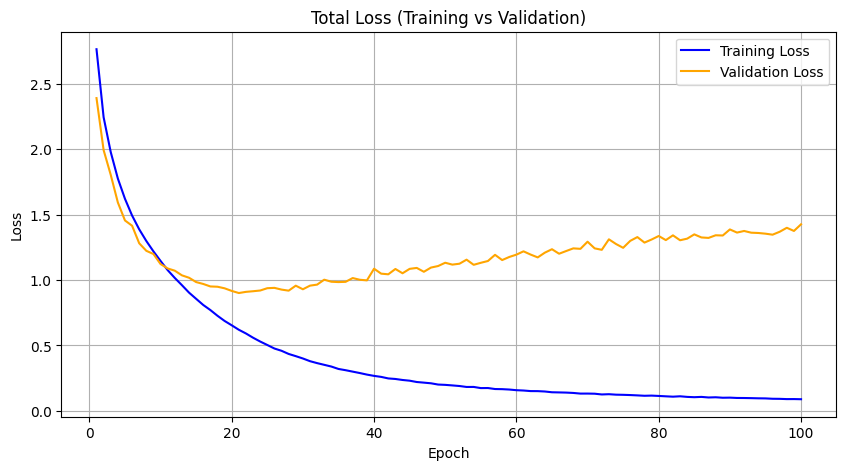

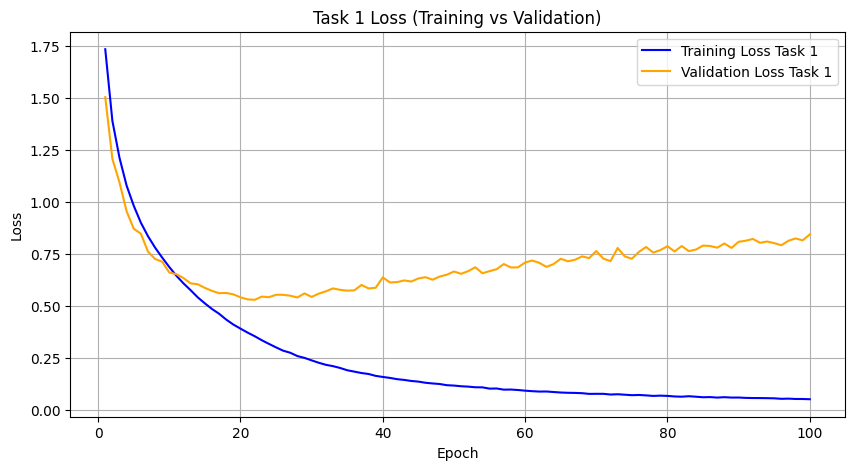

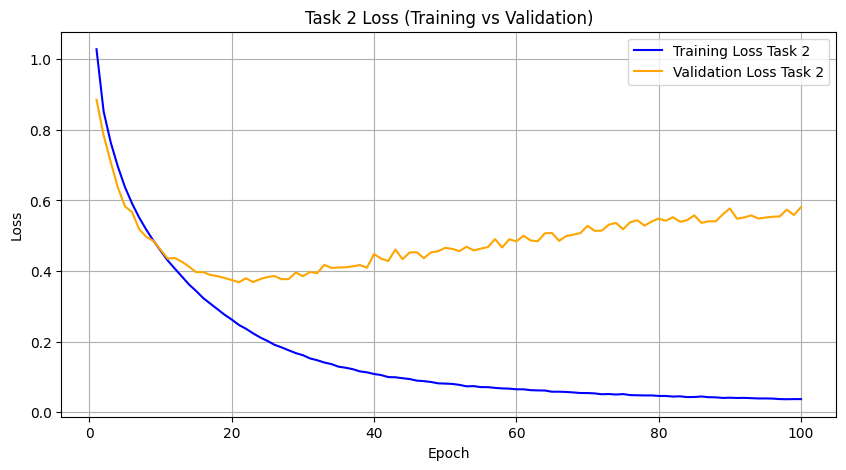

In [ ]:
# 1. Total loss
plt.figure(figsize=(10, 5))
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Train Loss Total'], label='Training Loss', color='blue')
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Valid Loss Total'], label='Validation Loss', color='orange')
plt.title('Total Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. Task 1 loss
plt.figure(figsize=(10, 5))
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Train Loss Task 1'], label='Training Loss Task 1', color='blue')
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Valid Loss Task 1'], label='Validation Loss Task 1', color='orange')
plt.title('Task 1 Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. Task 2 loss
plt.figure(figsize=(10, 5))
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Train Loss Task 2'], label='Training Loss Task 2', color='blue')
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Valid Loss Task 2'], label='Validation Loss Task 2', color='orange')
plt.title('Task 2 Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

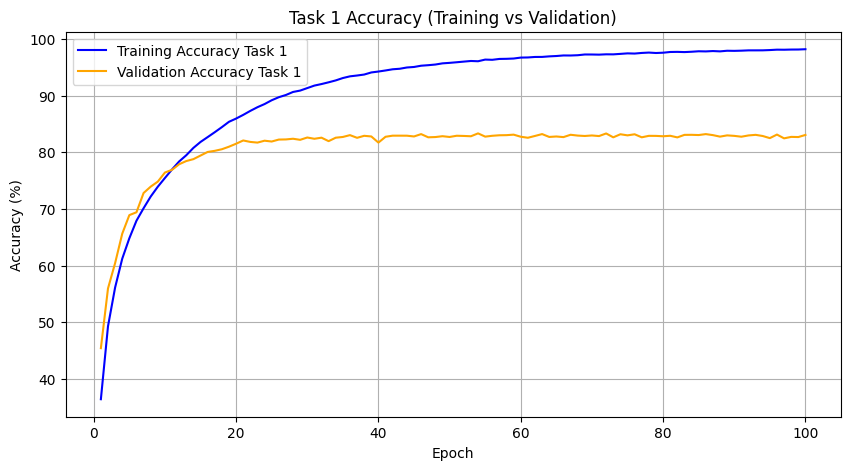

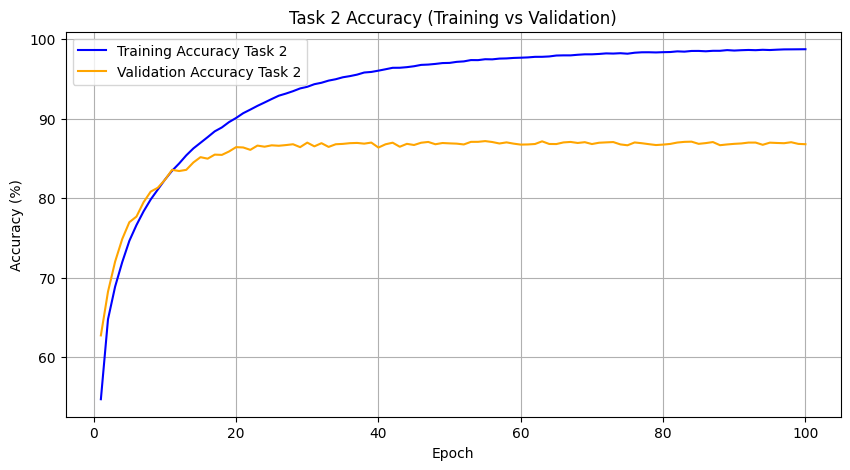

In [ ]:
# 1. Task 1 accuracy
plt.figure(figsize=(10, 5))
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Train Acc Task 1'], label='Training Accuracy Task 1', color='blue')
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Valid Acc Task 1'], label='Validation Accuracy Task 1', color='orange')
plt.title('Task 1 Accuracy (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# 2. Task 2 accuracy
plt.figure(figsize=(10, 5))
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Train Acc Task 2'], label='Training Accuracy Task 2', color='blue')
plt.plot(hs_mtl_results_df['Epoch'], hs_mtl_results_df['Valid Acc Task 2'], label='Validation Accuracy Task 2', color='orange')
plt.title('Task 2 Accuracy (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

### 8.3. Model Evaluation on Test Set

In [ ]:
# Load the best model for final evaluation
model_hard_share_mtl.load_state_dict(torch.load('best_alexnet_hard_share_mtl_model.pt', map_location=device))

test_loss_hs_mtl, test_l1_hs_mtl, test_l2_hs_mtl, test_acc1_hs_mtl, test_acc2_hs_mtl = generic_evaluate_epoch_mtl(
    model_hard_share_mtl, test_loader, criterion, device, epoch_num=None, phase="Test", model_desc="Hard Parameter Sharing MTL"
)

Test Hard Parameter Sharing MTL: 100%|██████████| 625/625 [00:08<00:00, 74.23it/s]

Test Hard Parameter Sharing MTL Total Loss: 0.9607 | L1: 0.5750, L2: 0.3857 | Acc T1: 80.88%, Acc T2: 85.53%


## 9. Training: Soft Parameter Sharing Architecture (MTL)
### Cross-Stitch Network

In [ ]:
model_cross_stitch_mtl = CrossStitchNetwork(
    output_dim_task1 = NUM_OUTPUTS_TASK1 ,
    output_dim_task2 = NUM_OUTPUTS_TASK2
).to(device)

print(f'Cross-stitch network has {humanize.intcomma(count_parameters(model_cross_stitch_mtl))} trainable parameters.')

Cross-stitch network has 15,007,394 trainable parameters.


In [ ]:
# Optimizer
optimizer_cross_stitch_mtl = optim.Adam(model_cross_stitch_mtl.parameters(), lr=0.0001)

### 9.1. Training Loop

In [ ]:
best_validation_loss_cs_mtl = float('inf')
cs_mtl_training_results_list = []

# We store the alpha values for each layer during training.
# For each cross-stitch layer, we store the alpha values as tuples (alpha_S, alpha_D).
# alpha_AA, alpha_BB are denoted by S (same-task)
# alpha_AB, alpha_BA are denoted by D (different-task)
alpha_history = {
    'pool1': [(0.5, 0.5)],
    'pool2': [(0.5, 0.5)],
    'pool3': [(0.5, 0.5)],
    'fc1': [(0.5, 0.5)],
    'fc2': [(0.5, 0.5)]
}

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss_total, train_l1, train_l2, train_acc1, train_acc2 = generic_train_epoch_mtl(
        model_cross_stitch_mtl, train_loader, optimizer_cross_stitch_mtl, criterion, device, epoch, model_desc="Soft Parameter Sharing MTL"
    )
    valid_loss_total, valid_l1, valid_l2, valid_acc1, valid_acc2 = generic_evaluate_epoch_mtl(
        model_cross_stitch_mtl, val_loader, criterion, device, epoch, phase="Validation", model_desc="Soft Parameter Sharing MTL"
    )
    if valid_loss_total < best_validation_loss_cs_mtl:
        best_validation_loss_cs_mtl = valid_loss_total
        torch.save(model_cross_stitch_mtl.state_dict(), 'best_alexnet_cross_stitch_mtl_model.pt')

    # Save the training results for the epoch
    cs_mtl_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss Total": train_loss_total, "Train Loss Task 1": train_l1,
        "Train Loss Task 2": train_l2, "Train Acc Task 1": train_acc1, "Train Acc Task 2": train_acc2,
        "Valid Loss Total": valid_loss_total, "Valid Loss Task 1": valid_l1, "Valid Loss Task 2": valid_l2,
        "Valid Acc Task 1": valid_acc1, "Valid Acc Task 2": valid_acc2,
    })

    # Store the alpha values for each cross-stitch layer
    alpha_history['pool1'].append((model_cross_stitch_mtl.cross_stitch1.stitch_matrix[0, 0].item(),
                                   model_cross_stitch_mtl.cross_stitch1.stitch_matrix[1, 0].item()))
    alpha_history['pool2'].append((model_cross_stitch_mtl.cross_stitch2.stitch_matrix[0, 0].item(),
                                   model_cross_stitch_mtl.cross_stitch2.stitch_matrix[1, 0].item()))
    alpha_history['pool3'].append((model_cross_stitch_mtl.cross_stitch3.stitch_matrix[0, 0].item(),
                                   model_cross_stitch_mtl.cross_stitch3.stitch_matrix[1, 0].item()))
    alpha_history['fc1'].append((model_cross_stitch_mtl.cross_stitch4.stitch_matrix[0, 0].item(),
                                   model_cross_stitch_mtl.cross_stitch4.stitch_matrix[1, 0].item()))
    alpha_history['fc2'].append((model_cross_stitch_mtl.cross_stitch5.stitch_matrix[0, 0].item(),
                                   model_cross_stitch_mtl.cross_stitch5.stitch_matrix[1, 0].item()))

end_time = time.time()

cs_mtl_results_df = pd.DataFrame(cs_mtl_training_results_list)

alpha_history_df = pd.DataFrame(alpha_history)

Epoch 1 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:42<00:00, 27.58it/s]


Epoch: [1] Train Soft Parameter Sharing MTL Total Loss: 2.7947 | L1: 1.7579, L2: 1.0368 | Acc T1: 35.36%, Acc T2: 54.15%


Epoch 1 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.22it/s]


Validation Epoch: [1] Soft Parameter Sharing MTL Total Loss: 2.4160 | L1: 1.5108, L2: 0.9052 | Acc T1: 45.41%, Acc T2: 62.20%


Epoch 2 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.49it/s]


Epoch: [2] Train Soft Parameter Sharing MTL Total Loss: 2.2467 | L1: 1.3956, L2: 0.8511 | Acc T1: 49.26%, Acc T2: 64.70%


Epoch 2 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.52it/s]


Validation Epoch: [2] Soft Parameter Sharing MTL Total Loss: 2.0816 | L1: 1.2809, L2: 0.8008 | Acc T1: 53.45%, Acc T2: 66.94%


Epoch 3 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.86it/s]


Epoch: [3] Train Soft Parameter Sharing MTL Total Loss: 1.9675 | L1: 1.2117, L2: 0.7558 | Acc T1: 56.08%, Acc T2: 69.31%


Epoch 3 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.54it/s]


Validation Epoch: [3] Soft Parameter Sharing MTL Total Loss: 1.8955 | L1: 1.1645, L2: 0.7310 | Acc T1: 58.13%, Acc T2: 70.03%


Epoch 4 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.72it/s]


Epoch: [4] Train Soft Parameter Sharing MTL Total Loss: 1.7635 | L1: 1.0793, L2: 0.6842 | Acc T1: 61.22%, Acc T2: 72.49%


Epoch 4 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.30it/s]


Validation Epoch: [4] Soft Parameter Sharing MTL Total Loss: 1.6929 | L1: 1.0300, L2: 0.6629 | Acc T1: 62.78%, Acc T2: 73.31%


Epoch 5 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.79it/s]


Epoch: [5] Train Soft Parameter Sharing MTL Total Loss: 1.6009 | L1: 0.9749, L2: 0.6260 | Acc T1: 65.01%, Acc T2: 75.09%


Epoch 5 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.31it/s]


Validation Epoch: [5] Soft Parameter Sharing MTL Total Loss: 1.5770 | L1: 0.9507, L2: 0.6263 | Acc T1: 65.81%, Acc T2: 75.22%


Epoch 6 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.84it/s]


Epoch: [6] Train Soft Parameter Sharing MTL Total Loss: 1.4685 | L1: 0.8900, L2: 0.5785 | Acc T1: 68.17%, Acc T2: 77.16%


Epoch 6 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.43it/s]


Validation Epoch: [6] Soft Parameter Sharing MTL Total Loss: 1.4716 | L1: 0.8856, L2: 0.5860 | Acc T1: 68.56%, Acc T2: 76.67%


Epoch 7 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.84it/s]


Epoch: [7] Train Soft Parameter Sharing MTL Total Loss: 1.3540 | L1: 0.8179, L2: 0.5361 | Acc T1: 70.82%, Acc T2: 79.01%


Epoch 7 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.14it/s]


Validation Epoch: [7] Soft Parameter Sharing MTL Total Loss: 1.4178 | L1: 0.8610, L2: 0.5568 | Acc T1: 69.23%, Acc T2: 78.23%


Epoch 8 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.39it/s]


Epoch: [8] Train Soft Parameter Sharing MTL Total Loss: 1.2557 | L1: 0.7576, L2: 0.4981 | Acc T1: 73.02%, Acc T2: 80.57%


Epoch 8 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.00it/s]


Validation Epoch: [8] Soft Parameter Sharing MTL Total Loss: 1.3634 | L1: 0.8316, L2: 0.5318 | Acc T1: 70.81%, Acc T2: 79.01%


Epoch 9 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.51it/s]


Epoch: [9] Train Soft Parameter Sharing MTL Total Loss: 1.1664 | L1: 0.7014, L2: 0.4651 | Acc T1: 75.07%, Acc T2: 81.94%


Epoch 9 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.60it/s]


Validation Epoch: [9] Soft Parameter Sharing MTL Total Loss: 1.3167 | L1: 0.7927, L2: 0.5240 | Acc T1: 71.95%, Acc T2: 79.81%


Epoch 10 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.52it/s]


Epoch: [10] Train Soft Parameter Sharing MTL Total Loss: 1.0775 | L1: 0.6449, L2: 0.4326 | Acc T1: 76.92%, Acc T2: 83.22%


Epoch 10 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 62.93it/s]


Validation Epoch: [10] Soft Parameter Sharing MTL Total Loss: 1.3045 | L1: 0.7846, L2: 0.5199 | Acc T1: 72.92%, Acc T2: 80.00%


Epoch 11 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.83it/s]


Epoch: [11] Train Soft Parameter Sharing MTL Total Loss: 1.0050 | L1: 0.6023, L2: 0.4027 | Acc T1: 78.56%, Acc T2: 84.52%


Epoch 11 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.04it/s]


Validation Epoch: [11] Soft Parameter Sharing MTL Total Loss: 1.2485 | L1: 0.7461, L2: 0.5024 | Acc T1: 74.17%, Acc T2: 80.56%


Epoch 12 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.80it/s]


Epoch: [12] Train Soft Parameter Sharing MTL Total Loss: 0.9319 | L1: 0.5570, L2: 0.3749 | Acc T1: 80.09%, Acc T2: 85.66%


Epoch 12 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.45it/s]


Validation Epoch: [12] Soft Parameter Sharing MTL Total Loss: 1.2392 | L1: 0.7451, L2: 0.4941 | Acc T1: 74.45%, Acc T2: 81.08%


Epoch 13 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:36<00:00, 29.12it/s]


Epoch: [13] Train Soft Parameter Sharing MTL Total Loss: 0.8638 | L1: 0.5150, L2: 0.3488 | Acc T1: 81.64%, Acc T2: 86.61%


Epoch 13 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.35it/s]


Validation Epoch: [13] Soft Parameter Sharing MTL Total Loss: 1.2638 | L1: 0.7623, L2: 0.5015 | Acc T1: 74.40%, Acc T2: 81.64%


Epoch 14 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:36<00:00, 29.20it/s]


Epoch: [14] Train Soft Parameter Sharing MTL Total Loss: 0.8036 | L1: 0.4794, L2: 0.3243 | Acc T1: 82.77%, Acc T2: 87.68%


Epoch 14 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.78it/s]


Validation Epoch: [14] Soft Parameter Sharing MTL Total Loss: 1.2232 | L1: 0.7324, L2: 0.4908 | Acc T1: 75.36%, Acc T2: 81.73%


Epoch 15 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.79it/s]


Epoch: [15] Train Soft Parameter Sharing MTL Total Loss: 0.7442 | L1: 0.4421, L2: 0.3021 | Acc T1: 84.13%, Acc T2: 88.56%


Epoch 15 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.89it/s]


Validation Epoch: [15] Soft Parameter Sharing MTL Total Loss: 1.2088 | L1: 0.7200, L2: 0.4888 | Acc T1: 76.19%, Acc T2: 82.16%


Epoch 16 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.79it/s]


Epoch: [16] Train Soft Parameter Sharing MTL Total Loss: 0.6928 | L1: 0.4108, L2: 0.2820 | Acc T1: 85.24%, Acc T2: 89.30%


Epoch 16 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.05it/s]


Validation Epoch: [16] Soft Parameter Sharing MTL Total Loss: 1.2766 | L1: 0.7790, L2: 0.4976 | Acc T1: 75.29%, Acc T2: 82.09%


Epoch 17 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.81it/s]


Epoch: [17] Train Soft Parameter Sharing MTL Total Loss: 0.6421 | L1: 0.3806, L2: 0.2615 | Acc T1: 86.25%, Acc T2: 90.17%


Epoch 17 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 62.72it/s]


Validation Epoch: [17] Soft Parameter Sharing MTL Total Loss: 1.2637 | L1: 0.7602, L2: 0.5034 | Acc T1: 75.89%, Acc T2: 82.86%


Epoch 18 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.57it/s]


Epoch: [18] Train Soft Parameter Sharing MTL Total Loss: 0.5985 | L1: 0.3542, L2: 0.2443 | Acc T1: 87.20%, Acc T2: 90.78%


Epoch 18 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 59.51it/s]


Validation Epoch: [18] Soft Parameter Sharing MTL Total Loss: 1.2566 | L1: 0.7520, L2: 0.5046 | Acc T1: 76.35%, Acc T2: 82.51%


Epoch 19 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:42<00:00, 27.49it/s]


Epoch: [19] Train Soft Parameter Sharing MTL Total Loss: 0.5532 | L1: 0.3272, L2: 0.2259 | Acc T1: 88.11%, Acc T2: 91.48%


Epoch 19 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 59.56it/s]


Validation Epoch: [19] Soft Parameter Sharing MTL Total Loss: 1.2906 | L1: 0.7802, L2: 0.5104 | Acc T1: 76.50%, Acc T2: 82.67%


Epoch 20 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:44<00:00, 26.83it/s]


Epoch: [20] Train Soft Parameter Sharing MTL Total Loss: 0.5178 | L1: 0.3047, L2: 0.2130 | Acc T1: 88.98%, Acc T2: 91.95%


Epoch 20 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 59.95it/s]


Validation Epoch: [20] Soft Parameter Sharing MTL Total Loss: 1.2932 | L1: 0.7685, L2: 0.5248 | Acc T1: 77.22%, Acc T2: 83.07%


Epoch 21 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:43<00:00, 27.27it/s]


Epoch: [21] Train Soft Parameter Sharing MTL Total Loss: 0.4858 | L1: 0.2852, L2: 0.2007 | Acc T1: 89.64%, Acc T2: 92.45%


Epoch 21 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 60.60it/s]


Validation Epoch: [21] Soft Parameter Sharing MTL Total Loss: 1.3231 | L1: 0.7897, L2: 0.5334 | Acc T1: 76.67%, Acc T2: 82.75%


Epoch 22 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.68it/s]


Epoch: [22] Train Soft Parameter Sharing MTL Total Loss: 0.4517 | L1: 0.2656, L2: 0.1861 | Acc T1: 90.41%, Acc T2: 93.00%


Epoch 22 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 60.01it/s]


Validation Epoch: [22] Soft Parameter Sharing MTL Total Loss: 1.3327 | L1: 0.7929, L2: 0.5397 | Acc T1: 76.73%, Acc T2: 83.03%


Epoch 23 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.39it/s]


Epoch: [23] Train Soft Parameter Sharing MTL Total Loss: 0.4228 | L1: 0.2479, L2: 0.1749 | Acc T1: 90.98%, Acc T2: 93.42%


Epoch 23 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.31it/s]


Validation Epoch: [23] Soft Parameter Sharing MTL Total Loss: 1.3928 | L1: 0.8278, L2: 0.5649 | Acc T1: 77.25%, Acc T2: 82.90%


Epoch 24 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.37it/s]


Epoch: [24] Train Soft Parameter Sharing MTL Total Loss: 0.3969 | L1: 0.2329, L2: 0.1640 | Acc T1: 91.50%, Acc T2: 93.91%


Epoch 24 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.14it/s]


Validation Epoch: [24] Soft Parameter Sharing MTL Total Loss: 1.3772 | L1: 0.8239, L2: 0.5534 | Acc T1: 77.33%, Acc T2: 83.36%


Epoch 25 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.67it/s]


Epoch: [25] Train Soft Parameter Sharing MTL Total Loss: 0.3720 | L1: 0.2175, L2: 0.1545 | Acc T1: 92.11%, Acc T2: 94.17%


Epoch 25 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 61.90it/s]


Validation Epoch: [25] Soft Parameter Sharing MTL Total Loss: 1.4291 | L1: 0.8701, L2: 0.5591 | Acc T1: 76.78%, Acc T2: 83.17%


Epoch 26 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.13it/s]


Epoch: [26] Train Soft Parameter Sharing MTL Total Loss: 0.3515 | L1: 0.2066, L2: 0.1449 | Acc T1: 92.55%, Acc T2: 94.59%


Epoch 26 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.28it/s]


Validation Epoch: [26] Soft Parameter Sharing MTL Total Loss: 1.4140 | L1: 0.8389, L2: 0.5750 | Acc T1: 77.39%, Acc T2: 83.03%


Epoch 27 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:40<00:00, 27.97it/s]


Epoch: [27] Train Soft Parameter Sharing MTL Total Loss: 0.3328 | L1: 0.1954, L2: 0.1374 | Acc T1: 92.92%, Acc T2: 94.87%


Epoch 27 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.64it/s]


Validation Epoch: [27] Soft Parameter Sharing MTL Total Loss: 1.4396 | L1: 0.8609, L2: 0.5787 | Acc T1: 77.46%, Acc T2: 83.07%


Epoch 28 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.20it/s]


Epoch: [28] Train Soft Parameter Sharing MTL Total Loss: 0.3119 | L1: 0.1830, L2: 0.1288 | Acc T1: 93.39%, Acc T2: 95.19%


Epoch 28 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 58.73it/s]


Validation Epoch: [28] Soft Parameter Sharing MTL Total Loss: 1.4947 | L1: 0.8953, L2: 0.5994 | Acc T1: 77.69%, Acc T2: 83.16%


Epoch 29 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:42<00:00, 27.47it/s]


Epoch: [29] Train Soft Parameter Sharing MTL Total Loss: 0.2979 | L1: 0.1736, L2: 0.1243 | Acc T1: 93.82%, Acc T2: 95.40%


Epoch 29 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.01it/s]


Validation Epoch: [29] Soft Parameter Sharing MTL Total Loss: 1.4917 | L1: 0.8960, L2: 0.5957 | Acc T1: 77.23%, Acc T2: 83.25%


Epoch 30 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.71it/s]


Epoch: [30] Train Soft Parameter Sharing MTL Total Loss: 0.2844 | L1: 0.1654, L2: 0.1190 | Acc T1: 94.00%, Acc T2: 95.66%


Epoch 30 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.44it/s]


Validation Epoch: [30] Soft Parameter Sharing MTL Total Loss: 1.4869 | L1: 0.9032, L2: 0.5837 | Acc T1: 77.14%, Acc T2: 83.70%


Epoch 31 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.17it/s]


Epoch: [31] Train Soft Parameter Sharing MTL Total Loss: 0.2690 | L1: 0.1570, L2: 0.1120 | Acc T1: 94.40%, Acc T2: 95.92%


Epoch 31 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.22it/s]


Validation Epoch: [31] Soft Parameter Sharing MTL Total Loss: 1.4850 | L1: 0.8854, L2: 0.5996 | Acc T1: 77.75%, Acc T2: 83.64%


Epoch 32 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:42<00:00, 27.55it/s]


Epoch: [32] Train Soft Parameter Sharing MTL Total Loss: 0.2544 | L1: 0.1488, L2: 0.1056 | Acc T1: 94.67%, Acc T2: 96.09%


Epoch 32 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.48it/s]


Validation Epoch: [32] Soft Parameter Sharing MTL Total Loss: 1.5675 | L1: 0.9314, L2: 0.6361 | Acc T1: 77.32%, Acc T2: 83.30%


Epoch 33 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:40<00:00, 28.06it/s]


Epoch: [33] Train Soft Parameter Sharing MTL Total Loss: 0.2463 | L1: 0.1437, L2: 0.1026 | Acc T1: 94.84%, Acc T2: 96.18%


Epoch 33 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.27it/s]


Validation Epoch: [33] Soft Parameter Sharing MTL Total Loss: 1.5471 | L1: 0.9076, L2: 0.6394 | Acc T1: 77.92%, Acc T2: 83.30%


Epoch 34 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:39<00:00, 28.19it/s]


Epoch: [34] Train Soft Parameter Sharing MTL Total Loss: 0.2351 | L1: 0.1373, L2: 0.0978 | Acc T1: 95.13%, Acc T2: 96.42%


Epoch 34 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 61.25it/s]


Validation Epoch: [34] Soft Parameter Sharing MTL Total Loss: 1.5428 | L1: 0.9299, L2: 0.6129 | Acc T1: 77.77%, Acc T2: 83.79%


Epoch 35 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:43<00:00, 27.18it/s]


Epoch: [35] Train Soft Parameter Sharing MTL Total Loss: 0.2279 | L1: 0.1329, L2: 0.0950 | Acc T1: 95.16%, Acc T2: 96.51%


Epoch 35 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.69it/s]


Validation Epoch: [35] Soft Parameter Sharing MTL Total Loss: 1.5038 | L1: 0.8945, L2: 0.6094 | Acc T1: 78.16%, Acc T2: 84.11%


Epoch 36 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.69it/s]


Epoch: [36] Train Soft Parameter Sharing MTL Total Loss: 0.2146 | L1: 0.1255, L2: 0.0890 | Acc T1: 95.56%, Acc T2: 96.76%


Epoch 36 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.98it/s]


Validation Epoch: [36] Soft Parameter Sharing MTL Total Loss: 1.6925 | L1: 0.9923, L2: 0.7002 | Acc T1: 77.61%, Acc T2: 82.97%


Epoch 37 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.79it/s]


Epoch: [37] Train Soft Parameter Sharing MTL Total Loss: 0.2081 | L1: 0.1218, L2: 0.0863 | Acc T1: 95.69%, Acc T2: 96.84%


Epoch 37 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.76it/s]


Validation Epoch: [37] Soft Parameter Sharing MTL Total Loss: 1.6576 | L1: 0.9928, L2: 0.6648 | Acc T1: 78.74%, Acc T2: 83.75%


Epoch 38 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:41<00:00, 27.83it/s]


Epoch: [38] Train Soft Parameter Sharing MTL Total Loss: 0.1979 | L1: 0.1151, L2: 0.0829 | Acc T1: 95.93%, Acc T2: 97.00%


Epoch 38 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 61.31it/s]


Validation Epoch: [38] Soft Parameter Sharing MTL Total Loss: 1.6136 | L1: 0.9586, L2: 0.6549 | Acc T1: 78.53%, Acc T2: 84.11%


Epoch 39 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:42<00:00, 27.36it/s]


Epoch: [39] Train Soft Parameter Sharing MTL Total Loss: 0.1929 | L1: 0.1129, L2: 0.0800 | Acc T1: 96.02%, Acc T2: 97.06%


Epoch 39 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 61.64it/s]


Validation Epoch: [39] Soft Parameter Sharing MTL Total Loss: 1.6191 | L1: 0.9559, L2: 0.6631 | Acc T1: 78.42%, Acc T2: 83.78%


Epoch 40 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.43it/s]


Epoch: [40] Train Soft Parameter Sharing MTL Total Loss: 0.1849 | L1: 0.1095, L2: 0.0754 | Acc T1: 96.11%, Acc T2: 97.26%


Epoch 40 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.16it/s]


Validation Epoch: [40] Soft Parameter Sharing MTL Total Loss: 1.6866 | L1: 1.0059, L2: 0.6807 | Acc T1: 77.88%, Acc T2: 83.50%


Epoch 41 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.72it/s]


Epoch: [41] Train Soft Parameter Sharing MTL Total Loss: 0.1769 | L1: 0.1036, L2: 0.0733 | Acc T1: 96.34%, Acc T2: 97.36%


Epoch 41 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.21it/s]


Validation Epoch: [41] Soft Parameter Sharing MTL Total Loss: 1.6737 | L1: 1.0078, L2: 0.6659 | Acc T1: 77.81%, Acc T2: 83.80%


Epoch 42 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.63it/s]


Epoch: [42] Train Soft Parameter Sharing MTL Total Loss: 0.1715 | L1: 0.0997, L2: 0.0718 | Acc T1: 96.49%, Acc T2: 97.45%


Epoch 42 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.30it/s]


Validation Epoch: [42] Soft Parameter Sharing MTL Total Loss: 1.6965 | L1: 1.0062, L2: 0.6903 | Acc T1: 78.30%, Acc T2: 83.83%


Epoch 43 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:40<00:00, 28.05it/s]


Epoch: [43] Train Soft Parameter Sharing MTL Total Loss: 0.1679 | L1: 0.0989, L2: 0.0690 | Acc T1: 96.49%, Acc T2: 97.48%


Epoch 43 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 61.34it/s]


Validation Epoch: [43] Soft Parameter Sharing MTL Total Loss: 1.7139 | L1: 1.0103, L2: 0.7037 | Acc T1: 78.23%, Acc T2: 83.69%


Epoch 44 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:40<00:00, 27.89it/s]


Epoch: [44] Train Soft Parameter Sharing MTL Total Loss: 0.1618 | L1: 0.0945, L2: 0.0673 | Acc T1: 96.65%, Acc T2: 97.59%


Epoch 44 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 61.63it/s]


Validation Epoch: [44] Soft Parameter Sharing MTL Total Loss: 1.6950 | L1: 1.0042, L2: 0.6907 | Acc T1: 78.61%, Acc T2: 83.94%


Epoch 45 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:42<00:00, 27.40it/s]


Epoch: [45] Train Soft Parameter Sharing MTL Total Loss: 0.1588 | L1: 0.0928, L2: 0.0660 | Acc T1: 96.73%, Acc T2: 97.62%


Epoch 45 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 59.38it/s]


Validation Epoch: [45] Soft Parameter Sharing MTL Total Loss: 1.6835 | L1: 0.9940, L2: 0.6894 | Acc T1: 78.50%, Acc T2: 84.12%


Epoch 46 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:37<00:00, 28.89it/s]


Epoch: [46] Train Soft Parameter Sharing MTL Total Loss: 0.1515 | L1: 0.0889, L2: 0.0627 | Acc T1: 96.86%, Acc T2: 97.77%


Epoch 46 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.49it/s]


Validation Epoch: [46] Soft Parameter Sharing MTL Total Loss: 1.6784 | L1: 0.9805, L2: 0.6980 | Acc T1: 78.80%, Acc T2: 84.00%


Epoch 47 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:34<00:00, 29.63it/s]


Epoch: [47] Train Soft Parameter Sharing MTL Total Loss: 0.1485 | L1: 0.0867, L2: 0.0618 | Acc T1: 96.93%, Acc T2: 97.78%


Epoch 47 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.68it/s]


Validation Epoch: [47] Soft Parameter Sharing MTL Total Loss: 1.7019 | L1: 1.0120, L2: 0.6898 | Acc T1: 78.58%, Acc T2: 84.12%


Epoch 48 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:36<00:00, 29.06it/s]


Epoch: [48] Train Soft Parameter Sharing MTL Total Loss: 0.1431 | L1: 0.0849, L2: 0.0583 | Acc T1: 97.00%, Acc T2: 97.94%


Epoch 48 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 57.97it/s]


Validation Epoch: [48] Soft Parameter Sharing MTL Total Loss: 1.7250 | L1: 1.0437, L2: 0.6813 | Acc T1: 77.92%, Acc T2: 83.84%


Epoch 49 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:43<00:00, 27.17it/s]


Epoch: [49] Train Soft Parameter Sharing MTL Total Loss: 0.1400 | L1: 0.0816, L2: 0.0584 | Acc T1: 97.15%, Acc T2: 97.91%


Epoch 49 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.35it/s]


Validation Epoch: [49] Soft Parameter Sharing MTL Total Loss: 1.6958 | L1: 1.0041, L2: 0.6916 | Acc T1: 79.05%, Acc T2: 84.08%


Epoch 50 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.43it/s]


Epoch: [50] Train Soft Parameter Sharing MTL Total Loss: 0.1361 | L1: 0.0804, L2: 0.0557 | Acc T1: 97.16%, Acc T2: 98.06%


Epoch 50 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.55it/s]


Validation Epoch: [50] Soft Parameter Sharing MTL Total Loss: 1.7674 | L1: 1.0397, L2: 0.7277 | Acc T1: 78.70%, Acc T2: 83.73%


Epoch 51 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.43it/s]


Epoch: [51] Train Soft Parameter Sharing MTL Total Loss: 0.1325 | L1: 0.0770, L2: 0.0554 | Acc T1: 97.28%, Acc T2: 98.04%


Epoch 51 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.04it/s]


Validation Epoch: [51] Soft Parameter Sharing MTL Total Loss: 1.7099 | L1: 1.0268, L2: 0.6831 | Acc T1: 78.83%, Acc T2: 84.48%


Epoch 52 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:38<00:00, 28.49it/s]


Epoch: [52] Train Soft Parameter Sharing MTL Total Loss: 0.1291 | L1: 0.0749, L2: 0.0542 | Acc T1: 97.36%, Acc T2: 98.08%


Epoch 52 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:05<00:00, 62.26it/s]


Validation Epoch: [52] Soft Parameter Sharing MTL Total Loss: 1.8146 | L1: 1.0603, L2: 0.7543 | Acc T1: 78.84%, Acc T2: 83.94%


Epoch 53 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:36<00:00, 29.30it/s]


Epoch: [53] Train Soft Parameter Sharing MTL Total Loss: 0.1228 | L1: 0.0719, L2: 0.0509 | Acc T1: 97.48%, Acc T2: 98.21%


Epoch 53 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.70it/s]


Validation Epoch: [53] Soft Parameter Sharing MTL Total Loss: 1.7907 | L1: 1.0729, L2: 0.7178 | Acc T1: 78.86%, Acc T2: 84.17%


Epoch 54 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.41it/s]


Epoch: [54] Train Soft Parameter Sharing MTL Total Loss: 0.1223 | L1: 0.0708, L2: 0.0515 | Acc T1: 97.54%, Acc T2: 98.21%


Epoch 54 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.92it/s]


Validation Epoch: [54] Soft Parameter Sharing MTL Total Loss: 1.7936 | L1: 1.0689, L2: 0.7247 | Acc T1: 78.73%, Acc T2: 84.33%


Epoch 55 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.43it/s]


Epoch: [55] Train Soft Parameter Sharing MTL Total Loss: 0.1196 | L1: 0.0700, L2: 0.0496 | Acc T1: 97.57%, Acc T2: 98.24%


Epoch 55 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.30it/s]


Validation Epoch: [55] Soft Parameter Sharing MTL Total Loss: 1.7490 | L1: 1.0343, L2: 0.7146 | Acc T1: 79.21%, Acc T2: 84.06%


Epoch 56 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.44it/s]


Epoch: [56] Train Soft Parameter Sharing MTL Total Loss: 0.1173 | L1: 0.0694, L2: 0.0478 | Acc T1: 97.63%, Acc T2: 98.32%


Epoch 56 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.35it/s]


Validation Epoch: [56] Soft Parameter Sharing MTL Total Loss: 1.8113 | L1: 1.0671, L2: 0.7442 | Acc T1: 78.77%, Acc T2: 83.86%


Epoch 57 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.40it/s]


Epoch: [57] Train Soft Parameter Sharing MTL Total Loss: 0.1133 | L1: 0.0666, L2: 0.0468 | Acc T1: 97.72%, Acc T2: 98.34%


Epoch 57 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.95it/s]


Validation Epoch: [57] Soft Parameter Sharing MTL Total Loss: 1.7564 | L1: 1.0457, L2: 0.7107 | Acc T1: 79.05%, Acc T2: 84.42%


Epoch 58 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.36it/s]


Epoch: [58] Train Soft Parameter Sharing MTL Total Loss: 0.1096 | L1: 0.0649, L2: 0.0447 | Acc T1: 97.77%, Acc T2: 98.40%


Epoch 58 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.06it/s]


Validation Epoch: [58] Soft Parameter Sharing MTL Total Loss: 1.8345 | L1: 1.0833, L2: 0.7512 | Acc T1: 78.17%, Acc T2: 83.59%


Epoch 59 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:36<00:00, 29.18it/s]


Epoch: [59] Train Soft Parameter Sharing MTL Total Loss: 0.1091 | L1: 0.0646, L2: 0.0445 | Acc T1: 97.76%, Acc T2: 98.45%


Epoch 59 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.59it/s]


Validation Epoch: [59] Soft Parameter Sharing MTL Total Loss: 1.8105 | L1: 1.0657, L2: 0.7447 | Acc T1: 78.91%, Acc T2: 84.25%


Epoch 60 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.36it/s]


Epoch: [60] Train Soft Parameter Sharing MTL Total Loss: 0.1059 | L1: 0.0620, L2: 0.0439 | Acc T1: 97.85%, Acc T2: 98.44%


Epoch 60 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.57it/s]


Validation Epoch: [60] Soft Parameter Sharing MTL Total Loss: 1.8121 | L1: 1.0747, L2: 0.7374 | Acc T1: 78.95%, Acc T2: 84.36%


Epoch 61 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [61] Train Soft Parameter Sharing MTL Total Loss: 0.1037 | L1: 0.0621, L2: 0.0416 | Acc T1: 97.87%, Acc T2: 98.54%


Epoch 61 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.68it/s]


Validation Epoch: [61] Soft Parameter Sharing MTL Total Loss: 1.8549 | L1: 1.0822, L2: 0.7728 | Acc T1: 79.39%, Acc T2: 84.20%


Epoch 62 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [62] Train Soft Parameter Sharing MTL Total Loss: 0.1013 | L1: 0.0595, L2: 0.0418 | Acc T1: 97.95%, Acc T2: 98.50%


Epoch 62 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.30it/s]


Validation Epoch: [62] Soft Parameter Sharing MTL Total Loss: 1.8555 | L1: 1.0934, L2: 0.7621 | Acc T1: 78.99%, Acc T2: 83.98%


Epoch 63 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [63] Train Soft Parameter Sharing MTL Total Loss: 0.1010 | L1: 0.0594, L2: 0.0416 | Acc T1: 97.96%, Acc T2: 98.53%


Epoch 63 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.01it/s]


Validation Epoch: [63] Soft Parameter Sharing MTL Total Loss: 1.8368 | L1: 1.0755, L2: 0.7613 | Acc T1: 79.05%, Acc T2: 84.25%


Epoch 64 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [64] Train Soft Parameter Sharing MTL Total Loss: 0.0973 | L1: 0.0574, L2: 0.0399 | Acc T1: 98.00%, Acc T2: 98.54%


Epoch 64 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.62it/s]


Validation Epoch: [64] Soft Parameter Sharing MTL Total Loss: 1.8340 | L1: 1.0883, L2: 0.7457 | Acc T1: 79.28%, Acc T2: 84.48%


Epoch 65 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [65] Train Soft Parameter Sharing MTL Total Loss: 0.0978 | L1: 0.0575, L2: 0.0403 | Acc T1: 97.97%, Acc T2: 98.59%


Epoch 65 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.86it/s]


Validation Epoch: [65] Soft Parameter Sharing MTL Total Loss: 1.8800 | L1: 1.0833, L2: 0.7967 | Acc T1: 79.31%, Acc T2: 83.68%


Epoch 66 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.46it/s]


Epoch: [66] Train Soft Parameter Sharing MTL Total Loss: 0.0929 | L1: 0.0547, L2: 0.0382 | Acc T1: 98.07%, Acc T2: 98.65%


Epoch 66 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.17it/s]


Validation Epoch: [66] Soft Parameter Sharing MTL Total Loss: 1.9051 | L1: 1.1485, L2: 0.7566 | Acc T1: 79.00%, Acc T2: 84.35%


Epoch 67 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [67] Train Soft Parameter Sharing MTL Total Loss: 0.0947 | L1: 0.0560, L2: 0.0387 | Acc T1: 98.09%, Acc T2: 98.66%


Epoch 67 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 63.71it/s]


Validation Epoch: [67] Soft Parameter Sharing MTL Total Loss: 1.8161 | L1: 1.0733, L2: 0.7428 | Acc T1: 79.62%, Acc T2: 84.47%


Epoch 68 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [68] Train Soft Parameter Sharing MTL Total Loss: 0.0890 | L1: 0.0519, L2: 0.0371 | Acc T1: 98.21%, Acc T2: 98.70%


Epoch 68 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.64it/s]


Validation Epoch: [68] Soft Parameter Sharing MTL Total Loss: 1.8290 | L1: 1.0842, L2: 0.7448 | Acc T1: 79.67%, Acc T2: 84.64%


Epoch 69 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [69] Train Soft Parameter Sharing MTL Total Loss: 0.0902 | L1: 0.0537, L2: 0.0365 | Acc T1: 98.17%, Acc T2: 98.74%


Epoch 69 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.22it/s]


Validation Epoch: [69] Soft Parameter Sharing MTL Total Loss: 1.8394 | L1: 1.1011, L2: 0.7383 | Acc T1: 78.97%, Acc T2: 84.47%


Epoch 70 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [70] Train Soft Parameter Sharing MTL Total Loss: 0.0867 | L1: 0.0516, L2: 0.0351 | Acc T1: 98.24%, Acc T2: 98.77%


Epoch 70 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.45it/s]


Validation Epoch: [70] Soft Parameter Sharing MTL Total Loss: 1.8439 | L1: 1.0837, L2: 0.7602 | Acc T1: 79.00%, Acc T2: 84.47%


Epoch 71 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [71] Train Soft Parameter Sharing MTL Total Loss: 0.0859 | L1: 0.0513, L2: 0.0346 | Acc T1: 98.27%, Acc T2: 98.81%


Epoch 71 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.48it/s]


Validation Epoch: [71] Soft Parameter Sharing MTL Total Loss: 1.8887 | L1: 1.1126, L2: 0.7761 | Acc T1: 79.00%, Acc T2: 84.22%


Epoch 72 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [72] Train Soft Parameter Sharing MTL Total Loss: 0.0845 | L1: 0.0492, L2: 0.0353 | Acc T1: 98.32%, Acc T2: 98.77%


Epoch 72 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.93it/s]


Validation Epoch: [72] Soft Parameter Sharing MTL Total Loss: 1.8569 | L1: 1.1028, L2: 0.7541 | Acc T1: 79.36%, Acc T2: 84.45%


Epoch 73 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [73] Train Soft Parameter Sharing MTL Total Loss: 0.0824 | L1: 0.0482, L2: 0.0342 | Acc T1: 98.35%, Acc T2: 98.82%


Epoch 73 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.36it/s]


Validation Epoch: [73] Soft Parameter Sharing MTL Total Loss: 1.8525 | L1: 1.0767, L2: 0.7758 | Acc T1: 79.22%, Acc T2: 83.98%


Epoch 74 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [74] Train Soft Parameter Sharing MTL Total Loss: 0.0814 | L1: 0.0490, L2: 0.0325 | Acc T1: 98.31%, Acc T2: 98.86%


Epoch 74 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.54it/s]


Validation Epoch: [74] Soft Parameter Sharing MTL Total Loss: 1.8803 | L1: 1.1018, L2: 0.7784 | Acc T1: 79.25%, Acc T2: 84.45%


Epoch 75 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [75] Train Soft Parameter Sharing MTL Total Loss: 0.0801 | L1: 0.0473, L2: 0.0328 | Acc T1: 98.40%, Acc T2: 98.86%


Epoch 75 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.20it/s]


Validation Epoch: [75] Soft Parameter Sharing MTL Total Loss: 1.9130 | L1: 1.1193, L2: 0.7936 | Acc T1: 79.67%, Acc T2: 84.40%


Epoch 76 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [76] Train Soft Parameter Sharing MTL Total Loss: 0.0789 | L1: 0.0468, L2: 0.0321 | Acc T1: 98.41%, Acc T2: 98.89%


Epoch 76 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.52it/s]


Validation Epoch: [76] Soft Parameter Sharing MTL Total Loss: 1.9367 | L1: 1.1321, L2: 0.8047 | Acc T1: 78.72%, Acc T2: 84.24%


Epoch 77 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [77] Train Soft Parameter Sharing MTL Total Loss: 0.0770 | L1: 0.0458, L2: 0.0312 | Acc T1: 98.45%, Acc T2: 98.91%


Epoch 77 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.25it/s]


Validation Epoch: [77] Soft Parameter Sharing MTL Total Loss: 1.9428 | L1: 1.1372, L2: 0.8056 | Acc T1: 79.69%, Acc T2: 84.58%


Epoch 78 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [78] Train Soft Parameter Sharing MTL Total Loss: 0.0755 | L1: 0.0452, L2: 0.0304 | Acc T1: 98.47%, Acc T2: 98.93%


Epoch 78 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.96it/s]


Validation Epoch: [78] Soft Parameter Sharing MTL Total Loss: 1.9253 | L1: 1.1409, L2: 0.7843 | Acc T1: 79.20%, Acc T2: 84.40%


Epoch 79 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [79] Train Soft Parameter Sharing MTL Total Loss: 0.0759 | L1: 0.0447, L2: 0.0312 | Acc T1: 98.49%, Acc T2: 98.89%


Epoch 79 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.57it/s]


Validation Epoch: [79] Soft Parameter Sharing MTL Total Loss: 1.8519 | L1: 1.0955, L2: 0.7564 | Acc T1: 79.22%, Acc T2: 84.38%


Epoch 80 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [80] Train Soft Parameter Sharing MTL Total Loss: 0.0752 | L1: 0.0446, L2: 0.0306 | Acc T1: 98.47%, Acc T2: 98.94%


Epoch 80 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.13it/s]


Validation Epoch: [80] Soft Parameter Sharing MTL Total Loss: 1.9059 | L1: 1.1281, L2: 0.7778 | Acc T1: 79.17%, Acc T2: 84.46%


Epoch 81 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [81] Train Soft Parameter Sharing MTL Total Loss: 0.0718 | L1: 0.0430, L2: 0.0288 | Acc T1: 98.56%, Acc T2: 99.00%


Epoch 81 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.94it/s]


Validation Epoch: [81] Soft Parameter Sharing MTL Total Loss: 1.9138 | L1: 1.1247, L2: 0.7891 | Acc T1: 79.84%, Acc T2: 84.94%


Epoch 82 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [82] Train Soft Parameter Sharing MTL Total Loss: 0.0703 | L1: 0.0408, L2: 0.0294 | Acc T1: 98.60%, Acc T2: 98.97%


Epoch 82 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.10it/s]


Validation Epoch: [82] Soft Parameter Sharing MTL Total Loss: 1.9529 | L1: 1.1516, L2: 0.8014 | Acc T1: 79.64%, Acc T2: 84.61%


Epoch 83 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [83] Train Soft Parameter Sharing MTL Total Loss: 0.0700 | L1: 0.0409, L2: 0.0291 | Acc T1: 98.62%, Acc T2: 99.02%


Epoch 83 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.48it/s]


Validation Epoch: [83] Soft Parameter Sharing MTL Total Loss: 1.8865 | L1: 1.1311, L2: 0.7554 | Acc T1: 79.53%, Acc T2: 84.42%


Epoch 84 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.45it/s]


Epoch: [84] Train Soft Parameter Sharing MTL Total Loss: 0.0684 | L1: 0.0403, L2: 0.0281 | Acc T1: 98.61%, Acc T2: 99.02%


Epoch 84 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.05it/s]


Validation Epoch: [84] Soft Parameter Sharing MTL Total Loss: 1.9737 | L1: 1.1815, L2: 0.7922 | Acc T1: 79.29%, Acc T2: 84.41%


Epoch 85 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.45it/s]


Epoch: [85] Train Soft Parameter Sharing MTL Total Loss: 0.0682 | L1: 0.0415, L2: 0.0267 | Acc T1: 98.62%, Acc T2: 99.07%


Epoch 85 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.43it/s]


Validation Epoch: [85] Soft Parameter Sharing MTL Total Loss: 1.9324 | L1: 1.1383, L2: 0.7941 | Acc T1: 79.56%, Acc T2: 84.57%


Epoch 86 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [86] Train Soft Parameter Sharing MTL Total Loss: 0.0661 | L1: 0.0389, L2: 0.0272 | Acc T1: 98.68%, Acc T2: 99.05%


Epoch 86 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.78it/s]


Validation Epoch: [86] Soft Parameter Sharing MTL Total Loss: 2.0069 | L1: 1.1759, L2: 0.8311 | Acc T1: 79.11%, Acc T2: 84.33%


Epoch 87 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [87] Train Soft Parameter Sharing MTL Total Loss: 0.0670 | L1: 0.0401, L2: 0.0269 | Acc T1: 98.62%, Acc T2: 99.05%


Epoch 87 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.07it/s]


Validation Epoch: [87] Soft Parameter Sharing MTL Total Loss: 1.8914 | L1: 1.0968, L2: 0.7945 | Acc T1: 79.81%, Acc T2: 84.41%


Epoch 88 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [88] Train Soft Parameter Sharing MTL Total Loss: 0.0659 | L1: 0.0394, L2: 0.0266 | Acc T1: 98.66%, Acc T2: 99.06%


Epoch 88 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.84it/s]


Validation Epoch: [88] Soft Parameter Sharing MTL Total Loss: 1.8960 | L1: 1.1105, L2: 0.7855 | Acc T1: 79.58%, Acc T2: 84.69%


Epoch 89 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [89] Train Soft Parameter Sharing MTL Total Loss: 0.0639 | L1: 0.0377, L2: 0.0262 | Acc T1: 98.70%, Acc T2: 99.08%


Epoch 89 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.48it/s]


Validation Epoch: [89] Soft Parameter Sharing MTL Total Loss: 1.8932 | L1: 1.0994, L2: 0.7939 | Acc T1: 79.91%, Acc T2: 84.62%


Epoch 90 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.41it/s]


Epoch: [90] Train Soft Parameter Sharing MTL Total Loss: 0.0647 | L1: 0.0387, L2: 0.0260 | Acc T1: 98.67%, Acc T2: 99.09%


Epoch 90 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.71it/s]


Validation Epoch: [90] Soft Parameter Sharing MTL Total Loss: 1.9955 | L1: 1.1696, L2: 0.8259 | Acc T1: 79.53%, Acc T2: 84.47%


Epoch 91 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [91] Train Soft Parameter Sharing MTL Total Loss: 0.0617 | L1: 0.0362, L2: 0.0255 | Acc T1: 98.78%, Acc T2: 99.13%


Epoch 91 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.68it/s]


Validation Epoch: [91] Soft Parameter Sharing MTL Total Loss: 1.9277 | L1: 1.1256, L2: 0.8021 | Acc T1: 79.61%, Acc T2: 84.56%


Epoch 92 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [92] Train Soft Parameter Sharing MTL Total Loss: 0.0637 | L1: 0.0371, L2: 0.0266 | Acc T1: 98.75%, Acc T2: 99.07%


Epoch 92 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.77it/s]


Validation Epoch: [92] Soft Parameter Sharing MTL Total Loss: 1.9158 | L1: 1.1400, L2: 0.7757 | Acc T1: 79.56%, Acc T2: 84.90%


Epoch 93 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [93] Train Soft Parameter Sharing MTL Total Loss: 0.0578 | L1: 0.0344, L2: 0.0234 | Acc T1: 98.83%, Acc T2: 99.18%


Epoch 93 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.81it/s]


Validation Epoch: [93] Soft Parameter Sharing MTL Total Loss: 2.0382 | L1: 1.2106, L2: 0.8276 | Acc T1: 79.14%, Acc T2: 84.58%


Epoch 94 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.47it/s]


Epoch: [94] Train Soft Parameter Sharing MTL Total Loss: 0.0602 | L1: 0.0361, L2: 0.0242 | Acc T1: 98.80%, Acc T2: 99.15%


Epoch 94 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.53it/s]


Validation Epoch: [94] Soft Parameter Sharing MTL Total Loss: 1.9679 | L1: 1.1687, L2: 0.7992 | Acc T1: 80.16%, Acc T2: 84.58%


Epoch 95 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [95] Train Soft Parameter Sharing MTL Total Loss: 0.0598 | L1: 0.0355, L2: 0.0243 | Acc T1: 98.81%, Acc T2: 99.18%


Epoch 95 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.35it/s]


Validation Epoch: [95] Soft Parameter Sharing MTL Total Loss: 2.0089 | L1: 1.1976, L2: 0.8113 | Acc T1: 79.44%, Acc T2: 84.86%


Epoch 96 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [96] Train Soft Parameter Sharing MTL Total Loss: 0.0582 | L1: 0.0342, L2: 0.0240 | Acc T1: 98.85%, Acc T2: 99.19%


Epoch 96 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.59it/s]


Validation Epoch: [96] Soft Parameter Sharing MTL Total Loss: 1.9208 | L1: 1.1261, L2: 0.7947 | Acc T1: 80.14%, Acc T2: 84.72%


Epoch 97 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.49it/s]


Epoch: [97] Train Soft Parameter Sharing MTL Total Loss: 0.0574 | L1: 0.0344, L2: 0.0230 | Acc T1: 98.85%, Acc T2: 99.21%


Epoch 97 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.79it/s]


Validation Epoch: [97] Soft Parameter Sharing MTL Total Loss: 1.9395 | L1: 1.1342, L2: 0.8053 | Acc T1: 79.55%, Acc T2: 84.80%


Epoch 98 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.48it/s]


Epoch: [98] Train Soft Parameter Sharing MTL Total Loss: 0.0574 | L1: 0.0332, L2: 0.0242 | Acc T1: 98.86%, Acc T2: 99.16%


Epoch 98 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 64.40it/s]


Validation Epoch: [98] Soft Parameter Sharing MTL Total Loss: 1.9429 | L1: 1.1515, L2: 0.7914 | Acc T1: 79.69%, Acc T2: 84.69%


Epoch 99 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [99] Train Soft Parameter Sharing MTL Total Loss: 0.0570 | L1: 0.0332, L2: 0.0237 | Acc T1: 98.90%, Acc T2: 99.18%


Epoch 99 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 65.95it/s]


Validation Epoch: [99] Soft Parameter Sharing MTL Total Loss: 2.0312 | L1: 1.2113, L2: 0.8199 | Acc T1: 79.69%, Acc T2: 84.59%


Epoch 100 Training Soft Parameter Sharing MTL: 100%|██████████| 2813/2813 [01:35<00:00, 29.50it/s]


Epoch: [100] Train Soft Parameter Sharing MTL Total Loss: 0.0542 | L1: 0.0316, L2: 0.0225 | Acc T1: 98.90%, Acc T2: 99.22%


Epoch 100 Validation Soft Parameter Sharing MTL: 100%|██████████| 313/313 [00:04<00:00, 66.28it/s]

Validation Epoch: [100] Soft Parameter Sharing MTL Total Loss: 1.9930 | L1: 1.1828, L2: 0.8101 | Acc T1: 79.55%, Acc T2: 84.78%


In [ ]:
# Print the time taken for training
training_time_cs_mtl = end_time - time_start

# Convert total seconds to an integer
total_seconds = int(training_time_cs_mtl)

# Calculate hours, minutes, and remaining seconds
minutes, seconds = divmod(total_seconds, 60)
hours, minutes = divmod(minutes, 60)

# Print the time taken for training in H, M, S format
print(f"To train the model with soft parameter sharing for 100 epochs, it took {hours} hours, {minutes} minutes, {seconds} seconds.")

To train the model with soft parameter sharing for 100 epochs, it took 2 hours, 50 minutes, 31 seconds.


### 9.2. Training and Validation Results

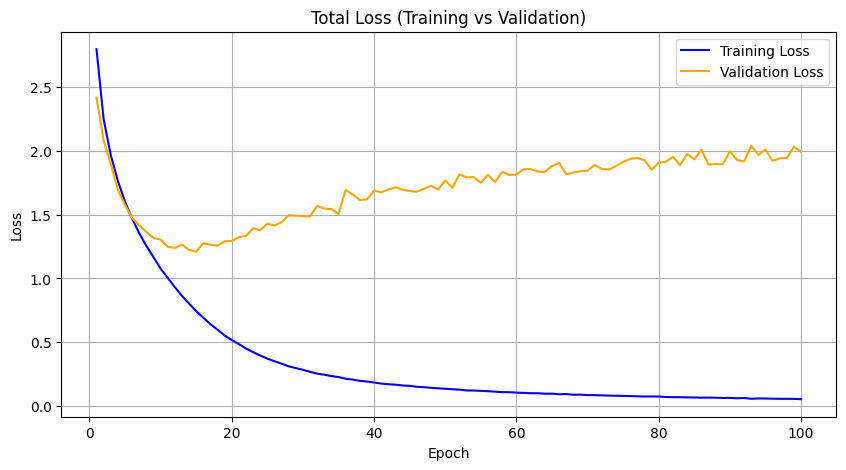

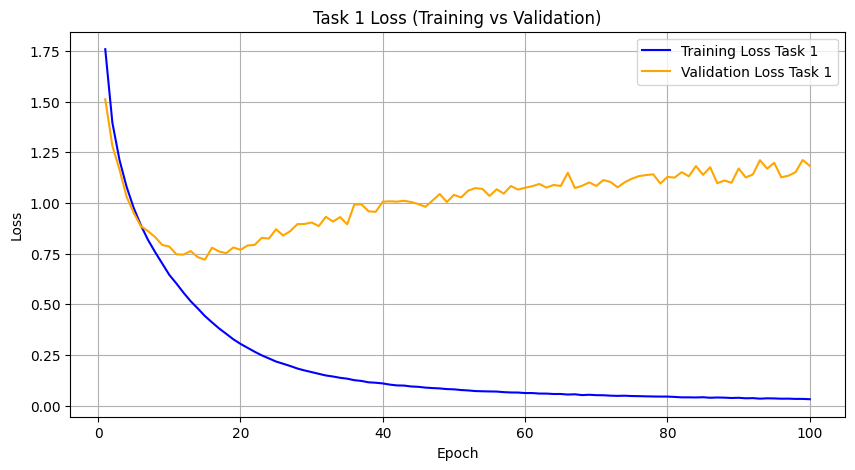

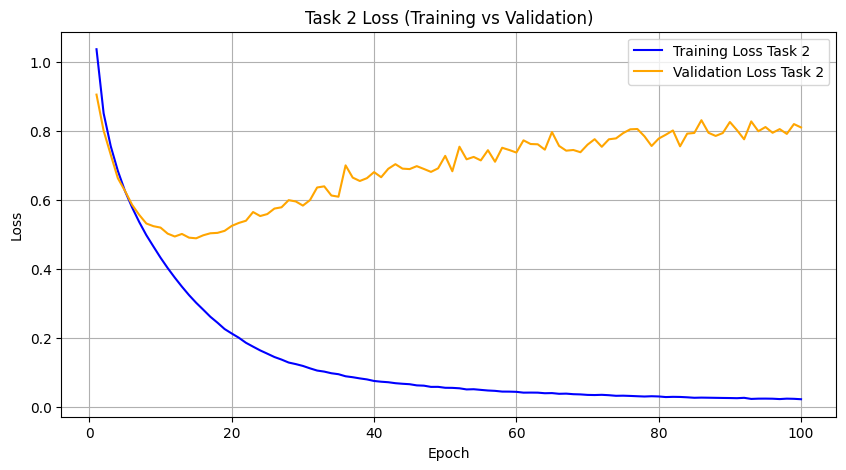

In [ ]:
# 1. Total loss
plt.figure(figsize=(10, 5))
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Train Loss Total'], label='Training Loss', color='blue')
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Valid Loss Total'], label='Validation Loss', color='orange')
plt.title('Total Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. Task 1 loss
plt.figure(figsize=(10, 5))
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Train Loss Task 1'], label='Training Loss Task 1', color='blue')
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Valid Loss Task 1'], label='Validation Loss Task 1', color='orange')
plt.title('Task 1 Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. Task 2 loss
plt.figure(figsize=(10, 5))
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Train Loss Task 2'], label='Training Loss Task 2', color='blue')
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Valid Loss Task 2'], label='Validation Loss Task 2', color='orange')
plt.title('Task 2 Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

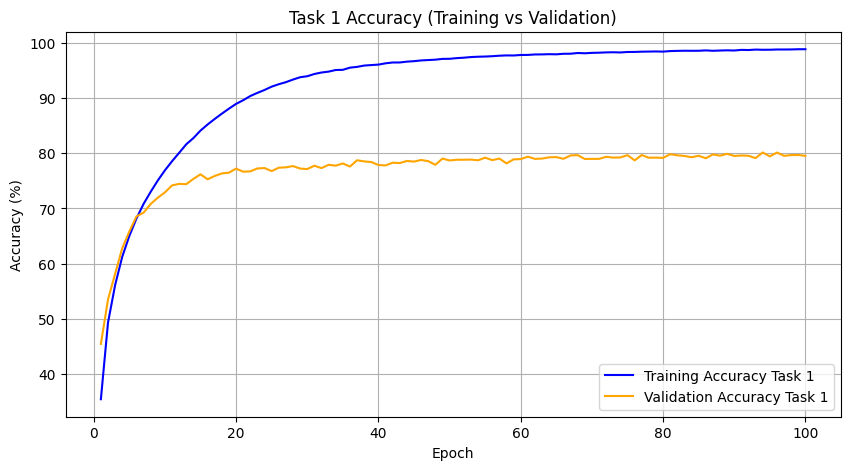

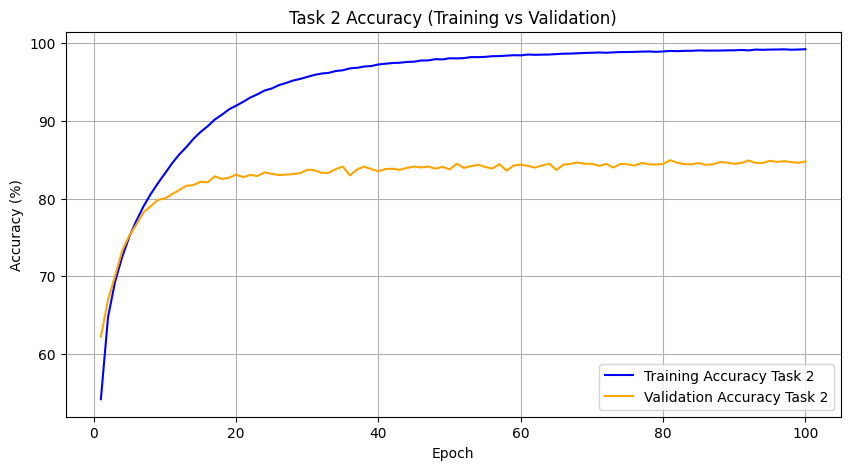

In [ ]:
# 1. Task 1 accuracy
plt.figure(figsize=(10, 5))
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Train Acc Task 1'], label='Training Accuracy Task 1', color='blue')
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Valid Acc Task 1'], label='Validation Accuracy Task 1', color='orange')
plt.title('Task 1 Accuracy (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# 2. Task 2 accuracy
plt.figure(figsize=(10, 5))
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Train Acc Task 2'], label='Training Accuracy Task 2', color='blue')
plt.plot(cs_mtl_results_df['Epoch'], cs_mtl_results_df['Valid Acc Task 2'], label='Validation Accuracy Task 2', color='orange')
plt.title('Task 2 Accuracy (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

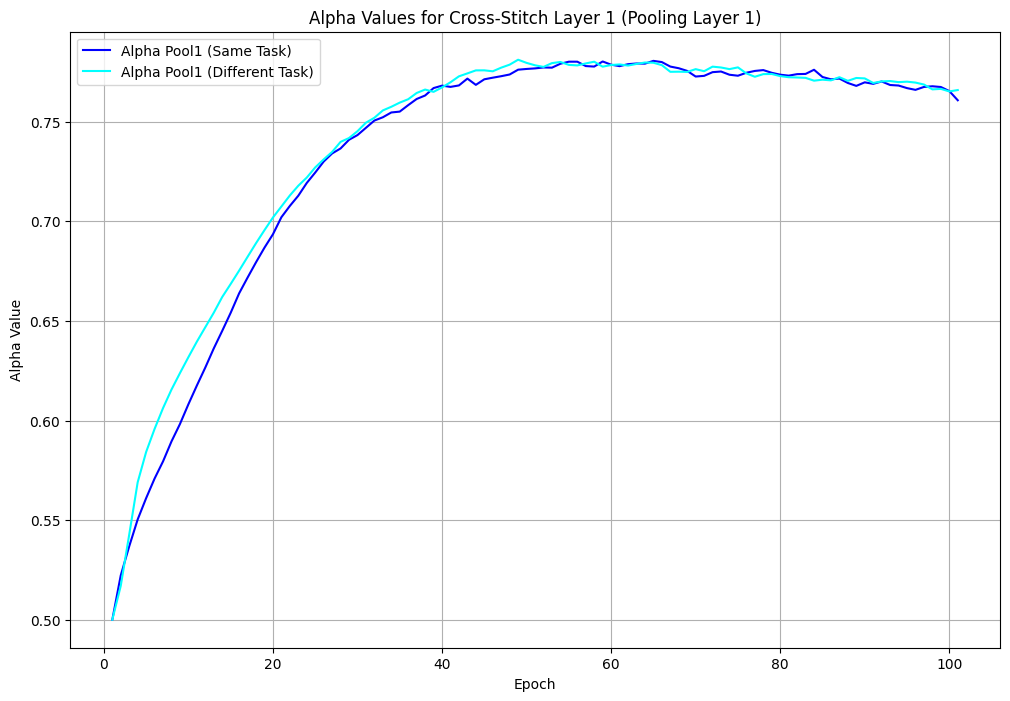

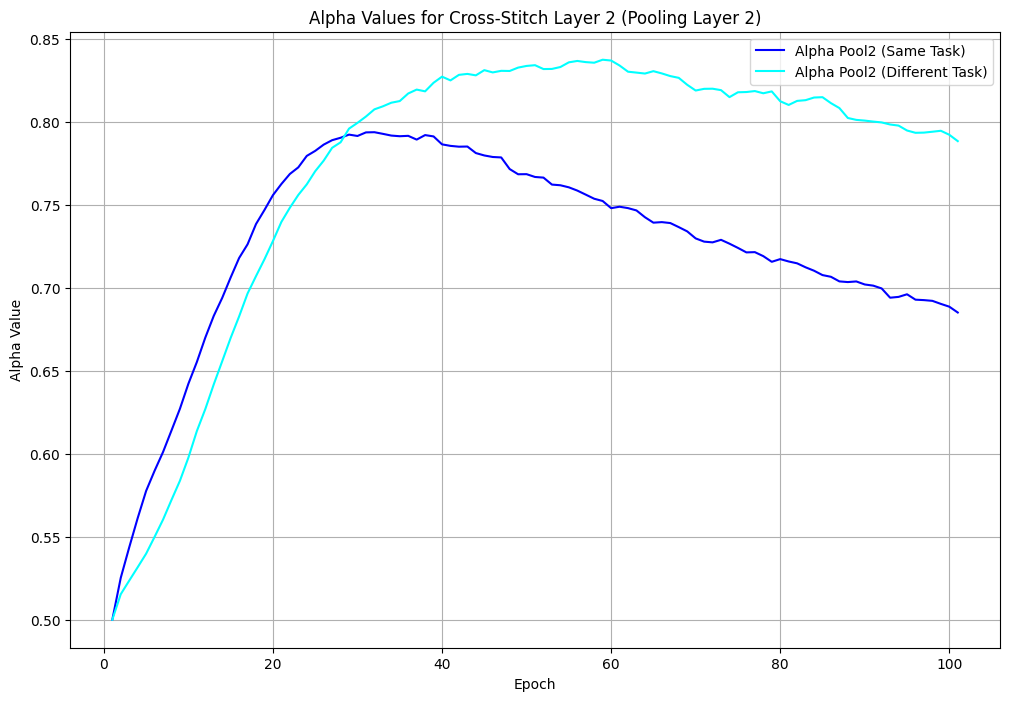

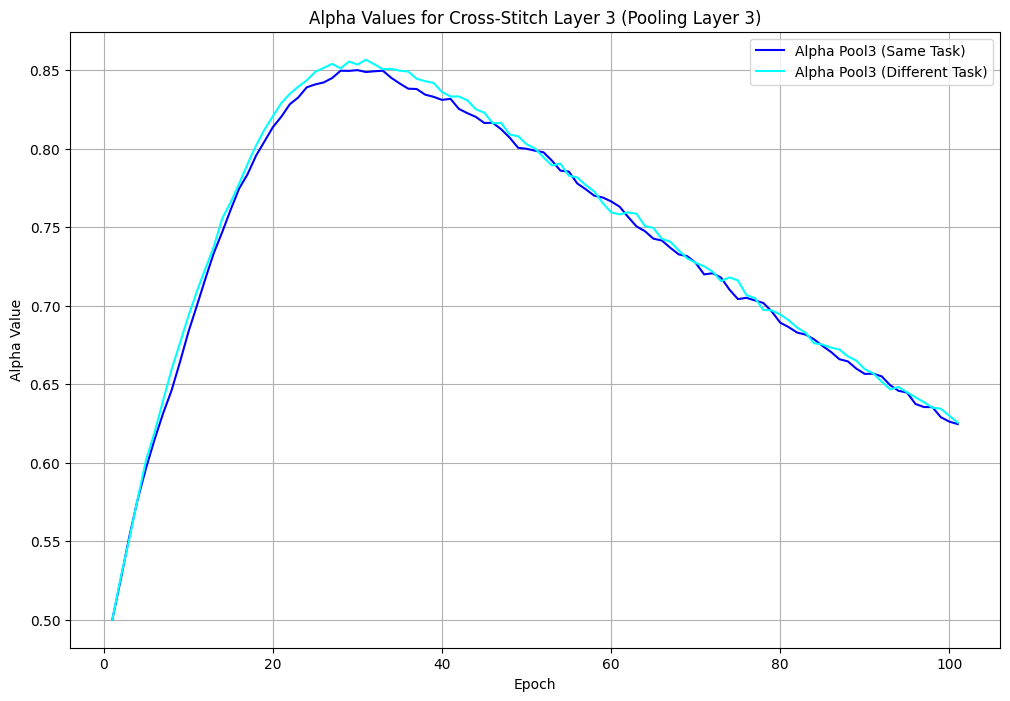

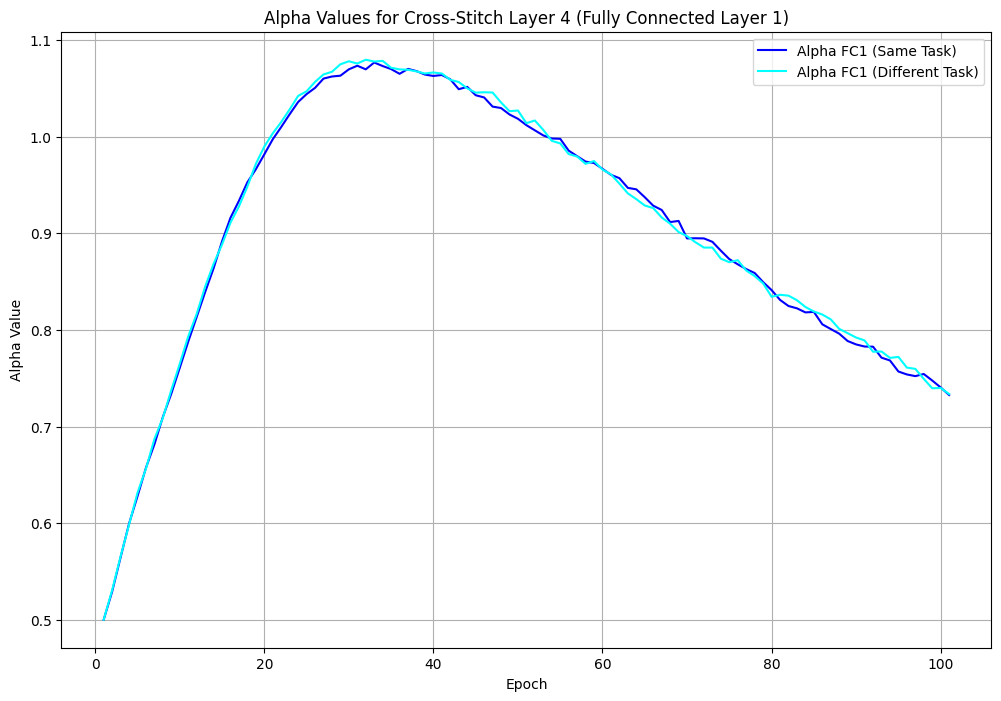

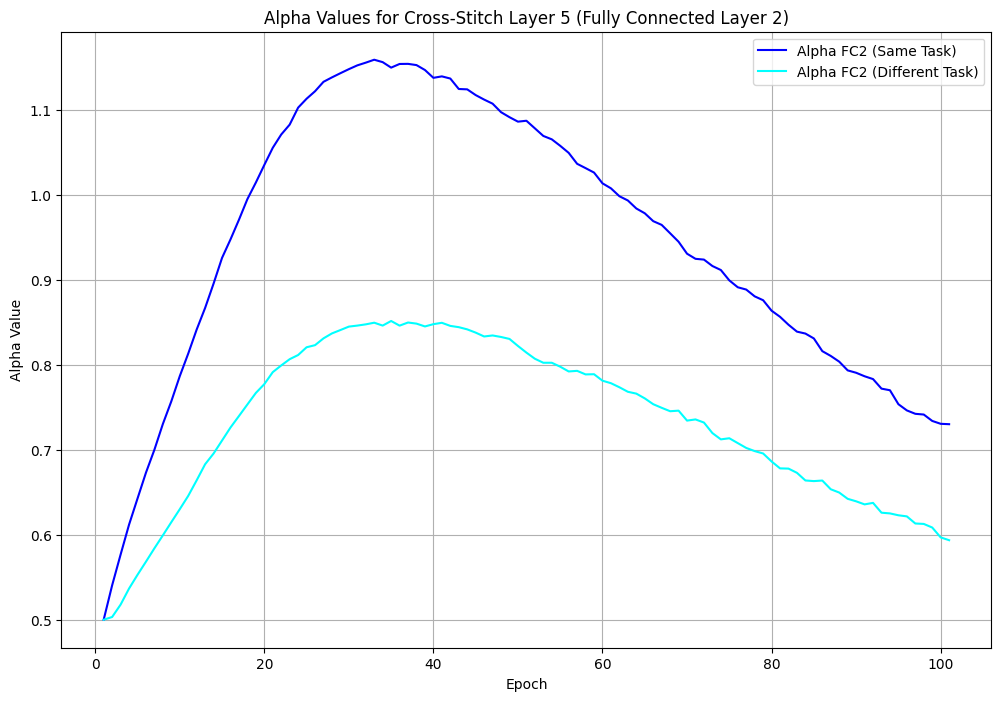

In [ ]:
# Plot the alpha values for cross-stitch layer 1
plt.figure(figsize=(12, 8))
plt.plot(alpha_history_df.index+1, alpha_history_df['pool1'].apply(lambda x: x[0]), label='Alpha Pool1 (Same Task)', color='blue')
plt.plot(alpha_history_df.index+1, alpha_history_df['pool1'].apply(lambda x: x[1]), label='Alpha Pool1 (Different Task)', color='cyan')
plt.title('Alpha Values for Cross-Stitch Layer 1 (Pooling Layer 1)')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.legend()
plt.grid()
plt.show()

# Plot the alpha values for cross-stitch layer 2
plt.figure(figsize=(12, 8))
plt.plot(alpha_history_df.index+1, alpha_history_df['pool2'].apply(lambda x: x[0]), label='Alpha Pool2 (Same Task)', color='blue')
plt.plot(alpha_history_df.index+1, alpha_history_df['pool2'].apply(lambda x: x[1]), label='Alpha Pool2 (Different Task)', color='cyan')
plt.title('Alpha Values for Cross-Stitch Layer 2 (Pooling Layer 2)')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.legend()
plt.grid()
plt.show()

# Plot the alpha values for cross-stitch layer 3
plt.figure(figsize=(12, 8))
plt.plot(alpha_history_df.index+1, alpha_history_df['pool3'].apply(lambda x: x[0]), label='Alpha Pool3 (Same Task)', color='blue')
plt.plot(alpha_history_df.index+1, alpha_history_df['pool3'].apply(lambda x: x[1]), label='Alpha Pool3 (Different Task)', color='cyan')
plt.title('Alpha Values for Cross-Stitch Layer 3 (Pooling Layer 3)')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.legend()
plt.grid()
plt.show()

# Plot the alpha values for cross-stitch layer 4
plt.figure(figsize=(12, 8))
plt.plot(alpha_history_df.index+1, alpha_history_df['fc1'].apply(lambda x: x[0]), label='Alpha FC1 (Same Task)', color='blue')
plt.plot(alpha_history_df.index+1, alpha_history_df['fc1'].apply(lambda x: x[1]), label='Alpha FC1 (Different Task)', color='cyan')
plt.title('Alpha Values for Cross-Stitch Layer 4 (Fully Connected Layer 1)')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.legend()
plt.grid()
plt.show()

# Plot the alpha values for cross-stitch layer 5
plt.figure(figsize=(12, 8))
plt.plot(alpha_history_df.index+1, alpha_history_df['fc2'].apply(lambda x: x[0]), label='Alpha FC2 (Same Task)', color='blue')
plt.plot(alpha_history_df.index+1, alpha_history_df['fc2'].apply(lambda x: x[1]), label='Alpha FC2 (Different Task)', color='cyan')
plt.title('Alpha Values for Cross-Stitch Layer 5 (Fully Connected Layer 2)')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.legend()
plt.grid()
plt.show()

### 8.3. Model Evaluation on Test Set

In [ ]:
model_cross_stitch_mtl.load_state_dict(torch.load('best_alexnet_cross_stitch_mtl_model.pt', map_location=device))

test_loss_cs_mtl, test_l1_cs_mtl, test_l2_cs_mtl, \
test_acc1_cs_mtl, test_acc2_cs_mtl = generic_evaluate_epoch_mtl(
    model_cross_stitch_mtl, test_loader, criterion, device, epoch_num=None, phase="Test", model_desc="Soft Parameter Sharing MTL"
)

Test Soft Parameter Sharing MTL: 100%|██████████| 625/625 [00:10<00:00, 60.39it/s]

Test Soft Parameter Sharing MTL Total Loss: 1.2978 | L1: 0.7825, L2: 0.5153 | Acc T1: 74.61%, Acc T2: 81.35%


## 10. Training: Single-Task Learning (STL)

### 10.1. Task 1 (Multi-class Classification)
#### 10 Classes

In [21]:
# --- STL Training for Task 1 (Original 10-Class Classification) ---
model_stl_task1 = STLNetwork(output_dim=NUM_OUTPUTS_TASK1).to(device)

print(f'The AlexNet-like model for task 1 has {humanize.intcomma(count_parameters(model_stl_task1))} trainable parameters.')

The AlexNet-like model for task 1 has 7,506,762 trainable parameters.


In [22]:
# Optimizer
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=0.0001)

#### 10.1.1. Training Loop

In [23]:
best_validation_loss_stl_task1 = float('inf')
stl_task1_training_results_list = []

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss_st1, train_acc_st1 = generic_train_epoch_stl(
        model_stl_task1, train_loader, optimizer_stl_task1, criterion, device, "task1", epoch, model_desc="Single Task Learning (Task 1)"
    )
    valid_loss_st1, valid_acc_st1 = generic_evaluate_epoch_stl(
        model_stl_task1, val_loader, criterion, device, "task1", epoch, phase="Validation", model_desc="Single Task Learning (Task 1)"
    )
    if valid_loss_st1 < best_validation_loss_stl_task1:
        best_validation_loss_stl_task1 = valid_loss_st1
        torch.save(model_stl_task1.state_dict(), 'best_alexnet_stl_task1_model.pt')

    # Save the training results for the epoch
    stl_task1_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss": train_loss_st1, "Train Acc": train_acc_st1,
        "Valid Loss": valid_loss_st1, "Valid Acc": valid_acc_st1
    })

end_time = time.time()

stl_task1_results_df = pd.DataFrame(stl_task1_training_results_list)

Epoch 1 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.45it/s]


Epoch: [1] Train Single Task Learning (Task 1) (task1) Loss: 1.7135, Acc: 36.17%


Epoch 1 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 83.85it/s]


Validation Epoch: [1] Single Task Learning (Task 1) (task1) Loss: 1.4110, Acc: 48.23%


Epoch 2 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.46it/s]


Epoch: [2] Train Single Task Learning (Task 1) (task1) Loss: 1.3311, Acc: 51.27%


Epoch 2 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 81.83it/s]


Validation Epoch: [2] Single Task Learning (Task 1) (task1) Loss: 1.1635, Acc: 57.91%


Epoch 3 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.36it/s]


Epoch: [3] Train Single Task Learning (Task 1) (task1) Loss: 1.1276, Acc: 59.31%


Epoch 3 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.69it/s]


Validation Epoch: [3] Single Task Learning (Task 1) (task1) Loss: 1.0574, Acc: 61.85%


Epoch 4 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 44.90it/s]


Epoch: [4] Train Single Task Learning (Task 1) (task1) Loss: 1.0007, Acc: 64.15%


Epoch 4 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 75.55it/s]


Validation Epoch: [4] Single Task Learning (Task 1) (task1) Loss: 0.9481, Acc: 66.29%


Epoch 5 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.43it/s]


Epoch: [5] Train Single Task Learning (Task 1) (task1) Loss: 0.8998, Acc: 68.02%


Epoch 5 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 75.25it/s]


Validation Epoch: [5] Single Task Learning (Task 1) (task1) Loss: 0.8505, Acc: 69.61%


Epoch 6 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.14it/s]


Epoch: [6] Train Single Task Learning (Task 1) (task1) Loss: 0.8113, Acc: 71.33%


Epoch 6 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 75.80it/s]


Validation Epoch: [6] Single Task Learning (Task 1) (task1) Loss: 0.8267, Acc: 70.81%


Epoch 7 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.30it/s]


Epoch: [7] Train Single Task Learning (Task 1) (task1) Loss: 0.7343, Acc: 74.15%


Epoch 7 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.84it/s]


Validation Epoch: [7] Single Task Learning (Task 1) (task1) Loss: 0.7489, Acc: 73.75%


Epoch 8 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.43it/s]


Epoch: [8] Train Single Task Learning (Task 1) (task1) Loss: 0.6623, Acc: 76.73%


Epoch 8 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.17it/s]


Validation Epoch: [8] Single Task Learning (Task 1) (task1) Loss: 0.7217, Acc: 74.91%


Epoch 9 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.49it/s]


Epoch: [9] Train Single Task Learning (Task 1) (task1) Loss: 0.5987, Acc: 78.93%


Epoch 9 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.26it/s]


Validation Epoch: [9] Single Task Learning (Task 1) (task1) Loss: 0.7186, Acc: 74.94%


Epoch 10 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.13it/s]


Epoch: [10] Train Single Task Learning (Task 1) (task1) Loss: 0.5388, Acc: 81.16%


Epoch 10 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.89it/s]


Validation Epoch: [10] Single Task Learning (Task 1) (task1) Loss: 0.6800, Acc: 76.25%


Epoch 11 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.46it/s]


Epoch: [11] Train Single Task Learning (Task 1) (task1) Loss: 0.4778, Acc: 83.18%


Epoch 11 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.79it/s]


Validation Epoch: [11] Single Task Learning (Task 1) (task1) Loss: 0.7032, Acc: 76.16%


Epoch 12 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.27it/s]


Epoch: [12] Train Single Task Learning (Task 1) (task1) Loss: 0.4258, Acc: 85.04%


Epoch 12 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.66it/s]


Validation Epoch: [12] Single Task Learning (Task 1) (task1) Loss: 0.7024, Acc: 76.74%


Epoch 13 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.44it/s]


Epoch: [13] Train Single Task Learning (Task 1) (task1) Loss: 0.3747, Acc: 86.78%


Epoch 13 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.74it/s]


Validation Epoch: [13] Single Task Learning (Task 1) (task1) Loss: 0.7105, Acc: 77.14%


Epoch 14 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.59it/s]


Epoch: [14] Train Single Task Learning (Task 1) (task1) Loss: 0.3298, Acc: 88.32%


Epoch 14 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 78.02it/s]


Validation Epoch: [14] Single Task Learning (Task 1) (task1) Loss: 0.7121, Acc: 77.53%


Epoch 15 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:58<00:00, 47.70it/s]


Epoch: [15] Train Single Task Learning (Task 1) (task1) Loss: 0.2886, Acc: 89.74%


Epoch 15 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.90it/s]


Validation Epoch: [15] Single Task Learning (Task 1) (task1) Loss: 0.7657, Acc: 77.28%


Epoch 16 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.54it/s]


Epoch: [16] Train Single Task Learning (Task 1) (task1) Loss: 0.2530, Acc: 91.02%


Epoch 16 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.78it/s]


Validation Epoch: [16] Single Task Learning (Task 1) (task1) Loss: 0.7585, Acc: 77.46%


Epoch 17 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.65it/s]


Epoch: [17] Train Single Task Learning (Task 1) (task1) Loss: 0.2193, Acc: 92.22%


Epoch 17 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.70it/s]


Validation Epoch: [17] Single Task Learning (Task 1) (task1) Loss: 0.8606, Acc: 76.61%


Epoch 18 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.30it/s]


Epoch: [18] Train Single Task Learning (Task 1) (task1) Loss: 0.1931, Acc: 93.16%


Epoch 18 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 75.94it/s]


Validation Epoch: [18] Single Task Learning (Task 1) (task1) Loss: 0.8553, Acc: 77.34%


Epoch 19 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 44.24it/s]


Epoch: [19] Train Single Task Learning (Task 1) (task1) Loss: 0.1722, Acc: 93.85%


Epoch 19 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 80.97it/s]


Validation Epoch: [19] Single Task Learning (Task 1) (task1) Loss: 0.8813, Acc: 77.33%


Epoch 20 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.73it/s]


Epoch: [20] Train Single Task Learning (Task 1) (task1) Loss: 0.1527, Acc: 94.49%


Epoch 20 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 83.80it/s]


Validation Epoch: [20] Single Task Learning (Task 1) (task1) Loss: 0.9815, Acc: 76.61%


Epoch 21 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.43it/s]


Epoch: [21] Train Single Task Learning (Task 1) (task1) Loss: 0.1390, Acc: 95.08%


Epoch 21 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 80.61it/s]


Validation Epoch: [21] Single Task Learning (Task 1) (task1) Loss: 0.9708, Acc: 77.02%


Epoch 22 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.05it/s]


Epoch: [22] Train Single Task Learning (Task 1) (task1) Loss: 0.1248, Acc: 95.56%


Epoch 22 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 80.85it/s]


Validation Epoch: [22] Single Task Learning (Task 1) (task1) Loss: 0.9986, Acc: 76.47%


Epoch 23 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:58<00:00, 47.82it/s]


Epoch: [23] Train Single Task Learning (Task 1) (task1) Loss: 0.1143, Acc: 95.94%


Epoch 23 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 83.05it/s]


Validation Epoch: [23] Single Task Learning (Task 1) (task1) Loss: 1.0508, Acc: 77.10%


Epoch 24 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.81it/s]


Epoch: [24] Train Single Task Learning (Task 1) (task1) Loss: 0.1077, Acc: 96.18%


Epoch 24 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 83.81it/s]


Validation Epoch: [24] Single Task Learning (Task 1) (task1) Loss: 1.0219, Acc: 77.04%


Epoch 25 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.37it/s]


Epoch: [25] Train Single Task Learning (Task 1) (task1) Loss: 0.0999, Acc: 96.48%


Epoch 25 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 85.63it/s]


Validation Epoch: [25] Single Task Learning (Task 1) (task1) Loss: 1.0968, Acc: 77.06%


Epoch 26 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.64it/s]


Epoch: [26] Train Single Task Learning (Task 1) (task1) Loss: 0.0920, Acc: 96.78%


Epoch 26 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 79.96it/s]


Validation Epoch: [26] Single Task Learning (Task 1) (task1) Loss: 1.1192, Acc: 76.56%


Epoch 27 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.57it/s]


Epoch: [27] Train Single Task Learning (Task 1) (task1) Loss: 0.0875, Acc: 96.93%


Epoch 27 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 83.35it/s]


Validation Epoch: [27] Single Task Learning (Task 1) (task1) Loss: 1.1104, Acc: 77.21%


Epoch 28 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.27it/s]


Epoch: [28] Train Single Task Learning (Task 1) (task1) Loss: 0.0848, Acc: 97.07%


Epoch 28 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 83.69it/s]


Validation Epoch: [28] Single Task Learning (Task 1) (task1) Loss: 1.1180, Acc: 76.97%


Epoch 29 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.34it/s]


Epoch: [29] Train Single Task Learning (Task 1) (task1) Loss: 0.0790, Acc: 97.23%


Epoch 29 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 81.63it/s]


Validation Epoch: [29] Single Task Learning (Task 1) (task1) Loss: 1.1568, Acc: 76.55%


Epoch 30 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 45.12it/s]


Epoch: [30] Train Single Task Learning (Task 1) (task1) Loss: 0.0742, Acc: 97.44%


Epoch 30 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 84.10it/s]


Validation Epoch: [30] Single Task Learning (Task 1) (task1) Loss: 1.1929, Acc: 77.04%


Epoch 31 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.25it/s]


Epoch: [31] Train Single Task Learning (Task 1) (task1) Loss: 0.0730, Acc: 97.42%


Epoch 31 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.51it/s]


Validation Epoch: [31] Single Task Learning (Task 1) (task1) Loss: 1.2028, Acc: 77.28%


Epoch 32 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.61it/s]


Epoch: [32] Train Single Task Learning (Task 1) (task1) Loss: 0.0692, Acc: 97.64%


Epoch 32 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 84.52it/s]


Validation Epoch: [32] Single Task Learning (Task 1) (task1) Loss: 1.1312, Acc: 77.45%


Epoch 33 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 46.96it/s]


Epoch: [33] Train Single Task Learning (Task 1) (task1) Loss: 0.0664, Acc: 97.70%


Epoch 33 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 85.31it/s]


Validation Epoch: [33] Single Task Learning (Task 1) (task1) Loss: 1.1804, Acc: 77.36%


Epoch 34 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.70it/s]


Epoch: [34] Train Single Task Learning (Task 1) (task1) Loss: 0.0649, Acc: 97.74%


Epoch 34 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.75it/s]


Validation Epoch: [34] Single Task Learning (Task 1) (task1) Loss: 1.1731, Acc: 77.50%


Epoch 35 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:58<00:00, 48.05it/s]


Epoch: [35] Train Single Task Learning (Task 1) (task1) Loss: 0.0633, Acc: 97.83%


Epoch 35 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 82.60it/s]


Validation Epoch: [35] Single Task Learning (Task 1) (task1) Loss: 1.2453, Acc: 77.67%


Epoch 36 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:57<00:00, 49.25it/s]


Epoch: [36] Train Single Task Learning (Task 1) (task1) Loss: 0.0607, Acc: 97.86%


Epoch 36 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 85.61it/s]


Validation Epoch: [36] Single Task Learning (Task 1) (task1) Loss: 1.1861, Acc: 77.33%


Epoch 37 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:56<00:00, 49.36it/s]


Epoch: [37] Train Single Task Learning (Task 1) (task1) Loss: 0.0566, Acc: 98.06%


Epoch 37 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 84.57it/s]


Validation Epoch: [37] Single Task Learning (Task 1) (task1) Loss: 1.2115, Acc: 77.08%


Epoch 38 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:58<00:00, 48.21it/s]


Epoch: [38] Train Single Task Learning (Task 1) (task1) Loss: 0.0568, Acc: 98.04%


Epoch 38 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.29it/s]


Validation Epoch: [38] Single Task Learning (Task 1) (task1) Loss: 1.2881, Acc: 76.47%


Epoch 39 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.56it/s]


Epoch: [39] Train Single Task Learning (Task 1) (task1) Loss: 0.0547, Acc: 98.14%


Epoch 39 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.08it/s]


Validation Epoch: [39] Single Task Learning (Task 1) (task1) Loss: 1.2355, Acc: 77.00%


Epoch 40 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.41it/s]


Epoch: [40] Train Single Task Learning (Task 1) (task1) Loss: 0.0521, Acc: 98.21%


Epoch 40 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.51it/s]


Validation Epoch: [40] Single Task Learning (Task 1) (task1) Loss: 1.2233, Acc: 77.64%


Epoch 41 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.51it/s]


Epoch: [41] Train Single Task Learning (Task 1) (task1) Loss: 0.0510, Acc: 98.26%


Epoch 41 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.29it/s]


Validation Epoch: [41] Single Task Learning (Task 1) (task1) Loss: 1.3203, Acc: 76.36%


Epoch 42 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 47.00it/s]


Epoch: [42] Train Single Task Learning (Task 1) (task1) Loss: 0.0501, Acc: 98.27%


Epoch 42 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 73.03it/s]


Validation Epoch: [42] Single Task Learning (Task 1) (task1) Loss: 1.2715, Acc: 76.99%


Epoch 43 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.89it/s]


Epoch: [43] Train Single Task Learning (Task 1) (task1) Loss: 0.0482, Acc: 98.37%


Epoch 43 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 72.28it/s]


Validation Epoch: [43] Single Task Learning (Task 1) (task1) Loss: 1.2571, Acc: 77.70%


Epoch 44 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.80it/s]


Epoch: [44] Train Single Task Learning (Task 1) (task1) Loss: 0.0482, Acc: 98.33%


Epoch 44 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 71.63it/s]


Validation Epoch: [44] Single Task Learning (Task 1) (task1) Loss: 1.2289, Acc: 77.46%


Epoch 45 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:05<00:00, 43.00it/s]


Epoch: [45] Train Single Task Learning (Task 1) (task1) Loss: 0.0455, Acc: 98.44%


Epoch 45 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 75.08it/s]


Validation Epoch: [45] Single Task Learning (Task 1) (task1) Loss: 1.3168, Acc: 77.53%


Epoch 46 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:05<00:00, 43.13it/s]


Epoch: [46] Train Single Task Learning (Task 1) (task1) Loss: 0.0452, Acc: 98.47%


Epoch 46 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.34it/s]


Validation Epoch: [46] Single Task Learning (Task 1) (task1) Loss: 1.3423, Acc: 78.07%


Epoch 47 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 44.15it/s]


Epoch: [47] Train Single Task Learning (Task 1) (task1) Loss: 0.0442, Acc: 98.49%


Epoch 47 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 82.47it/s]


Validation Epoch: [47] Single Task Learning (Task 1) (task1) Loss: 1.4133, Acc: 77.53%


Epoch 48 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.35it/s]


Epoch: [48] Train Single Task Learning (Task 1) (task1) Loss: 0.0424, Acc: 98.58%


Epoch 48 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 79.98it/s]


Validation Epoch: [48] Single Task Learning (Task 1) (task1) Loss: 1.3279, Acc: 77.81%


Epoch 49 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 46.91it/s]


Epoch: [49] Train Single Task Learning (Task 1) (task1) Loss: 0.0427, Acc: 98.51%


Epoch 49 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.63it/s]


Validation Epoch: [49] Single Task Learning (Task 1) (task1) Loss: 1.3178, Acc: 77.79%


Epoch 50 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.88it/s]


Epoch: [50] Train Single Task Learning (Task 1) (task1) Loss: 0.0411, Acc: 98.59%


Epoch 50 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.43it/s]


Validation Epoch: [50] Single Task Learning (Task 1) (task1) Loss: 1.3381, Acc: 77.41%


Epoch 51 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.30it/s]


Epoch: [51] Train Single Task Learning (Task 1) (task1) Loss: 0.0407, Acc: 98.60%


Epoch 51 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 79.64it/s]


Validation Epoch: [51] Single Task Learning (Task 1) (task1) Loss: 1.2961, Acc: 78.15%


Epoch 52 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 44.54it/s]


Epoch: [52] Train Single Task Learning (Task 1) (task1) Loss: 0.0383, Acc: 98.68%


Epoch 52 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 73.18it/s]


Validation Epoch: [52] Single Task Learning (Task 1) (task1) Loss: 1.3586, Acc: 77.80%


Epoch 53 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.73it/s]


Epoch: [53] Train Single Task Learning (Task 1) (task1) Loss: 0.0395, Acc: 98.67%


Epoch 53 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 69.59it/s]


Validation Epoch: [53] Single Task Learning (Task 1) (task1) Loss: 1.3883, Acc: 77.36%


Epoch 54 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 45.06it/s]


Epoch: [54] Train Single Task Learning (Task 1) (task1) Loss: 0.0380, Acc: 98.72%


Epoch 54 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 78.11it/s]


Validation Epoch: [54] Single Task Learning (Task 1) (task1) Loss: 1.3411, Acc: 77.26%


Epoch 55 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.42it/s]


Epoch: [55] Train Single Task Learning (Task 1) (task1) Loss: 0.0367, Acc: 98.75%


Epoch 55 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.63it/s]


Validation Epoch: [55] Single Task Learning (Task 1) (task1) Loss: 1.4746, Acc: 76.86%


Epoch 56 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.39it/s]


Epoch: [56] Train Single Task Learning (Task 1) (task1) Loss: 0.0367, Acc: 98.78%


Epoch 56 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.59it/s]


Validation Epoch: [56] Single Task Learning (Task 1) (task1) Loss: 1.4471, Acc: 77.26%


Epoch 57 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.52it/s]


Epoch: [57] Train Single Task Learning (Task 1) (task1) Loss: 0.0351, Acc: 98.82%


Epoch 57 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 80.08it/s]


Validation Epoch: [57] Single Task Learning (Task 1) (task1) Loss: 1.4529, Acc: 77.42%


Epoch 58 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 45.30it/s]


Epoch: [58] Train Single Task Learning (Task 1) (task1) Loss: 0.0355, Acc: 98.79%


Epoch 58 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 81.33it/s]


Validation Epoch: [58] Single Task Learning (Task 1) (task1) Loss: 1.4759, Acc: 77.07%


Epoch 59 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.25it/s]


Epoch: [59] Train Single Task Learning (Task 1) (task1) Loss: 0.0338, Acc: 98.84%


Epoch 59 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 80.53it/s]


Validation Epoch: [59] Single Task Learning (Task 1) (task1) Loss: 1.5516, Acc: 77.72%


Epoch 60 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.96it/s]


Epoch: [60] Train Single Task Learning (Task 1) (task1) Loss: 0.0333, Acc: 98.86%


Epoch 60 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 81.77it/s]


Validation Epoch: [60] Single Task Learning (Task 1) (task1) Loss: 1.4542, Acc: 77.61%


Epoch 61 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.39it/s]


Epoch: [61] Train Single Task Learning (Task 1) (task1) Loss: 0.0337, Acc: 98.87%


Epoch 61 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 78.22it/s]


Validation Epoch: [61] Single Task Learning (Task 1) (task1) Loss: 1.4125, Acc: 77.19%


Epoch 62 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.62it/s]


Epoch: [62] Train Single Task Learning (Task 1) (task1) Loss: 0.0334, Acc: 98.87%


Epoch 62 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 81.67it/s]


Validation Epoch: [62] Single Task Learning (Task 1) (task1) Loss: 1.4844, Acc: 77.36%


Epoch 63 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 46.09it/s]


Epoch: [63] Train Single Task Learning (Task 1) (task1) Loss: 0.0329, Acc: 98.87%


Epoch 63 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 80.11it/s]


Validation Epoch: [63] Single Task Learning (Task 1) (task1) Loss: 1.4142, Acc: 77.92%


Epoch 64 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.37it/s]


Epoch: [64] Train Single Task Learning (Task 1) (task1) Loss: 0.0300, Acc: 98.97%


Epoch 64 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 81.15it/s]


Validation Epoch: [64] Single Task Learning (Task 1) (task1) Loss: 1.4912, Acc: 77.45%


Epoch 65 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.62it/s]


Epoch: [65] Train Single Task Learning (Task 1) (task1) Loss: 0.0311, Acc: 98.95%


Epoch 65 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.32it/s]


Validation Epoch: [65] Single Task Learning (Task 1) (task1) Loss: 1.4198, Acc: 77.68%


Epoch 66 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.47it/s]


Epoch: [66] Train Single Task Learning (Task 1) (task1) Loss: 0.0308, Acc: 98.98%


Epoch 66 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.79it/s]


Validation Epoch: [66] Single Task Learning (Task 1) (task1) Loss: 1.4687, Acc: 77.12%


Epoch 67 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:06<00:00, 42.42it/s]


Epoch: [67] Train Single Task Learning (Task 1) (task1) Loss: 0.0289, Acc: 99.03%


Epoch 67 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.03it/s]


Validation Epoch: [67] Single Task Learning (Task 1) (task1) Loss: 1.5564, Acc: 77.05%


Epoch 68 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.89it/s]


Epoch: [68] Train Single Task Learning (Task 1) (task1) Loss: 0.0311, Acc: 98.93%


Epoch 68 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.07it/s]


Validation Epoch: [68] Single Task Learning (Task 1) (task1) Loss: 1.4838, Acc: 77.92%


Epoch 69 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 44.14it/s]


Epoch: [69] Train Single Task Learning (Task 1) (task1) Loss: 0.0293, Acc: 99.03%


Epoch 69 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.27it/s]


Validation Epoch: [69] Single Task Learning (Task 1) (task1) Loss: 1.4993, Acc: 77.73%


Epoch 70 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.55it/s]


Epoch: [70] Train Single Task Learning (Task 1) (task1) Loss: 0.0303, Acc: 98.98%


Epoch 70 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.32it/s]


Validation Epoch: [70] Single Task Learning (Task 1) (task1) Loss: 1.4552, Acc: 77.38%


Epoch 71 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.61it/s]


Epoch: [71] Train Single Task Learning (Task 1) (task1) Loss: 0.0290, Acc: 99.02%


Epoch 71 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.28it/s]


Validation Epoch: [71] Single Task Learning (Task 1) (task1) Loss: 1.5261, Acc: 77.73%


Epoch 72 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 44.66it/s]


Epoch: [72] Train Single Task Learning (Task 1) (task1) Loss: 0.0292, Acc: 99.02%


Epoch 72 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.50it/s]


Validation Epoch: [72] Single Task Learning (Task 1) (task1) Loss: 1.5452, Acc: 77.06%


Epoch 73 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 45.09it/s]


Epoch: [73] Train Single Task Learning (Task 1) (task1) Loss: 0.0279, Acc: 99.05%


Epoch 73 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.16it/s]


Validation Epoch: [73] Single Task Learning (Task 1) (task1) Loss: 1.6263, Acc: 76.86%


Epoch 74 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.66it/s]


Epoch: [74] Train Single Task Learning (Task 1) (task1) Loss: 0.0289, Acc: 99.03%


Epoch 74 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.79it/s]


Validation Epoch: [74] Single Task Learning (Task 1) (task1) Loss: 1.4448, Acc: 77.78%


Epoch 75 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.76it/s]


Epoch: [75] Train Single Task Learning (Task 1) (task1) Loss: 0.0269, Acc: 99.10%


Epoch 75 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 74.21it/s]


Validation Epoch: [75] Single Task Learning (Task 1) (task1) Loss: 1.5472, Acc: 77.66%


Epoch 76 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.51it/s]


Epoch: [76] Train Single Task Learning (Task 1) (task1) Loss: 0.0267, Acc: 99.11%


Epoch 76 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 69.60it/s]


Validation Epoch: [76] Single Task Learning (Task 1) (task1) Loss: 1.5614, Acc: 77.58%


Epoch 77 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:05<00:00, 42.85it/s]


Epoch: [77] Train Single Task Learning (Task 1) (task1) Loss: 0.0264, Acc: 99.13%


Epoch 77 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.10it/s]


Validation Epoch: [77] Single Task Learning (Task 1) (task1) Loss: 1.5584, Acc: 77.88%


Epoch 78 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.76it/s]


Epoch: [78] Train Single Task Learning (Task 1) (task1) Loss: 0.0263, Acc: 99.10%


Epoch 78 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.17it/s]


Validation Epoch: [78] Single Task Learning (Task 1) (task1) Loss: 1.5308, Acc: 77.59%


Epoch 79 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.89it/s]


Epoch: [79] Train Single Task Learning (Task 1) (task1) Loss: 0.0265, Acc: 99.11%


Epoch 79 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.13it/s]


Validation Epoch: [79] Single Task Learning (Task 1) (task1) Loss: 1.6378, Acc: 76.06%


Epoch 80 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.78it/s]


Epoch: [80] Train Single Task Learning (Task 1) (task1) Loss: 0.0266, Acc: 99.14%


Epoch 80 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.81it/s]


Validation Epoch: [80] Single Task Learning (Task 1) (task1) Loss: 1.4662, Acc: 77.83%


Epoch 81 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.84it/s]


Epoch: [81] Train Single Task Learning (Task 1) (task1) Loss: 0.0249, Acc: 99.14%


Epoch 81 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.13it/s]


Validation Epoch: [81] Single Task Learning (Task 1) (task1) Loss: 1.5621, Acc: 77.59%


Epoch 82 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.94it/s]


Epoch: [82] Train Single Task Learning (Task 1) (task1) Loss: 0.0252, Acc: 99.15%


Epoch 82 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 71.08it/s]


Validation Epoch: [82] Single Task Learning (Task 1) (task1) Loss: 1.5752, Acc: 77.78%


Epoch 83 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.88it/s]


Epoch: [83] Train Single Task Learning (Task 1) (task1) Loss: 0.0241, Acc: 99.20%


Epoch 83 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.73it/s]


Validation Epoch: [83] Single Task Learning (Task 1) (task1) Loss: 1.6392, Acc: 77.67%


Epoch 84 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 43.96it/s]


Epoch: [84] Train Single Task Learning (Task 1) (task1) Loss: 0.0254, Acc: 99.15%


Epoch 84 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.23it/s]


Validation Epoch: [84] Single Task Learning (Task 1) (task1) Loss: 1.6007, Acc: 77.46%


Epoch 85 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 44.68it/s]


Epoch: [85] Train Single Task Learning (Task 1) (task1) Loss: 0.0240, Acc: 99.21%


Epoch 85 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 82.97it/s]


Validation Epoch: [85] Single Task Learning (Task 1) (task1) Loss: 1.6407, Acc: 77.64%


Epoch 86 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:02<00:00, 45.37it/s]


Epoch: [86] Train Single Task Learning (Task 1) (task1) Loss: 0.0255, Acc: 99.17%


Epoch 86 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.74it/s]


Validation Epoch: [86] Single Task Learning (Task 1) (task1) Loss: 1.5488, Acc: 77.62%


Epoch 87 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.84it/s]


Epoch: [87] Train Single Task Learning (Task 1) (task1) Loss: 0.0236, Acc: 99.23%


Epoch 87 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.94it/s]


Validation Epoch: [87] Single Task Learning (Task 1) (task1) Loss: 1.5228, Acc: 77.59%


Epoch 88 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.30it/s]


Epoch: [88] Train Single Task Learning (Task 1) (task1) Loss: 0.0234, Acc: 99.21%


Epoch 88 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.19it/s]


Validation Epoch: [88] Single Task Learning (Task 1) (task1) Loss: 1.6164, Acc: 77.55%


Epoch 89 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.70it/s]


Epoch: [89] Train Single Task Learning (Task 1) (task1) Loss: 0.0242, Acc: 99.19%


Epoch 89 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.03it/s]


Validation Epoch: [89] Single Task Learning (Task 1) (task1) Loss: 1.5639, Acc: 77.59%


Epoch 90 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.64it/s]


Epoch: [90] Train Single Task Learning (Task 1) (task1) Loss: 0.0226, Acc: 99.23%


Epoch 90 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 70.06it/s]


Validation Epoch: [90] Single Task Learning (Task 1) (task1) Loss: 1.6051, Acc: 77.47%


Epoch 91 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:05<00:00, 42.80it/s]


Epoch: [91] Train Single Task Learning (Task 1) (task1) Loss: 0.0231, Acc: 99.26%


Epoch 91 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 69.68it/s]


Validation Epoch: [91] Single Task Learning (Task 1) (task1) Loss: 1.5848, Acc: 77.62%


Epoch 92 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.31it/s]


Epoch: [92] Train Single Task Learning (Task 1) (task1) Loss: 0.0235, Acc: 99.21%


Epoch 92 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 76.58it/s]


Validation Epoch: [92] Single Task Learning (Task 1) (task1) Loss: 1.6086, Acc: 77.62%


Epoch 93 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.83it/s]


Epoch: [93] Train Single Task Learning (Task 1) (task1) Loss: 0.0216, Acc: 99.30%


Epoch 93 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.15it/s]


Validation Epoch: [93] Single Task Learning (Task 1) (task1) Loss: 1.7165, Acc: 77.81%


Epoch 94 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 43.99it/s]


Epoch: [94] Train Single Task Learning (Task 1) (task1) Loss: 0.0229, Acc: 99.28%


Epoch 94 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 68.75it/s]


Validation Epoch: [94] Single Task Learning (Task 1) (task1) Loss: 1.5594, Acc: 77.72%


Epoch 95 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:03<00:00, 44.41it/s]


Epoch: [95] Train Single Task Learning (Task 1) (task1) Loss: 0.0218, Acc: 99.28%


Epoch 95 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.16it/s]


Validation Epoch: [95] Single Task Learning (Task 1) (task1) Loss: 1.5682, Acc: 77.58%


Epoch 96 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:01<00:00, 45.72it/s]


Epoch: [96] Train Single Task Learning (Task 1) (task1) Loss: 0.0220, Acc: 99.30%


Epoch 96 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 77.93it/s]


Validation Epoch: [96] Single Task Learning (Task 1) (task1) Loss: 1.5828, Acc: 78.25%


Epoch 97 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [00:59<00:00, 46.88it/s]


Epoch: [97] Train Single Task Learning (Task 1) (task1) Loss: 0.0225, Acc: 99.27%


Epoch 97 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.53it/s]


Validation Epoch: [97] Single Task Learning (Task 1) (task1) Loss: 1.5823, Acc: 77.53%


Epoch 98 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:00<00:00, 46.39it/s]


Epoch: [98] Train Single Task Learning (Task 1) (task1) Loss: 0.0217, Acc: 99.29%


Epoch 98 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:03<00:00, 78.76it/s]


Validation Epoch: [98] Single Task Learning (Task 1) (task1) Loss: 1.6822, Acc: 77.28%


Epoch 99 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.67it/s]


Epoch: [99] Train Single Task Learning (Task 1) (task1) Loss: 0.0212, Acc: 99.32%


Epoch 99 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 75.63it/s]


Validation Epoch: [99] Single Task Learning (Task 1) (task1) Loss: 1.6673, Acc: 76.94%


Epoch 100 Training Single Task Learning (Task 1) (task1): 100%|██████████| 2813/2813 [01:04<00:00, 43.42it/s]


Epoch: [100] Train Single Task Learning (Task 1) (task1) Loss: 0.0218, Acc: 99.29%


Epoch 100 Validation Single Task Learning (Task 1) (task1): 100%|██████████| 313/313 [00:04<00:00, 63.90it/s]

Validation Epoch: [100] Single Task Learning (Task 1) (task1) Loss: 1.6629, Acc: 77.80%


In [24]:
# Print the time taken for training
training_time_stl_task1 = end_time - time_start

# Convert total seconds to an integer
total_seconds = int(training_time_stl_task1)

# Calculate hours, minutes, and remaining seconds
minutes, seconds = divmod(total_seconds, 60)
hours, minutes = divmod(minutes, 60)

# Print the time taken for training in H, M, S format
print(f"To train the model for task 1 (10-class classification) for 100 epochs, it took {hours} hours, {minutes} minutes, {seconds} seconds.")

To train the model for task 1 (10-class classification) for 100 epochs, it took 1 hours, 49 minutes, 37 seconds.


#### 10.1.2. Training and Validation Results

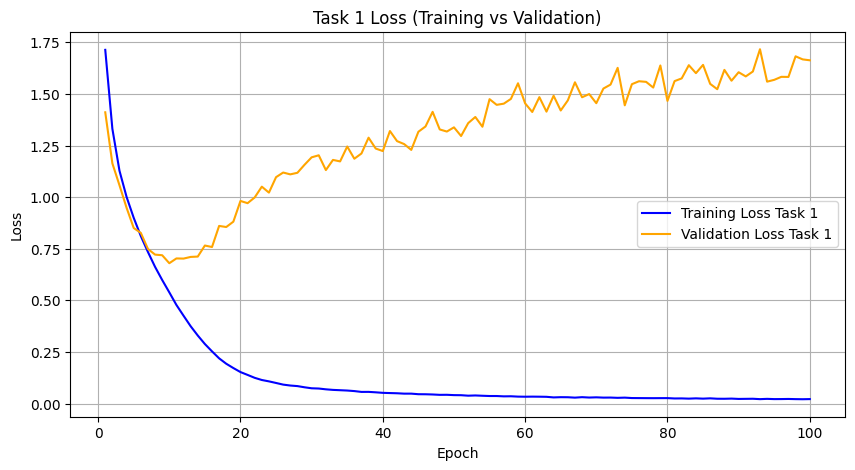

In [25]:
# 1. Task 1 loss
plt.figure(figsize=(10, 5))
plt.plot(stl_task1_results_df['Epoch'], stl_task1_results_df['Train Loss'], label='Training Loss Task 1', color='blue')
plt.plot(stl_task1_results_df['Epoch'], stl_task1_results_df['Valid Loss'], label='Validation Loss Task 1', color='orange')
plt.title('Task 1 Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

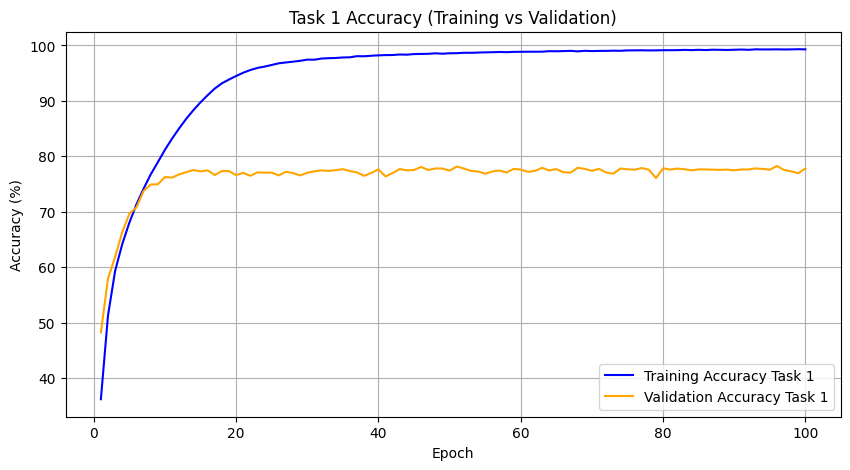

In [26]:
# 2. Task 1 accuracy
plt.figure(figsize=(10, 5))
plt.plot(stl_task1_results_df['Epoch'], stl_task1_results_df['Train Acc'], label='Training Accuracy Task 1', color='blue')
plt.plot(stl_task1_results_df['Epoch'], stl_task1_results_df['Valid Acc'], label='Validation Accuracy Task 1', color='orange')
plt.title('Task 1 Accuracy (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

#### 10.1.3. Model Evaluation on Test Set

In [27]:
model_stl_task1.load_state_dict(torch.load('best_alexnet_stl_task1_model.pt', map_location=device))

test_loss_st1, test_acc_st1 = generic_evaluate_epoch_stl(
    model_stl_task1, test_loader, criterion, device, "task1", epoch_num=None, phase="Test", model_desc="Single Task Learning (Task 1)"
)

Test Single Task Learning (Task 1) (task1): 100%|██████████| 625/625 [00:08<00:00, 73.60it/s]

Test Single Task Learning (Task 1) (task1) Loss: 0.7325, Acc: 75.47%


### 10.2. Task 2 (Multi-class Classification)
#### 4 Classes

In [28]:
# --- STL Training for Task 2 (Multi-class Classification) ---

model_stl_task2 = STLNetwork(output_dim=NUM_OUTPUTS_TASK2).to(device)

print(f'The AlexNet-like model for task 2 has {humanize.intcomma(count_parameters(model_stl_task2))} trainable parameters.')

The AlexNet-like model for task 2 has 7,500,612 trainable parameters.


In [29]:
# Optimizer
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=0.0001)

#### 10.2.1. Training Loop

In [31]:
best_validation_loss_stl_task2 = float('inf')
stl_task2_training_results_list = []

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss_st2, train_acc_st2 = generic_train_epoch_stl(
        model_stl_task2, train_loader, optimizer_stl_task2, criterion, device, "task2", epoch, model_desc="Single Task Learning (Task 2)"
    )
    valid_loss_st2, valid_acc_st2 = generic_evaluate_epoch_stl(
        model_stl_task2, val_loader, criterion, device, "task2", epoch, phase="Validation", model_desc="Single Task Learning (Task 2)"
    )
    if valid_loss_st2 < best_validation_loss_stl_task2:
        best_validation_loss_stl_task2 = valid_loss_st2
        torch.save(model_stl_task2.state_dict(), 'best_alexnet_stl_task2_model.pt')

    # Save the training results for the epoch
    stl_task2_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss": train_loss_st2, "Train Acc": train_acc_st2,
        "Valid Loss": valid_loss_st2, "Valid Acc": valid_acc_st2
    })

end_time = time.time()

stl_task2_results_df = pd.DataFrame(stl_task2_training_results_list)

Epoch 1 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:01<00:00, 45.68it/s]


Epoch: [1] Train Single Task Learning (Task 2) (task2) Loss: 0.0512, Acc: 98.18%


Epoch 1 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 79.25it/s]


Validation Epoch: [1] Single Task Learning (Task 2) (task2) Loss: 0.9771, Acc: 81.16%


Epoch 2 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 44.98it/s]


Epoch: [2] Train Single Task Learning (Task 2) (task2) Loss: 0.0471, Acc: 98.33%


Epoch 2 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 75.89it/s]


Validation Epoch: [2] Single Task Learning (Task 2) (task2) Loss: 0.9635, Acc: 81.75%


Epoch 3 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:06<00:00, 42.41it/s]


Epoch: [3] Train Single Task Learning (Task 2) (task2) Loss: 0.0456, Acc: 98.39%


Epoch 3 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 73.01it/s]


Validation Epoch: [3] Single Task Learning (Task 2) (task2) Loss: 0.8983, Acc: 81.80%


Epoch 4 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 44.81it/s]


Epoch: [4] Train Single Task Learning (Task 2) (task2) Loss: 0.0434, Acc: 98.47%


Epoch 4 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 80.89it/s]


Validation Epoch: [4] Single Task Learning (Task 2) (task2) Loss: 1.0291, Acc: 81.31%


Epoch 5 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.46it/s]


Epoch: [5] Train Single Task Learning (Task 2) (task2) Loss: 0.0426, Acc: 98.50%


Epoch 5 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 79.14it/s]


Validation Epoch: [5] Single Task Learning (Task 2) (task2) Loss: 0.9852, Acc: 81.73%


Epoch 6 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.73it/s]


Epoch: [6] Train Single Task Learning (Task 2) (task2) Loss: 0.0391, Acc: 98.61%


Epoch 6 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 82.48it/s]


Validation Epoch: [6] Single Task Learning (Task 2) (task2) Loss: 0.9922, Acc: 81.62%


Epoch 7 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.75it/s]


Epoch: [7] Train Single Task Learning (Task 2) (task2) Loss: 0.0400, Acc: 98.60%


Epoch 7 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 79.04it/s]


Validation Epoch: [7] Single Task Learning (Task 2) (task2) Loss: 0.9505, Acc: 81.72%


Epoch 8 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.50it/s]


Epoch: [8] Train Single Task Learning (Task 2) (task2) Loss: 0.0378, Acc: 98.66%


Epoch 8 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 79.53it/s]


Validation Epoch: [8] Single Task Learning (Task 2) (task2) Loss: 1.0401, Acc: 81.71%


Epoch 9 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.61it/s]


Epoch: [9] Train Single Task Learning (Task 2) (task2) Loss: 0.0367, Acc: 98.73%


Epoch 9 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 79.29it/s]


Validation Epoch: [9] Single Task Learning (Task 2) (task2) Loss: 1.0691, Acc: 81.30%


Epoch 10 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 44.90it/s]


Epoch: [10] Train Single Task Learning (Task 2) (task2) Loss: 0.0361, Acc: 98.73%


Epoch 10 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.74it/s]


Validation Epoch: [10] Single Task Learning (Task 2) (task2) Loss: 1.0419, Acc: 81.62%


Epoch 11 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 45.01it/s]


Epoch: [11] Train Single Task Learning (Task 2) (task2) Loss: 0.0354, Acc: 98.75%


Epoch 11 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 73.81it/s]


Validation Epoch: [11] Single Task Learning (Task 2) (task2) Loss: 1.0945, Acc: 81.44%


Epoch 12 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 44.80it/s]


Epoch: [12] Train Single Task Learning (Task 2) (task2) Loss: 0.0339, Acc: 98.81%


Epoch 12 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 73.17it/s]


Validation Epoch: [12] Single Task Learning (Task 2) (task2) Loss: 1.1114, Acc: 81.77%


Epoch 13 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.34it/s]


Epoch: [13] Train Single Task Learning (Task 2) (task2) Loss: 0.0337, Acc: 98.80%


Epoch 13 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.29it/s]


Validation Epoch: [13] Single Task Learning (Task 2) (task2) Loss: 1.0165, Acc: 81.64%


Epoch 14 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.40it/s]


Epoch: [14] Train Single Task Learning (Task 2) (task2) Loss: 0.0322, Acc: 98.86%


Epoch 14 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.79it/s]


Validation Epoch: [14] Single Task Learning (Task 2) (task2) Loss: 1.0842, Acc: 81.86%


Epoch 15 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.37it/s]


Epoch: [15] Train Single Task Learning (Task 2) (task2) Loss: 0.0315, Acc: 98.88%


Epoch 15 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 69.76it/s]


Validation Epoch: [15] Single Task Learning (Task 2) (task2) Loss: 1.0004, Acc: 81.83%


Epoch 16 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:01<00:00, 45.90it/s]


Epoch: [16] Train Single Task Learning (Task 2) (task2) Loss: 0.0291, Acc: 99.00%


Epoch 16 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 80.75it/s]


Validation Epoch: [16] Single Task Learning (Task 2) (task2) Loss: 1.1174, Acc: 81.53%


Epoch 17 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.52it/s]


Epoch: [17] Train Single Task Learning (Task 2) (task2) Loss: 0.0303, Acc: 98.96%


Epoch 17 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 80.76it/s]


Validation Epoch: [17] Single Task Learning (Task 2) (task2) Loss: 1.1582, Acc: 81.75%


Epoch 18 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:59<00:00, 46.95it/s]


Epoch: [18] Train Single Task Learning (Task 2) (task2) Loss: 0.0292, Acc: 98.96%


Epoch 18 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 81.03it/s]


Validation Epoch: [18] Single Task Learning (Task 2) (task2) Loss: 1.1219, Acc: 81.84%


Epoch 19 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:01<00:00, 45.55it/s]


Epoch: [19] Train Single Task Learning (Task 2) (task2) Loss: 0.0273, Acc: 99.05%


Epoch 19 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.77it/s]


Validation Epoch: [19] Single Task Learning (Task 2) (task2) Loss: 1.1127, Acc: 81.52%


Epoch 20 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.41it/s]


Epoch: [20] Train Single Task Learning (Task 2) (task2) Loss: 0.0283, Acc: 99.01%


Epoch 20 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.30it/s]


Validation Epoch: [20] Single Task Learning (Task 2) (task2) Loss: 1.1561, Acc: 81.72%


Epoch 21 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.34it/s]


Epoch: [21] Train Single Task Learning (Task 2) (task2) Loss: 0.0270, Acc: 99.08%


Epoch 21 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.16it/s]


Validation Epoch: [21] Single Task Learning (Task 2) (task2) Loss: 1.1335, Acc: 81.79%


Epoch 22 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 44.75it/s]


Epoch: [22] Train Single Task Learning (Task 2) (task2) Loss: 0.0266, Acc: 99.06%


Epoch 22 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.43it/s]


Validation Epoch: [22] Single Task Learning (Task 2) (task2) Loss: 1.1374, Acc: 81.86%


Epoch 23 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.51it/s]


Epoch: [23] Train Single Task Learning (Task 2) (task2) Loss: 0.0259, Acc: 99.11%


Epoch 23 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 82.39it/s]


Validation Epoch: [23] Single Task Learning (Task 2) (task2) Loss: 1.1989, Acc: 82.02%


Epoch 24 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:59<00:00, 47.35it/s]


Epoch: [24] Train Single Task Learning (Task 2) (task2) Loss: 0.0254, Acc: 99.11%


Epoch 24 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 82.96it/s]


Validation Epoch: [24] Single Task Learning (Task 2) (task2) Loss: 1.2233, Acc: 81.64%


Epoch 25 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 45.20it/s]


Epoch: [25] Train Single Task Learning (Task 2) (task2) Loss: 0.0256, Acc: 99.10%


Epoch 25 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.18it/s]


Validation Epoch: [25] Single Task Learning (Task 2) (task2) Loss: 1.2267, Acc: 81.44%


Epoch 26 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.31it/s]


Epoch: [26] Train Single Task Learning (Task 2) (task2) Loss: 0.0239, Acc: 99.18%


Epoch 26 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 71.61it/s]


Validation Epoch: [26] Single Task Learning (Task 2) (task2) Loss: 1.1872, Acc: 82.14%


Epoch 27 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.32it/s]


Epoch: [27] Train Single Task Learning (Task 2) (task2) Loss: 0.0242, Acc: 99.17%


Epoch 27 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.24it/s]


Validation Epoch: [27] Single Task Learning (Task 2) (task2) Loss: 1.1750, Acc: 82.25%


Epoch 28 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.35it/s]


Epoch: [28] Train Single Task Learning (Task 2) (task2) Loss: 0.0241, Acc: 99.19%


Epoch 28 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.74it/s]


Validation Epoch: [28] Single Task Learning (Task 2) (task2) Loss: 1.2267, Acc: 81.71%


Epoch 29 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.29it/s]


Epoch: [29] Train Single Task Learning (Task 2) (task2) Loss: 0.0230, Acc: 99.22%


Epoch 29 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.92it/s]


Validation Epoch: [29] Single Task Learning (Task 2) (task2) Loss: 1.2348, Acc: 82.06%


Epoch 30 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.25it/s]


Epoch: [30] Train Single Task Learning (Task 2) (task2) Loss: 0.0246, Acc: 99.14%


Epoch 30 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 71.50it/s]


Validation Epoch: [30] Single Task Learning (Task 2) (task2) Loss: 1.1674, Acc: 81.74%


Epoch 31 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.27it/s]


Epoch: [31] Train Single Task Learning (Task 2) (task2) Loss: 0.0224, Acc: 99.24%


Epoch 31 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 71.74it/s]


Validation Epoch: [31] Single Task Learning (Task 2) (task2) Loss: 1.2756, Acc: 81.98%


Epoch 32 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.38it/s]


Epoch: [32] Train Single Task Learning (Task 2) (task2) Loss: 0.0216, Acc: 99.27%


Epoch 32 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.11it/s]


Validation Epoch: [32] Single Task Learning (Task 2) (task2) Loss: 1.3600, Acc: 81.75%


Epoch 33 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.26it/s]


Epoch: [33] Train Single Task Learning (Task 2) (task2) Loss: 0.0218, Acc: 99.23%


Epoch 33 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.84it/s]


Validation Epoch: [33] Single Task Learning (Task 2) (task2) Loss: 1.2814, Acc: 81.72%


Epoch 34 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.45it/s]


Epoch: [34] Train Single Task Learning (Task 2) (task2) Loss: 0.0218, Acc: 99.24%


Epoch 34 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 72.97it/s]


Validation Epoch: [34] Single Task Learning (Task 2) (task2) Loss: 1.3137, Acc: 81.61%


Epoch 35 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:02<00:00, 44.70it/s]


Epoch: [35] Train Single Task Learning (Task 2) (task2) Loss: 0.0211, Acc: 99.28%


Epoch 35 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 73.55it/s]


Validation Epoch: [35] Single Task Learning (Task 2) (task2) Loss: 1.2822, Acc: 81.96%


Epoch 36 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:03<00:00, 44.44it/s]


Epoch: [36] Train Single Task Learning (Task 2) (task2) Loss: 0.0207, Acc: 99.30%


Epoch 36 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 76.80it/s]


Validation Epoch: [36] Single Task Learning (Task 2) (task2) Loss: 1.2794, Acc: 81.66%


Epoch 37 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.36it/s]


Epoch: [37] Train Single Task Learning (Task 2) (task2) Loss: 0.0202, Acc: 99.30%


Epoch 37 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 74.78it/s]


Validation Epoch: [37] Single Task Learning (Task 2) (task2) Loss: 1.3236, Acc: 81.93%


Epoch 38 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [01:00<00:00, 46.21it/s]


Epoch: [38] Train Single Task Learning (Task 2) (task2) Loss: 0.0205, Acc: 99.33%


Epoch 38 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 76.57it/s]


Validation Epoch: [38] Single Task Learning (Task 2) (task2) Loss: 1.2955, Acc: 81.38%


Epoch 39 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:59<00:00, 47.38it/s]


Epoch: [39] Train Single Task Learning (Task 2) (task2) Loss: 0.0199, Acc: 99.31%


Epoch 39 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 76.77it/s]


Validation Epoch: [39] Single Task Learning (Task 2) (task2) Loss: 1.3115, Acc: 81.53%


Epoch 40 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:59<00:00, 47.12it/s]


Epoch: [40] Train Single Task Learning (Task 2) (task2) Loss: 0.0202, Acc: 99.31%


Epoch 40 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 77.04it/s]


Validation Epoch: [40] Single Task Learning (Task 2) (task2) Loss: 1.3364, Acc: 81.44%


Epoch 41 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:58<00:00, 47.87it/s]


Epoch: [41] Train Single Task Learning (Task 2) (task2) Loss: 0.0201, Acc: 99.33%


Epoch 41 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.22it/s]


Validation Epoch: [41] Single Task Learning (Task 2) (task2) Loss: 1.2558, Acc: 81.72%


Epoch 42 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.70it/s]


Epoch: [42] Train Single Task Learning (Task 2) (task2) Loss: 0.0192, Acc: 99.35%


Epoch 42 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.08it/s]


Validation Epoch: [42] Single Task Learning (Task 2) (task2) Loss: 1.2468, Acc: 81.92%


Epoch 43 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.77it/s]


Epoch: [43] Train Single Task Learning (Task 2) (task2) Loss: 0.0189, Acc: 99.37%


Epoch 43 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.54it/s]


Validation Epoch: [43] Single Task Learning (Task 2) (task2) Loss: 1.3442, Acc: 82.03%


Epoch 44 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.79it/s]


Epoch: [44] Train Single Task Learning (Task 2) (task2) Loss: 0.0187, Acc: 99.37%


Epoch 44 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.30it/s]


Validation Epoch: [44] Single Task Learning (Task 2) (task2) Loss: 1.1790, Acc: 81.61%


Epoch 45 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.59it/s]


Epoch: [45] Train Single Task Learning (Task 2) (task2) Loss: 0.0190, Acc: 99.38%


Epoch 45 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.62it/s]


Validation Epoch: [45] Single Task Learning (Task 2) (task2) Loss: 1.2074, Acc: 81.48%


Epoch 46 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.76it/s]


Epoch: [46] Train Single Task Learning (Task 2) (task2) Loss: 0.0189, Acc: 99.36%


Epoch 46 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.42it/s]


Validation Epoch: [46] Single Task Learning (Task 2) (task2) Loss: 1.2630, Acc: 81.62%


Epoch 47 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.79it/s]


Epoch: [47] Train Single Task Learning (Task 2) (task2) Loss: 0.0185, Acc: 99.37%


Epoch 47 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 87.13it/s]


Validation Epoch: [47] Single Task Learning (Task 2) (task2) Loss: 1.3603, Acc: 81.33%


Epoch 48 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.96it/s]


Epoch: [48] Train Single Task Learning (Task 2) (task2) Loss: 0.0183, Acc: 99.38%


Epoch 48 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.50it/s]


Validation Epoch: [48] Single Task Learning (Task 2) (task2) Loss: 1.3014, Acc: 81.58%


Epoch 49 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.90it/s]


Epoch: [49] Train Single Task Learning (Task 2) (task2) Loss: 0.0171, Acc: 99.44%


Epoch 49 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 87.03it/s]


Validation Epoch: [49] Single Task Learning (Task 2) (task2) Loss: 1.3475, Acc: 81.12%


Epoch 50 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.91it/s]


Epoch: [50] Train Single Task Learning (Task 2) (task2) Loss: 0.0170, Acc: 99.43%


Epoch 50 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.33it/s]


Validation Epoch: [50] Single Task Learning (Task 2) (task2) Loss: 1.3616, Acc: 81.69%


Epoch 51 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.91it/s]


Epoch: [51] Train Single Task Learning (Task 2) (task2) Loss: 0.0182, Acc: 99.39%


Epoch 51 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.80it/s]


Validation Epoch: [51] Single Task Learning (Task 2) (task2) Loss: 1.3339, Acc: 81.95%


Epoch 52 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.91it/s]


Epoch: [52] Train Single Task Learning (Task 2) (task2) Loss: 0.0164, Acc: 99.44%


Epoch 52 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 87.02it/s]


Validation Epoch: [52] Single Task Learning (Task 2) (task2) Loss: 1.2702, Acc: 81.97%


Epoch 53 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.89it/s]


Epoch: [53] Train Single Task Learning (Task 2) (task2) Loss: 0.0159, Acc: 99.49%


Epoch 53 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.64it/s]


Validation Epoch: [53] Single Task Learning (Task 2) (task2) Loss: 1.3594, Acc: 82.12%


Epoch 54 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.88it/s]


Epoch: [54] Train Single Task Learning (Task 2) (task2) Loss: 0.0166, Acc: 99.44%


Epoch 54 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.77it/s]


Validation Epoch: [54] Single Task Learning (Task 2) (task2) Loss: 1.3249, Acc: 81.50%


Epoch 55 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.82it/s]


Epoch: [55] Train Single Task Learning (Task 2) (task2) Loss: 0.0158, Acc: 99.48%


Epoch 55 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.68it/s]


Validation Epoch: [55] Single Task Learning (Task 2) (task2) Loss: 1.3620, Acc: 81.86%


Epoch 56 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:57<00:00, 48.90it/s]


Epoch: [56] Train Single Task Learning (Task 2) (task2) Loss: 0.0163, Acc: 99.46%


Epoch 56 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.68it/s]


Validation Epoch: [56] Single Task Learning (Task 2) (task2) Loss: 1.3254, Acc: 81.52%


Epoch 57 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.99it/s]


Epoch: [57] Train Single Task Learning (Task 2) (task2) Loss: 0.0160, Acc: 99.43%


Epoch 57 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.74it/s]


Validation Epoch: [57] Single Task Learning (Task 2) (task2) Loss: 1.3625, Acc: 81.75%


Epoch 58 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 50.00it/s]


Epoch: [58] Train Single Task Learning (Task 2) (task2) Loss: 0.0161, Acc: 99.46%


Epoch 58 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.61it/s]


Validation Epoch: [58] Single Task Learning (Task 2) (task2) Loss: 1.2394, Acc: 81.61%


Epoch 59 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.98it/s]


Epoch: [59] Train Single Task Learning (Task 2) (task2) Loss: 0.0163, Acc: 99.44%


Epoch 59 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.25it/s]


Validation Epoch: [59] Single Task Learning (Task 2) (task2) Loss: 1.2201, Acc: 81.88%


Epoch 60 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.96it/s]


Epoch: [60] Train Single Task Learning (Task 2) (task2) Loss: 0.0153, Acc: 99.49%


Epoch 60 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.99it/s]


Validation Epoch: [60] Single Task Learning (Task 2) (task2) Loss: 1.3150, Acc: 81.72%


Epoch 61 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.99it/s]


Epoch: [61] Train Single Task Learning (Task 2) (task2) Loss: 0.0154, Acc: 99.49%


Epoch 61 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.67it/s]


Validation Epoch: [61] Single Task Learning (Task 2) (task2) Loss: 1.3228, Acc: 81.97%


Epoch 62 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.95it/s]


Epoch: [62] Train Single Task Learning (Task 2) (task2) Loss: 0.0157, Acc: 99.48%


Epoch 62 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.99it/s]


Validation Epoch: [62] Single Task Learning (Task 2) (task2) Loss: 1.3263, Acc: 82.02%


Epoch 63 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.96it/s]


Epoch: [63] Train Single Task Learning (Task 2) (task2) Loss: 0.0153, Acc: 99.47%


Epoch 63 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.68it/s]


Validation Epoch: [63] Single Task Learning (Task 2) (task2) Loss: 1.2643, Acc: 81.68%


Epoch 64 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 50.00it/s]


Epoch: [64] Train Single Task Learning (Task 2) (task2) Loss: 0.0137, Acc: 99.55%


Epoch 64 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 87.10it/s]


Validation Epoch: [64] Single Task Learning (Task 2) (task2) Loss: 1.4664, Acc: 81.83%


Epoch 65 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.95it/s]


Epoch: [65] Train Single Task Learning (Task 2) (task2) Loss: 0.0153, Acc: 99.50%


Epoch 65 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.40it/s]


Validation Epoch: [65] Single Task Learning (Task 2) (task2) Loss: 1.3505, Acc: 81.41%


Epoch 66 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 50.00it/s]


Epoch: [66] Train Single Task Learning (Task 2) (task2) Loss: 0.0145, Acc: 99.50%


Epoch 66 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.07it/s]


Validation Epoch: [66] Single Task Learning (Task 2) (task2) Loss: 1.3847, Acc: 81.73%


Epoch 67 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.98it/s]


Epoch: [67] Train Single Task Learning (Task 2) (task2) Loss: 0.0138, Acc: 99.55%


Epoch 67 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.29it/s]


Validation Epoch: [67] Single Task Learning (Task 2) (task2) Loss: 1.4129, Acc: 81.81%


Epoch 68 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.97it/s]


Epoch: [68] Train Single Task Learning (Task 2) (task2) Loss: 0.0147, Acc: 99.51%


Epoch 68 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.05it/s]


Validation Epoch: [68] Single Task Learning (Task 2) (task2) Loss: 1.4019, Acc: 81.62%


Epoch 69 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.88it/s]


Epoch: [69] Train Single Task Learning (Task 2) (task2) Loss: 0.0144, Acc: 99.52%


Epoch 69 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.59it/s]


Validation Epoch: [69] Single Task Learning (Task 2) (task2) Loss: 1.3361, Acc: 81.53%


Epoch 70 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.94it/s]


Epoch: [70] Train Single Task Learning (Task 2) (task2) Loss: 0.0136, Acc: 99.53%


Epoch 70 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 87.11it/s]


Validation Epoch: [70] Single Task Learning (Task 2) (task2) Loss: 1.3797, Acc: 81.58%


Epoch 71 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.90it/s]


Epoch: [71] Train Single Task Learning (Task 2) (task2) Loss: 0.0140, Acc: 99.55%


Epoch 71 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.68it/s]


Validation Epoch: [71] Single Task Learning (Task 2) (task2) Loss: 1.4028, Acc: 81.43%


Epoch 72 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.93it/s]


Epoch: [72] Train Single Task Learning (Task 2) (task2) Loss: 0.0135, Acc: 99.53%


Epoch 72 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.84it/s]


Validation Epoch: [72] Single Task Learning (Task 2) (task2) Loss: 1.3563, Acc: 81.95%


Epoch 73 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.85it/s]


Epoch: [73] Train Single Task Learning (Task 2) (task2) Loss: 0.0137, Acc: 99.55%


Epoch 73 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.90it/s]


Validation Epoch: [73] Single Task Learning (Task 2) (task2) Loss: 1.3924, Acc: 81.75%


Epoch 74 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.86it/s]


Epoch: [74] Train Single Task Learning (Task 2) (task2) Loss: 0.0145, Acc: 99.52%


Epoch 74 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.02it/s]


Validation Epoch: [74] Single Task Learning (Task 2) (task2) Loss: 1.3104, Acc: 81.61%


Epoch 75 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.78it/s]


Epoch: [75] Train Single Task Learning (Task 2) (task2) Loss: 0.0132, Acc: 99.56%


Epoch 75 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.88it/s]


Validation Epoch: [75] Single Task Learning (Task 2) (task2) Loss: 1.4578, Acc: 81.70%


Epoch 76 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.92it/s]


Epoch: [76] Train Single Task Learning (Task 2) (task2) Loss: 0.0130, Acc: 99.57%


Epoch 76 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.24it/s]


Validation Epoch: [76] Single Task Learning (Task 2) (task2) Loss: 1.3854, Acc: 81.86%


Epoch 77 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.88it/s]


Epoch: [77] Train Single Task Learning (Task 2) (task2) Loss: 0.0133, Acc: 99.56%


Epoch 77 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.96it/s]


Validation Epoch: [77] Single Task Learning (Task 2) (task2) Loss: 1.3422, Acc: 81.93%


Epoch 78 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.91it/s]


Epoch: [78] Train Single Task Learning (Task 2) (task2) Loss: 0.0135, Acc: 99.53%


Epoch 78 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.15it/s]


Validation Epoch: [78] Single Task Learning (Task 2) (task2) Loss: 1.3191, Acc: 81.64%


Epoch 79 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.87it/s]


Epoch: [79] Train Single Task Learning (Task 2) (task2) Loss: 0.0127, Acc: 99.58%


Epoch 79 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.84it/s]


Validation Epoch: [79] Single Task Learning (Task 2) (task2) Loss: 1.4652, Acc: 81.53%


Epoch 80 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.84it/s]


Epoch: [80] Train Single Task Learning (Task 2) (task2) Loss: 0.0135, Acc: 99.55%


Epoch 80 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.38it/s]


Validation Epoch: [80] Single Task Learning (Task 2) (task2) Loss: 1.3552, Acc: 81.84%


Epoch 81 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.91it/s]


Epoch: [81] Train Single Task Learning (Task 2) (task2) Loss: 0.0130, Acc: 99.58%


Epoch 81 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.88it/s]


Validation Epoch: [81] Single Task Learning (Task 2) (task2) Loss: 1.3463, Acc: 81.79%


Epoch 82 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.88it/s]


Epoch: [82] Train Single Task Learning (Task 2) (task2) Loss: 0.0127, Acc: 99.57%


Epoch 82 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.98it/s]


Validation Epoch: [82] Single Task Learning (Task 2) (task2) Loss: 1.4500, Acc: 81.64%


Epoch 83 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.95it/s]


Epoch: [83] Train Single Task Learning (Task 2) (task2) Loss: 0.0134, Acc: 99.58%


Epoch 83 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.60it/s]


Validation Epoch: [83] Single Task Learning (Task 2) (task2) Loss: 1.3013, Acc: 82.09%


Epoch 84 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.86it/s]


Epoch: [84] Train Single Task Learning (Task 2) (task2) Loss: 0.0130, Acc: 99.55%


Epoch 84 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.83it/s]


Validation Epoch: [84] Single Task Learning (Task 2) (task2) Loss: 1.3794, Acc: 81.57%


Epoch 85 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.83it/s]


Epoch: [85] Train Single Task Learning (Task 2) (task2) Loss: 0.0120, Acc: 99.61%


Epoch 85 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.32it/s]


Validation Epoch: [85] Single Task Learning (Task 2) (task2) Loss: 1.4100, Acc: 81.73%


Epoch 86 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.86it/s]


Epoch: [86] Train Single Task Learning (Task 2) (task2) Loss: 0.0124, Acc: 99.59%


Epoch 86 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.98it/s]


Validation Epoch: [86] Single Task Learning (Task 2) (task2) Loss: 1.4410, Acc: 81.53%


Epoch 87 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.82it/s]


Epoch: [87] Train Single Task Learning (Task 2) (task2) Loss: 0.0124, Acc: 99.60%


Epoch 87 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.77it/s]


Validation Epoch: [87] Single Task Learning (Task 2) (task2) Loss: 1.3746, Acc: 81.33%


Epoch 88 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.90it/s]


Epoch: [88] Train Single Task Learning (Task 2) (task2) Loss: 0.0115, Acc: 99.62%


Epoch 88 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.11it/s]


Validation Epoch: [88] Single Task Learning (Task 2) (task2) Loss: 1.3956, Acc: 81.49%


Epoch 89 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.87it/s]


Epoch: [89] Train Single Task Learning (Task 2) (task2) Loss: 0.0123, Acc: 99.60%


Epoch 89 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.36it/s]


Validation Epoch: [89] Single Task Learning (Task 2) (task2) Loss: 1.4728, Acc: 81.36%


Epoch 90 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.81it/s]


Epoch: [90] Train Single Task Learning (Task 2) (task2) Loss: 0.0120, Acc: 99.62%


Epoch 90 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.14it/s]


Validation Epoch: [90] Single Task Learning (Task 2) (task2) Loss: 1.3467, Acc: 81.61%


Epoch 91 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.87it/s]


Epoch: [91] Train Single Task Learning (Task 2) (task2) Loss: 0.0117, Acc: 99.62%


Epoch 91 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.65it/s]


Validation Epoch: [91] Single Task Learning (Task 2) (task2) Loss: 1.4142, Acc: 82.07%


Epoch 92 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.91it/s]


Epoch: [92] Train Single Task Learning (Task 2) (task2) Loss: 0.0122, Acc: 99.59%


Epoch 92 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.78it/s]


Validation Epoch: [92] Single Task Learning (Task 2) (task2) Loss: 1.4927, Acc: 81.55%


Epoch 93 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.90it/s]


Epoch: [93] Train Single Task Learning (Task 2) (task2) Loss: 0.0122, Acc: 99.61%


Epoch 93 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.78it/s]


Validation Epoch: [93] Single Task Learning (Task 2) (task2) Loss: 1.3369, Acc: 81.86%


Epoch 94 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.89it/s]


Epoch: [94] Train Single Task Learning (Task 2) (task2) Loss: 0.0115, Acc: 99.62%


Epoch 94 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 87.03it/s]


Validation Epoch: [94] Single Task Learning (Task 2) (task2) Loss: 1.4316, Acc: 81.57%


Epoch 95 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.88it/s]


Epoch: [95] Train Single Task Learning (Task 2) (task2) Loss: 0.0118, Acc: 99.61%


Epoch 95 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 85.90it/s]


Validation Epoch: [95] Single Task Learning (Task 2) (task2) Loss: 1.3669, Acc: 81.88%


Epoch 96 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.85it/s]


Epoch: [96] Train Single Task Learning (Task 2) (task2) Loss: 0.0119, Acc: 99.61%


Epoch 96 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:04<00:00, 77.27it/s]


Validation Epoch: [96] Single Task Learning (Task 2) (task2) Loss: 1.3905, Acc: 81.97%


Epoch 97 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.86it/s]


Epoch: [97] Train Single Task Learning (Task 2) (task2) Loss: 0.0108, Acc: 99.66%


Epoch 97 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.49it/s]


Validation Epoch: [97] Single Task Learning (Task 2) (task2) Loss: 1.5899, Acc: 81.52%


Epoch 98 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.96it/s]


Epoch: [98] Train Single Task Learning (Task 2) (task2) Loss: 0.0114, Acc: 99.61%


Epoch 98 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.67it/s]


Validation Epoch: [98] Single Task Learning (Task 2) (task2) Loss: 1.4533, Acc: 81.55%


Epoch 99 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.86it/s]


Epoch: [99] Train Single Task Learning (Task 2) (task2) Loss: 0.0123, Acc: 99.58%


Epoch 99 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.18it/s]


Validation Epoch: [99] Single Task Learning (Task 2) (task2) Loss: 1.4640, Acc: 81.64%


Epoch 100 Training Single Task Learning (Task 2) (task2): 100%|██████████| 2813/2813 [00:56<00:00, 49.89it/s]


Epoch: [100] Train Single Task Learning (Task 2) (task2) Loss: 0.0116, Acc: 99.62%


Epoch 100 Validation Single Task Learning (Task 2) (task2): 100%|██████████| 313/313 [00:03<00:00, 86.68it/s]

Validation Epoch: [100] Single Task Learning (Task 2) (task2) Loss: 1.4456, Acc: 81.57%


In [32]:
# Print the time taken for training
training_time_stl_task2 = end_time - time_start

# Convert total seconds to an integer
total_seconds = int(training_time_stl_task2)

# Calculate hours, minutes, and remaining seconds
minutes, seconds = divmod(total_seconds, 60)
hours, minutes = divmod(minutes, 60)

# Print the time taken for training in H, M, S format
print(f"To train the model for task 2 (4-class classification) for 100 epochs, it took {hours} hours, {minutes} minutes, {seconds} seconds.")

To train the model for task 2 (4-class classification) for 100 epochs, it took 1 hours, 44 minutes, 17 seconds.


#### 10.2.2. Training and Validation Results

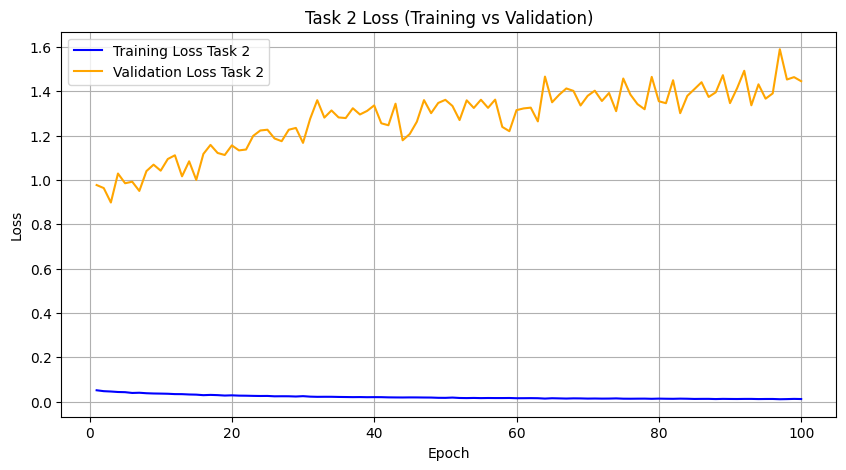

In [33]:
# 1. Task 2 loss
plt.figure(figsize=(10, 5))
plt.plot(stl_task2_results_df['Epoch'], stl_task2_results_df['Train Loss'], label='Training Loss Task 2', color='blue')
plt.plot(stl_task2_results_df['Epoch'], stl_task2_results_df['Valid Loss'], label='Validation Loss Task 2', color='orange')
plt.title('Task 2 Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

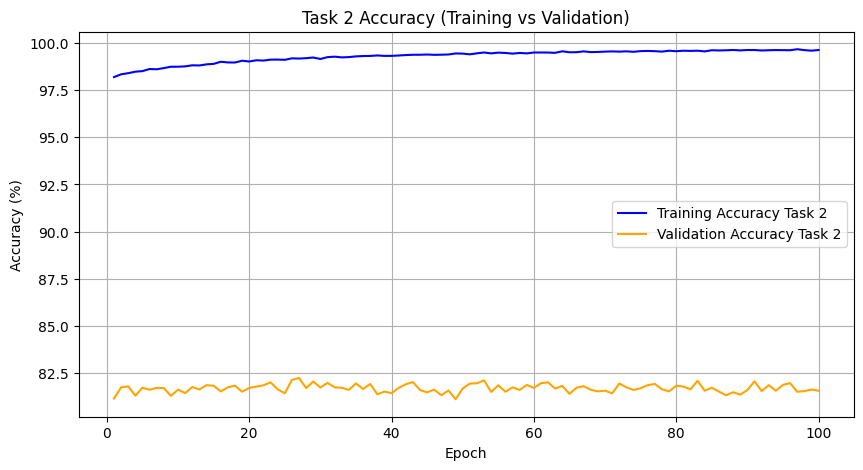

In [34]:
# 2. Task 2 accuracy
plt.figure(figsize=(10, 5))
plt.plot(stl_task2_results_df['Epoch'], stl_task2_results_df['Train Acc'], label='Training Accuracy Task 2', color='blue')
plt.plot(stl_task2_results_df['Epoch'], stl_task2_results_df['Valid Acc'], label='Validation Accuracy Task 2', color='orange')
plt.title('Task 2 Accuracy (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

#### 10.2.3. Model Evaluation on Test Set

In [35]:
model_stl_task2.load_state_dict(torch.load('best_alexnet_stl_task2_model.pt', map_location=device))

test_loss_st2, test_acc_st2 = generic_evaluate_epoch_stl(
    model_stl_task2, test_loader, criterion, device, "task2", epoch_num=None, phase="Test", model_desc="Single Task Learning (Task 2)"
)

Test Single Task Learning (Task 2) (task2): 100%|██████████| 625/625 [00:08<00:00, 75.83it/s]

Test Single Task Learning (Task 2) (task2) Loss: 0.9281, Acc: 81.09%
